<h1><b>Задача по предсказанию рейтинга шоколада

<h3><b>Никнейм на Kaggle: 

# Описание задачи

In [1316]:
# Даны характеристики шоколадок и по ним нужно предсказать их рейтинг.

# Описание данных
# Company - компания производитель
# Specific Bean Origin - географический регион происхождения
# REF - параметр, определяющий момент внесения записи в базу данных (чем выше значение, тем "свежее" запись)
# Review - дата публикации отзыва
# Cocoa Percent - процентное содержание какао
# Company Location - страна производитель
# Rating - экспертный рейтинг
# Bean Type - используемый сорт какао-бобов, если таковой имеется
# Broad Bean Origin - географический регион происхождения какао-бобов

# Файлы с данными
# choco_train.csv - тренировочные данные
# choco_test_new.csv - тестовые данные
# choco_sample_submission.csv - пример submission

# Импорт библиотек, константы

In [1317]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [1318]:
import warnings
warnings.filterwarnings("ignore")

In [1319]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from category_encoders.ordinal import OrdinalEncoder
from category_encoders.one_hot import OneHotEncoder
from category_encoders.target_encoder import TargetEncoder
from category_encoders.leave_one_out import LeaveOneOutEncoder
from sklearn.preprocessing import LabelEncoder

In [1320]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor, CatBoostClassifier
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
import optuna

In [1321]:
from scipy import stats
from association_metrics import CramersV
import phik
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
import pickle

In [1322]:
SEED = 4784

<!-- # Загрузка данных -->

# Загрузка данных

In [1323]:
# TRAIN = "https://raw.githubusercontent.com/evgpat/edu_stepik_practical_ml/main/datasets/chocolate_train.csv"
# TEST = "https://raw.githubusercontent.com/evgpat/edu_stepik_practical_ml/main/datasets/chocolate_test_new.csv"
TRAIN = 'data\chocolate-rating\chocolate_train.csv'
TEST = 'data\chocolate-rating\chocolate_test_new.csv'

In [1324]:
train = pd.read_csv(TRAIN)

In [1325]:
test = pd.read_csv(TEST)

# Обзор данных

Описание данных
* Company - компания производитель
* Specific Bean Origin - географический регион происхождения
* REF - параметр, определяющий момент внесения записи в базу данных (чем выше значение, тем "свежее" запись)
* Review - дата публикации отзыва
* Cocoa Percent - процентное содержание какао
* Company Location - страна производитель
* Rating - экспертный рейтинг
* Bean Type - используемый сорт какао-бобов, если таковой имеется
* Broad Bean Origin - географический регион происхождения какао-бобов

Рассмотрим на первые 5 строчек, чтобы понять, как выглядят значения.

In [1326]:
train.head()

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin
0,Willie's Cacao,Rio Caribe,457,2009,72%,U.K.,3.25,Trinitario,Venezuela
1,Beschle (Felchlin),"Ocumare, Premier Cru, Quizas No. 2",508,2010,72%,Switzerland,3.50,,Venezuela
2,Dark Forest,Tanzania,1554,2015,70%,U.S.A.,3.00,,Tanzania
3,Brasstown aka It's Chocolate,Cooproagro,1125,2013,72%,U.S.A.,3.00,Trinitario,Dominican Republic
4,Pralus,"Java, Indonesie",32,2006,75%,France,3.50,Criollo,Indonesia


## Информация о колонках

In [1327]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1255 entries, 0 to 1254
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Company               1255 non-null   object 
 1   Specific Bean Origin  1255 non-null   object 
 2   REF                   1255 non-null   int64  
 3   Review                1255 non-null   int64  
 4   Cocoa Percent         1255 non-null   object 
 5   Company Location      1255 non-null   object 
 6   Rating                1255 non-null   float64
 7   Bean Type             1254 non-null   object 
 8   Broad Bean Origin     1254 non-null   object 
dtypes: float64(1), int64(2), object(6)
memory usage: 88.4+ KB


## Обзор основных статистик

Для числовых колонок

In [1328]:
train.describe(include='number').T

,count,mean,std,min,25%,50%,75%,max
REF,1255.0,1045.152191,551.284249,5.0,593.00,1077.00,1514.0,1952.0
Review,1255.0,2012.382470,2.922499,2006.0,2010.00,2013.00,2015.0,2017.0
Rating,1255.0,3.176494,0.478948,1.0,2.75,3.25,3.5,5.0


Минимальные и максчимальные значения числовых признаков находятся допустимых интервалах.

Для категориальных колонок

In [1329]:
train.describe(exclude='number').T

,count,unique,top,freq
Company,1255,376,Soma,35
Specific Bean Origin,1255,762,Madagascar,39
Cocoa Percent,1255,40,70%,461
Company Location,1255,58,U.S.A.,521
Bean Type,1254,38,,628
Broad Bean Origin,1254,84,Venezuela,144


Метод pd.describe() 'схлопывает' пустые значения, следовательно в колонке Bean Type значение отличное от Nan. <br>
Заменим это значение на Nan и повторно применим к датасету метод pd.describe().

In [1330]:
train['Bean Type'].value_counts().index[0]

'\xa0'

In [1331]:
train = train.replace('\xa0', np.NaN)
test = test.replace('\xa0', np.NaN)

In [1332]:
train.describe(exclude='number').T

,count,unique,top,freq
Company,1255,376,Soma,35
Specific Bean Origin,1255,762,Madagascar,39
Cocoa Percent,1255,40,70%,461
Company Location,1255,58,U.S.A.,521
Bean Type,626,37,Trinitario,285
Broad Bean Origin,1199,83,Venezuela,144


# EDA (Разведочный анализ данных)

## Проверка на наличие дубликатов

In [1333]:
train.duplicated().sum()

0

## Уникальные значения в колонках

In [1334]:
# Функция для анализа количества уникальных значений признаков 
# по отношению к общему количеству объектов датасета

def get_nunique(df):
    print(f'Строк в датасете: {len(df)}\n')
    print('Количество уникальных значений в колонках:\n' + 
          f'{df.nunique().sort_values(ascending=False)}')

In [1335]:
get_nunique(train)

Строк в датасете: 1255

Количество уникальных значений в колонках:
Specific Bean Origin    762
REF                     433
Company                 376
Broad Bean Origin        83
Company Location         58
Cocoa Percent            40
Bean Type                37
Rating                   13
Review                   12
dtype: int64


In [1336]:
get_nunique(test)

Строк в датасете: 540

Количество уникальных значений в колонках:
Specific Bean Origin    385
REF                     338
Company                 244
Broad Bean Origin        59
Company Location         42
Cocoa Percent            38
Bean Type                19
Review                   12
dtype: int64


В некоторых колонках слишком много уникальных категориальных значений относительно количества объектов в датасете. <br>
В дальнейшем попробуем сократить количество уникальных значений, тем самым повысим обобщающую способность будущей модели.

## Пропуски в данных

In [1337]:
# Функция для анализа количества пропусков в колонках признаков 
# по отношению к общему количеству объектов датасета

def get_isna(df):
    print(f'Строк в датасете: {len(df)}\n')
    print('Количество пропусков в колонках:\n' + 
          f'{df.isna().sum().sort_values(ascending=False)}')

In [1338]:
get_isna(train)

Строк в датасете: 1255

Количество пропусков в колонках:
Bean Type               629
Broad Bean Origin        56
Company                   0
Specific Bean Origin      0
REF                       0
Review                    0
Cocoa Percent             0
Company Location          0
Rating                    0
dtype: int64


In [1339]:
get_isna(test)

Строк в датасете: 540

Количество пропусков в колонках:
Bean Type               259
Broad Bean Origin        18
Company                   0
Specific Bean Origin      0
REF                       0
Review                    0
Cocoa Percent             0
Company Location          0
dtype: int64


Визуализируем отсутствующие значения признаков

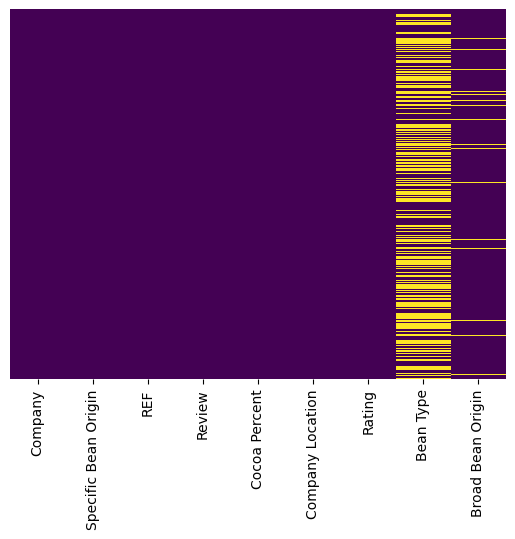

In [1340]:
sns.heatmap(train.isna(), yticklabels=False, cbar=False, cmap='viridis')

plt.show();

In [1341]:
# Процент отсутвующих значений в колонке 'Bean Type'
train['Bean Type'].isna().sum() / len(train)

0.501195219123506

В колонке 'Bean Type' более 50% пропусков, вероятно ее необходимо будет удалить.

## Унифицирование формата колонок

Унифицируем формат колонок с текстовыми значениями с помощю метода str.title()

In [1342]:
# train = train.map(lambda x: x.strip().title() if isinstance(x, str) else x)
# test = test.map(lambda x: x.strip().title() if isinstance(x, str) else x)

In [1343]:
# train['Cocoa Percent'] = train['Cocoa Percent'].str.rstrip('%').astype(np.float32)
# test['Cocoa Percent'] = test['Cocoa Percent'].str.rstrip('%').astype(np.float32)

## Опечатки / некорректные значения

В целях получения максимума информации для анализа варинтов некорректного заполнения значений признаков <br>
объединим датафреймы train и test.

In [1344]:
# df_concat = pd.concat([train, test], axis=0)

In [1345]:
# df_concat.columns

<!-- 'Company' -->

In [1346]:
# print(df_concat['Company'].sort_values().unique())

<!-- Выявленные некорректные значения: -->

In [1347]:
# np.sum((df_concat['Company'] == 'Na�Ve')) # Naive

In [1348]:
# np.sum((df_concat['Company'] == 'Shattel')) # Shattell

<!-- 'Specific Bean Origin' -->

In [1349]:
# df_concat['Specific Bean Origin'].nunique()

In [1350]:
# (df_concat['Specific Bean Origin'].sort_values().unique()[:500])

<!-- Выявленные некорректные значения: -->

In [1351]:
# np.sum(df_concat['Specific Bean Origin'] == 'Colombie') # Colombia

In [1352]:
# np.sum(df_concat['Specific Bean Origin'] == 'Kolumbia') # Colombia

In [1353]:
# np.sum(df_concat['Specific Bean Origin'] == 'Grenade') # Grenada

In [1354]:
# np.sum(df_concat['Specific Bean Origin'] == 'Ecuador Puristique') # Ecuador, Puristique

In [1355]:
# np.sum(df_concat['Specific Bean Origin'] == 'Dominican Republicm, Rustic') # Dominican Republic, Rustic

In [1356]:
# (df_concat['Specific Bean Origin'].sort_values().unique()[500:])

In [1357]:
# np.sum(df_concat['Specific Bean Origin'] == 'Nicaragua, W/ Inbs') # Nicaragua

In [1358]:
# np.sum(df_concat['Specific Bean Origin'] == 'Nicaraqua') # Nicaragua

In [1359]:
# np.sum(df_concat['Specific Bean Origin'] == 'Papaua New Guinea') # Papua New Guinea

In [1360]:
# np.sum(df_concat['Specific Bean Origin'] == 'Papouasie') # Papua New Guinea

In [1361]:
# np.sum(df_concat['Specific Bean Origin'] == 'Venzuela') # Venezuela

<!-- 'Company Location' -->

In [1362]:
# print(df_concat['Company Location'].sort_values().unique())

<!-- Выявленные некорректные значения: -->

In [1363]:
# np.sum(df_concat['Company Location'] == 'Domincan Republic') # Dominican Republic

In [1364]:
# np.sum(df_concat['Company Location'] == 'Niacragua') # Nicaragua

In [1365]:
# np.sum(df_concat['Company Location'] == 'Eucador') # Ecuador

<!-- 'Bean Type' -->

In [1366]:
# print(df_concat['Bean Type'].sort_values().unique())

In [1367]:
# np.sum(df_concat['Bean Type'] == 'Forastero (Arriba) Asss') # 'Forastero (Arriba)'

In [1368]:
# np.sum(df_concat['Bean Type'] == 'Forastero (Arriba) Ass') # 'Forastero (Arriba)'

<!-- ## Исправление некорректных значений -->

<!-- Напишем функцию со словарями для исправления некорректных значений -->

In [1369]:
# def mapping_incorrect(value, col_name):

#     incorrect_company = {
#         'Naive': ['Naive', 'Na�Ve'],
#         'Shattell': ['Shattell', 'Shattel']
#     }

#     incorrect_sb_origin = {
#         'Colombia': ['Colombia', 'Colombie', 'Kolumbia'],
#         'Grenada': ['Grenada', 'Grenade'],
#         'Ecuador, Puristique': ['Ecuador, Puristique', 'Ecuador Puristique'],
#         'Dominican Republic, Rustic': ['Dominican Republic, Rustic', 'Dominican Republicm, Rustic'],
#         'Nicaragua': ['Nicaragua', 'Nicaragua', 'Nicaragua, W/ Inbs'],
#         'Papua New Guinea': ['Papua New Guinea', 'Papaua New Guinea', 'Papouasie'],
#         'Venezuela': ['Venezuela', 'Venzuela', 'Kolumbia']
#     }

#     incorrect_company_location = {
#         'Dominican Republic': ['Dominican Republic', 'Domincan Republic'],
#         'Nicaragua': ['Nicaragua', 'Niacragua'],
#         'Ecuador': ['Ecuador', 'Eucador']
#     }

#     incorrect_bean_type = {
#         'Forastero (Arriba)': ['Forastero (Arriba)', 'Forastero (Arriba) Asss', 'Forastero (Arriba) Ass']
#     }    

#     col_dct = {
#        'Company': incorrect_company,
#        'Specific Bean Origin': incorrect_sb_origin,
#        'Company Location': incorrect_company_location,
#        'Bean Type': incorrect_bean_type
#     }

#     col = col_dct.get(col_name)

#     if col is None:
#         return value

#     for group, values in col.items():
#         if value in values:
#             return group
#     return value

In [1370]:
# def df_mapping_incorrect(df):
#     df = df.copy()
#     for col_name in ['Company', 'Specific Bean Origin', 'Company Location', 'Bean Type']:
#         df[col_name] = df[col_name].apply(mapping_incorrect, args=(col_name,))

#     return df

In [1371]:
# train = df_mapping_incorrect(train)
# test = df_mapping_incorrect(test)

## Группировка значений признаков

In [1372]:
# df_concat['Bean Type'].sort_values().unique()
# df_concat['Broad Bean Origin'].sort_values().unique()

In [1373]:
# def mapping_groups(value, col_name):

#     groups_bean_type = {
#         'Amazonian': ['Amazon', 'Amazon Mix', 'Amazon, Ics'],
#         'Blend': ['Blend', 'Blend-Forastero,Criollo', 'Criollo, Forastero', 'Criollo, Trinitario', 
#                 'Forastero, Trinitario', 'Trinitario, Criollo', 'Trinitario, Forastero',
#                 'Trinitario, Nacional', 'Trinitario, Tcga'],
#         'Criollo': ['Criollo', 'Criollo (Amarru)', 'Criollo (Ocumare 61)', 'Criollo (Ocumare 67)',
#                     'Criollo (Ocumare 77)', 'Criollo (Ocumare)', 'Criollo (Porcelana)', 'Criollo (Wild)', 'Criollo, +'],
#         'Forastero': ['Forastero', 'Forastero (Amelonado)', 'Forastero (Arriba)', 'Forastero (Catongo)',
#                       'Forastero (Nacional)', 'Forastero (Parazinho)', 'Forastero(Arriba, Ccn)'],
#         'Nacional': ['Nacional', 'Nacional (Arriba)'],
#         'Trinitario': ['Trinitario', 'Trinitario (85% Criollo)', 'Trinitario (Amelonado)', 'Trinitario (Scavina)']
#     }

#     groups_bb_origin = {
#         'Caribbean': ['Carribean', 'Carribean(Dr/Jam/Tri)', 'Venezuela, Carribean', 'Africa, Carribean, C. Am.'],
#         'Costa Rica': ['Cost Rica, Ven', 'Costa Rica'],
#         'Dominican Republic': ['Dom. Rep., Madagascar', 'Domincan Republic', 'Dominican Rep., Bali', 'Dominican Republic'],
#         'Ecuador': ['Ecuador', 'Ecuador, Costa Rica', 'Ecuador, Mad., Png', 'Dr, Ecuador, Peru', 'Per/Ecuador, Venezuela', 'Colombia, Ecuador'],
#         'Ghana': ['Ghana', 'Ghana & Madagascar', 'Ghana, Panama, Ecuador'],
#         'Indonesia': ['Indonesia', 'Indonesia, Ghana'],
#         'Madagascar': ['Mad., Java, Png', 'Madagascar', 'Madagascar & Ecuador'],
#         'Papua New Guinea': ['Papua New Guinea', 'Gre., Png, Haw., Haiti, Mad', 'Png, Vanuatu, Mad'],
#         'Peru': ['Peru','Peru(Smartin,Pangoa,Nacional)','Peru, Belize','Peru, Dom. Rep', 'Peru, Ecuador',
#                  'Peru, Ecuador, Venezuela', 'Peru, Mad., Dom. Rep.', 'Guat., D.R., Peru, Mad., Png', 'Peru, Madagascar'],
#         'Sao Tome': ['Sao Tome', 'Sao Tome & Principe'],
#         'South America': [ 'Central And S. America', 'South America', 'South America, Africa'],
#         'Trinidad': ['Trinidad', 'Trinidad, Ecuador', 'Trinidad, Tobago',  'Venezuela, Trinidad', 'Tobago', 'Trinidad-Tobago'],
#         'Venezuela': ['Ven, Bolivia, D.R.', 'Ven, Trinidad, Ecuador', 'Ven., Indonesia, Ecuad.', 'Ven., Trinidad, Mad.',
#                       'Ven.,Ecu.,Peru,Nic.', 'Venez,Africa,Brasil,Peru,Mex', 'Venezuela', 'Venezuela, Carribean',
#                       'Venezuela, Dom. Rep.', 'Venezuela, Ghana', 'Venezuela, Java', 'Venezuela, Trinidad', 'Venezuela/ Ghana']
# }

#     col_dct = {
#        'Bean Type': groups_bean_type,
#        'Broad Bean Origin': groups_bb_origin
#     }

#     col = col_dct.get(col_name)

#     if col is None:
#         return value

#     for group, values in col.items():
#         if value in values:
#             return group
#     return value

In [1374]:
# def df_mapping_groups(df):
#     df = df.copy()
#     # for col_name in ['Company Location', 'Broad Bean Origin']:
#     for col_name in ['Bean Type', 'Broad Bean Origin']:
#         col_new = f'{col_name}'
#         df[col_new] = df[col_name].apply(mapping_groups, args=(col_name,))

#     return df

In [1375]:
# train = df_mapping_groups(train)
# test = df_mapping_groups(test)
# df_concat = df_mapping_groups(df_concat)

In [1376]:
df_concat = pd.concat([train, train], axis=0)

In [1377]:
def bean_type_mapping(value):
    bean_types = {
    'Amazonian': ['Amazon', 'Amazon mix', 'Amazon, ICS'],
    'Blend': ['Blend', 'Blend-Forastero,Criollo', 'Criollo, Forastero', 'Criollo, Trinitario', 
              'Forastero, Trinitario', 'Trinitario, Criollo', 'Trinitario, Forastero',
              'Trinitario, Nacional', 'Trinitario, TCGA'],
    'Criollo': ['Criollo', 'Criollo (Amarru)', 'Criollo (Ocumare 61)', 'Criollo (Ocumare 67)',
                'Criollo (Ocumare 77)', 'Criollo (Ocumare)', 'Criollo (Porcelana)', 'Criollo (Wild)', 'Criollo, +'],
    'Forastero': ['Forastero', 'Forastero (Amelonado)', 'Forastero (Arriba)', 'Forastero (Arriba) ASS',
                  'Forastero (Arriba) ASSS', 'Forastero (Catongo)', 'Forastero (Nacional)', 'Forastero (Parazinho)',
                  'Forastero(Arriba, CCN)'],
    'Nacional': ['Nacional', 'Nacional (Arriba)'],
    'Trinitario': ['Trinitario', 'Trinitario (85% Criollo)', 'Trinitario (Amelonado)', 'Trinitario (Scavina)']
    }
    
    for group, values in bean_types.items():
        if value in values:
            return group
    return value

In [1378]:
def bb_origin_mapping(value):
    bb_origins = {
    'Carribean': ['Carribean', 'Carribean(DR/Jam/Tri)', 'Africa, Carribean, C. Am.'],
    'Colombia': ['Colombia', 'Colombia, Ecuador'],
    'Costa Rica': ['Costa Rica', 'Cost Rica, Ven'],
    'Dominican Republic': ['Dominican Republic', 'DR, Ecuador, Peru', 'Dom. Rep., Madagascar', 
                           'Domincan Republic', 'Dominican Rep., Bali'],
    'Ecuador': ['Ecuador', 'Ecuador, Costa Rica', 'Ecuador, Mad., PNG'],
    'Ghana': ['Ghana', 'Ghana & Madagascar', 'Ghana, Domin. Rep', 'Ghana, Panama, Ecuador'],
    'Grenada': ['Grenada', 'Gre., PNG, Haw., Haiti, Mad'],
    'Guatemala': ['Guatemala', 'Guat., D.R., Peru, Mad., PNG',],
    'Indonesia': ['Indonesia', 'Indonesia, Ghana'],
    'Madagascar': ['Madagascar', 'Madagascar & Ecuador','Mad., Java, PNG'],
    'Papua New Guinea': ['Papua New Guinea', 'PNG, Vanuatu, Mad'],
    'Peru': ['Peru', 'Peru(SMartin,Pangoa,nacional)', 'Peru, Belize', 'Peru, Dom. Rep', 'Peru, Ecuador',
    'Peru, Ecuador, Venezuela', 'Peru, Mad., Dom. Rep.', 'Peru, Madagascar'],
    'Sao Tome': ['Sao Tome', 'Sao Tome & Principe'],
    'South America': ['South America', 'South America, Africa', 'Central and S. America'],
    'Trinidad': ['Trinidad', 'Trinidad, Ecuador', 'Trinidad, Tobago', 'Trinidad-Tobago',],
    'Venezuela': ['Venezuela', 'Ven, Bolivia, D.R.', 'Ven, Trinidad, Ecuador', 'Ven., Indonesia, Ecuad.',
                  'Ven., Trinidad, Mad.', 'Ven.,Ecu.,Peru,Nic.', 'Venez,Africa,Brasil,Peru,Mex',
                  'Venezuela, Carribean', 'Venezuela, Dom. Rep.', 'Venezuela, Ghana', 'Venezuela, Java',
                  'Venezuela, Trinidad', 'Venezuela/ Ghana']
    }
    
    for group, values in bb_origins.items():
        if value in values:
            return group
    return value

In [1379]:
def df_mapping(df):
    df['Bean Type'] = df['Bean Type'].apply(bean_type_mapping)
    df['Broad Bean Origin'] = df['Broad Bean Origin'].apply(bb_origin_mapping)

In [1380]:
df_mapping(train)
df_mapping(test)

In [1381]:
cols_temp = ['Company', 'Specific Bean Origin',
       'Company Location', 'Bean Type', 'Broad Bean Origin']

In [1382]:
cols_temp

['Company',
 'Specific Bean Origin',
 'Company Location',
 'Bean Type',
 'Broad Bean Origin']

In [1383]:
df_concat

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin
0,Willie's Cacao,Rio Caribe,457,2009,72%,U.K.,3.25,Trinitario,Venezuela
1,Beschle (Felchlin),"Ocumare, Premier Cru, Quizas No. 2",508,2010,72%,Switzerland,3.50,NaN,Venezuela
2,Dark Forest,Tanzania,1554,2015,70%,U.S.A.,3.00,NaN,Tanzania
3,Brasstown aka It's Chocolate,Cooproagro,1125,2013,72%,U.S.A.,3.00,Trinitario,Dominican Republic
4,Pralus,"Java, Indonesie",32,2006,75%,France,3.50,Criollo,Indonesia
...,...,...,...,...,...,...,...,...,...
1250,Artisan du Chocolat,Madagascar,363,2009,80%,U.K.,3.00,"Criollo, Trinitario",Madagascar
1251,Marana,Cusco,1884,2016,70%,Peru,2.75,NaN,Peru
1252,Arete,Nacional,1534,2015,68%,U.S.A.,3.50,Forastero (Nacional),Peru
1253,Fresco,"Conacado, #212, LR, SC",642,2011,72%,U.S.A.,3.50,NaN,Dominican Republic


In [1384]:
df_concat['Specific Bean Origin'].nunique()

762

In [1385]:
df_concat

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin
0,Willie's Cacao,Rio Caribe,457,2009,72%,U.K.,3.25,Trinitario,Venezuela
1,Beschle (Felchlin),"Ocumare, Premier Cru, Quizas No. 2",508,2010,72%,Switzerland,3.50,NaN,Venezuela
2,Dark Forest,Tanzania,1554,2015,70%,U.S.A.,3.00,NaN,Tanzania
3,Brasstown aka It's Chocolate,Cooproagro,1125,2013,72%,U.S.A.,3.00,Trinitario,Dominican Republic
4,Pralus,"Java, Indonesie",32,2006,75%,France,3.50,Criollo,Indonesia
...,...,...,...,...,...,...,...,...,...
1250,Artisan du Chocolat,Madagascar,363,2009,80%,U.K.,3.00,"Criollo, Trinitario",Madagascar
1251,Marana,Cusco,1884,2016,70%,Peru,2.75,NaN,Peru
1252,Arete,Nacional,1534,2015,68%,U.S.A.,3.50,Forastero (Nacional),Peru
1253,Fresco,"Conacado, #212, LR, SC",642,2011,72%,U.S.A.,3.50,NaN,Dominican Republic


## Заполнение отсутсвующих значений

С помощью модели модели машинного обучения CatBoostClassifier попробуем предсказать отсутсвующие значения <br>
для признаков 'Bean Type' и 'Broad Bean Origin ' и заполнить предсказанями пропуски.

In [1386]:
# df_concat = pd.concat([train, test], axis=0)

In [1387]:
# get_isna(df_concat)

In [1388]:
# cat_features = [i for i, col in enumerate(df_concat.drop(columns=['Bean Type', 'Rating']).columns) \
#                 if df_concat[col].dtype.name in ['category', 'object'] and col not in ['Bean Type']]

In [1389]:
# df_concat.columns[cat_features]

In [1390]:
# df_concat[df_concat['Bean Type'].notna()].drop(columns=['Bean Type', 'Rating'])

In [1391]:
# # Для дальнейшей проверки работы модели
# train_copy = train.copy()

Заполнение колонки 'Bean Type'

In [1392]:
# label_encoder = LabelEncoder()
# encoded = label_encoder.fit_transform(df_concat[df_concat['Bean Type'].notna()]['Bean Type'])

In [1393]:
# df_concat['Broad Bean Origin'] = df_concat['Broad Bean Origin'].fillna('Missing')

In [1394]:
# Первый вариант
# cb_filling_bt = CatBoostClassifier(cat_features = cat_features, verbose = 0, task_type='GPU')
# cb_filling_bt.fit(df_concat[df_concat['Bean Type'].notna()]
#                   .drop(columns=['Bean Type', 'Rating']), 
#                   df_concat['Bean Type'][df_concat['Bean Type'].notna()])

In [1395]:
# # Второй вариант
# cb_filling_bt = CatBoostClassifier(cat_features = cat_features, verbose = 0, task_type='GPU')
# cb_filling_bt.fit(df_concat[df_concat['Bean Type'].notna()]
#                   .drop(columns=['Bean Type', 'Rating']).dropna(), 
#                   encoded)

In [1396]:
# # Сохранение модели для заполнения пропусков в колонке 'Bean Type'

# with open('cb_filling_bt.pickle', 'wb') as f:
#     pickle.dump(cb_filling_bt, f)

In [1397]:
# # Загрузка модели для заполнения пропусков в колонке 'Bean Type'
# with open('cb_filling_bt.pickle', 'rb') as f:
#     cb_filling_bt = pickle.load(f)

In [1398]:
# # Первый вариант
# def predict_bt(df):
#     df['Broad Bean Origin'] = df['Broad Bean Origin'].fillna('Missing')
#     X = df.copy()   

#     if 'Rating' in df.columns:
#         X = df.drop(columns=['Rating']).copy()
  
#     pred = cb_filling_bt.predict(X.loc[X['Bean Type'].isna()].drop(columns=['Bean Type']))
#     df.loc[df['Bean Type'].isna(), 'Bean Type'] = pred.ravel()
#     df['Broad Bean Origin'] = df['Broad Bean Origin'].replace('Missing', np.NaN)

#     return df

In [1399]:
# # Второй вариант
# def predict_bt(df):
#     df['Broad Bean Origin'] = df['Broad Bean Origin'].fillna('Missing')
#     X = df.copy()   

#     if 'Rating' in df.columns:
#         X = df.drop(columns=['Rating']).copy()
    
#     pred = cb_filling_bt.predict(X.drop(columns=['Bean Type']))

#     df['Bean Type'] = pred
#     df['Broad Bean Origin'] = df['Broad Bean Origin'].replace('Missing', np.NaN)

#     return df

In [1400]:
# df_concat = predict_bt(df_concat)
# train = predict_bt(train)
# test = predict_bt(test)

In [1401]:
# df_concat

In [1402]:
# print(np.sum(train['Broad Bean Origin'] == 'Missing'))
# print(np.sum(train['Bean Type'] == 'Missing'))

In [1403]:
# print(np.sum(test['Broad Bean Origin'] == 'Missing'))
# print(np.sum(test['Bean Type'] == 'Missing'))

In [1404]:
train['Review'] = train['Review'].astype('object')
test['Review'] = test['Review'].astype('object')

In [1405]:
label_encoder = LabelEncoder()
encoded = label_encoder.fit_transform(df_concat[df_concat['Bean Type'].notna()]['Bean Type'])

In [1406]:
cat_features = ['Company', 'Specific Bean Origin', 'Review', 'Cocoa Percent', 'Company Location', 'Broad Bean Origin']

In [1407]:
df_concat['Broad Bean Origin'] = df_concat['Broad Bean Origin'].fillna('Temp')
train['Broad Bean Origin'] = train['Broad Bean Origin'].fillna('Temp')
test['Broad Bean Origin'] = test['Broad Bean Origin'].fillna('Temp')

In [1408]:
model_1 = CatBoostClassifier(verbose = 0, cat_features = cat_features, task_type='GPU')
model_1.fit(df_concat[df_concat['Bean Type'].notna()].drop(columns = ['Rating','Bean Type']).dropna(), encoded)

In [1409]:
y_bean = model_1.predict(train.drop(columns = ['Rating','Bean Type']))
y_bean_test = model_1.predict(test.drop(columns = ['Bean Type']))
y_concat_df = model_1.predict(df_concat.drop(columns = ['Rating','Bean Type']))

In [1410]:
train['Bean Type'] = y_bean
test['Bean Type'] = y_bean_test
df_concat['Bean Type'] = y_concat_df

In [1411]:
df_concat['Broad Bean Origin'] = df_concat['Broad Bean Origin'].replace('Temp', np.NaN)
train['Broad Bean Origin'] = train['Broad Bean Origin'].replace('Temp', np.NaN)
test['Broad Bean Origin'] = test['Broad Bean Origin'].replace('Temp', np.NaN)

In [1412]:
label_encoder = LabelEncoder()
encoded = label_encoder.fit_transform(df_concat[df_concat['Broad Bean Origin'].notna()]['Broad Bean Origin'])

In [1413]:
train['Broad Bean Origin'] = train['Broad Bean Origin'].replace('Temp', np.NaN)

In [1414]:
cat_features = ['Company', 'Specific Bean Origin', 'Review', 'Cocoa Percent', 'Company Location', 'Bean Type']

In [1415]:
model_2 = CatBoostClassifier(verbose = 1, cat_features = cat_features, task_type='GPU')
model_2.fit(df_concat[df_concat['Broad Bean Origin'].notna()].drop(columns = ['Rating','Broad Bean Origin']).dropna(), encoded)

Learning rate set to 0.077584
0:	learn: 4.0440870	total: 40.8ms	remaining: 40.8s
1:	learn: 3.7858111	total: 82.5ms	remaining: 41.2s
2:	learn: 3.6183111	total: 124ms	remaining: 41.3s
3:	learn: 3.4887015	total: 172ms	remaining: 42.7s
4:	learn: 3.3687144	total: 217ms	remaining: 43.1s
5:	learn: 3.2706937	total: 259ms	remaining: 43s
6:	learn: 3.1891546	total: 305ms	remaining: 43.2s
7:	learn: 3.1120127	total: 351ms	remaining: 43.6s
8:	learn: 3.0442503	total: 401ms	remaining: 44.2s
9:	learn: 2.9840482	total: 445ms	remaining: 44.1s
10:	learn: 2.9271964	total: 497ms	remaining: 44.7s
11:	learn: 2.8776479	total: 543ms	remaining: 44.7s
12:	learn: 2.8327447	total: 588ms	remaining: 44.6s
13:	learn: 2.7927655	total: 630ms	remaining: 44.4s
14:	learn: 2.7228497	total: 675ms	remaining: 44.3s
15:	learn: 2.6602182	total: 720ms	remaining: 44.3s
16:	learn: 2.6047237	total: 764ms	remaining: 44.2s
17:	learn: 2.5552621	total: 808ms	remaining: 44.1s
18:	learn: 2.5100118	total: 853ms	remaining: 44s
19:	learn: 2.

In [1416]:
y_bean = model_2.predict(train.drop(columns = ['Rating','Broad Bean Origin']))
y_bean_test = model_2.predict(test.drop(columns = ['Broad Bean Origin']))

In [1417]:
train['Broad Bean Origin'] = y_bean
test['Broad Bean Origin'] = y_bean_test

In [1418]:
train.head()

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin
0,Willie's Cacao,Rio Caribe,457,2009,72%,U.K.,3.25,30,76
1,Beschle (Felchlin),"Ocumare, Premier Cru, Quizas No. 2",508,2010,72%,Switzerland,3.50,5,76
2,Dark Forest,Tanzania,1554,2015,70%,U.S.A.,3.00,15,64
3,Brasstown aka It's Chocolate,Cooproagro,1125,2013,72%,U.S.A.,3.00,30,17
4,Pralus,"Java, Indonesie",32,2006,75%,France,3.50,5,31


In [1419]:
train.isna().sum()

Company                 0
Specific Bean Origin    0
REF                     0
Review                  0
Cocoa Percent           0
Company Location        0
Rating                  0
Bean Type               0
Broad Bean Origin       0
dtype: int64

In [1420]:
test.isna().sum()

Company                 0
Specific Bean Origin    0
REF                     0
Review                  0
Cocoa Percent           0
Company Location        0
Bean Type               0
Broad Bean Origin       0
dtype: int64

In [1421]:
train.dtypes

Company                  object
Specific Bean Origin     object
REF                       int64
Review                   object
Cocoa Percent            object
Company Location         object
Rating                  float64
Bean Type                 int64
Broad Bean Origin         int64
dtype: object

In [1422]:
train['Cocoa Percent'] = train['Cocoa Percent'].str.rstrip('%').astype(np.float32)
train['Review'] = train['Review'].astype('object')

test['Cocoa Percent'] = test['Cocoa Percent'].str.rstrip('%').astype(np.float32)
test['Review'] = test['Review'].astype('object')

In [1423]:
get_isna(train)

Строк в датасете: 1255

Количество пропусков в колонках:
Company                 0
Specific Bean Origin    0
REF                     0
Review                  0
Cocoa Percent           0
Company Location        0
Rating                  0
Bean Type               0
Broad Bean Origin       0
dtype: int64


In [1424]:
train.head(10)

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin
0,Willie's Cacao,Rio Caribe,457,2009,72.0,U.K.,3.25,30,76
1,Beschle (Felchlin),"Ocumare, Premier Cru, Quizas No. 2",508,2010,72.0,Switzerland,3.50,5,76
2,Dark Forest,Tanzania,1554,2015,70.0,U.S.A.,3.00,15,64
3,Brasstown aka It's Chocolate,Cooproagro,1125,2013,72.0,U.S.A.,3.00,30,17
4,Pralus,"Java, Indonesie",32,2006,75.0,France,3.50,5,31
5,Pitch Dark,Chuno,1510,2015,80.0,U.S.A.,2.75,15,41
6,Letterpress,Beniamo,1562,2015,70.0,U.S.A.,3.25,30,2
7,Shark Mountain,Cuyagua,1466,2015,77.0,U.S.A.,2.75,5,76
8,Laia aka Chat-Noir,"Lam Dong, Batch 153",1642,2015,75.0,France,3.75,30,81
9,Duffy's,Star of Ecuador,523,2010,70.0,U.K.,2.50,19,18


Заполнение колонки 'Broad Bean Origin'

In [1425]:
# label_encoder = LabelEncoder()
# encoded = label_encoder.fit_transform(df_concat[df_concat['Broad Bean Origin'].notna()]['Broad Bean Origin'])

In [1426]:
# Первый вариант
# cb_filling_bbo = CatBoostClassifier(cat_features = cat_features, verbose = 0, task_type='GPU')
# cb_filling_bbo.fit(df_concat[df_concat['Broad Bean Origin'].notna()].
#                    drop(columns=['Broad Bean Origin', 'Rating']).dropna(), 
#                    df_concat['Broad Bean Origin'][df_concat['Broad Bean Origin'].notna()])

In [1427]:
# # Второй вариант
# cb_filling_bbo = CatBoostClassifier(cat_features = cat_features, verbose = 0, task_type='GPU')
# cb_filling_bbo.fit(df_concat[df_concat['Broad Bean Origin'].notna()].
#                    drop(columns=['Broad Bean Origin', 'Rating']).dropna(), 
#                    encoded)

In [1428]:
# with open('cb_filling_bbo.pickle', 'wb') as f:
#     pickle.dump(cb_filling_bbo, f)

In [1429]:
# with open('cb_filling_bbo.pickle', 'rb') as f:
#     cb_filling_bbo = pickle.load(f)

In [1430]:
# # Первый вариант
# def predict_bbo(df):

#     X = df.copy()   

#     if 'Rating' in df.columns:
#         X = df.drop(columns=['Rating']).copy()
  
#     pred = cb_filling_bbo.predict(X.loc[X['Broad Bean Origin'].isna()].drop(columns=['Broad Bean Origin']))
#     df.loc[df['Broad Bean Origin'].isna(), 'Broad Bean Origin'] = pred.ravel()

#     return df

In [1431]:
# # Второй вариант
# def predict_bbo(df):

#     X = df.copy()   

#     if 'Rating' in df.columns:
#         X = df.drop(columns=['Rating']).copy()
  
#     pred = cb_filling_bbo.predict(X.drop(columns=['Broad Bean Origin']))
#     df['Broad Bean Origin'] = pred

#     return df

In [1432]:
# df_concat = predict_bbo(df_concat)
# train = predict_bbo(train)
# test = predict_bbo(test)

In [1433]:
# get_isna(df_concat)

Проверка работы модели для заполнения пропусков

In [1434]:
# train_copy.tail()

In [1435]:
# train.head()

Сравниваем значения непропущенные значения train до и после обработки пропусков

In [1436]:
# print(np.sum(train_copy.loc[train_copy['Bean Type'].notna(), 'Bean Type'] != train.loc[train_copy['Bean Type'].notna(), 'Bean Type']))
# print(np.sum(train_copy.loc[train_copy['Broad Bean Origin'].notna(), 'Broad Bean Origin'] != train.loc[train_copy['Broad Bean Origin'].notna(), 'Broad Bean Origin']))

In [1437]:
# print(np.sum(train['Broad Bean Origin'] == 'Missing'))
# print(np.sum(train['Bean Type'] == 'Missing'))

In [1438]:
# print(np.sum(test['Broad Bean Origin'] == 'Missing'))
# print(np.sum(test['Bean Type'] == 'Missing'))

In [1439]:
# train.isna().sum()

Модель работает корректно: изначальные непропущенные значения сохранены, пропуски заполнены.

In [1440]:
# train['Broad Bean Origin'].value_counts()

Непустые значения призанка 'Bean Type' сохранены

## Анализ взаимосвязей

### Корреляции признаков

In [1441]:
train.head()

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin
0,Willie's Cacao,Rio Caribe,457,2009,72.0,U.K.,3.25,30,76
1,Beschle (Felchlin),"Ocumare, Premier Cru, Quizas No. 2",508,2010,72.0,Switzerland,3.50,5,76
2,Dark Forest,Tanzania,1554,2015,70.0,U.S.A.,3.00,15,64
3,Brasstown aka It's Chocolate,Cooproagro,1125,2013,72.0,U.S.A.,3.00,30,17
4,Pralus,"Java, Indonesie",32,2006,75.0,France,3.50,5,31


In [1442]:
phik_overview = phik.phik_matrix(df = train, interval_cols=['REF', 'Review', 'Cocoa Percent', 'Rating'])

phik_overview

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin
Company,1.000000,0.000000,0.942172,0.934380,0.761132,1.000000,0.707323,0.899442,0.980339
Specific Bean Origin,0.000000,1.000000,0.790792,0.792264,0.000000,0.952628,0.000000,0.990352,0.999789
REF,0.942172,0.790792,1.000000,0.991501,0.199215,0.661043,0.236233,0.494271,0.546749
Review,0.934380,0.792264,0.991501,1.000000,0.239210,0.670087,0.247250,0.528003,0.527544
Cocoa Percent,0.761132,0.000000,0.199215,0.239210,1.000000,0.377997,0.342600,0.166271,0.482546
Company Location,1.000000,0.952628,0.661043,0.670087,0.377997,1.000000,0.326653,0.761208,0.914630
Rating,0.707323,0.000000,0.236233,0.247250,0.342600,0.326653,1.000000,0.000000,0.261800
Bean Type,0.899442,0.990352,0.494271,0.528003,0.166271,0.761208,0.000000,1.000000,0.837595
Broad Bean Origin,0.980339,0.999789,0.546749,0.527544,0.482546,0.914630,0.261800,0.837595,1.000000


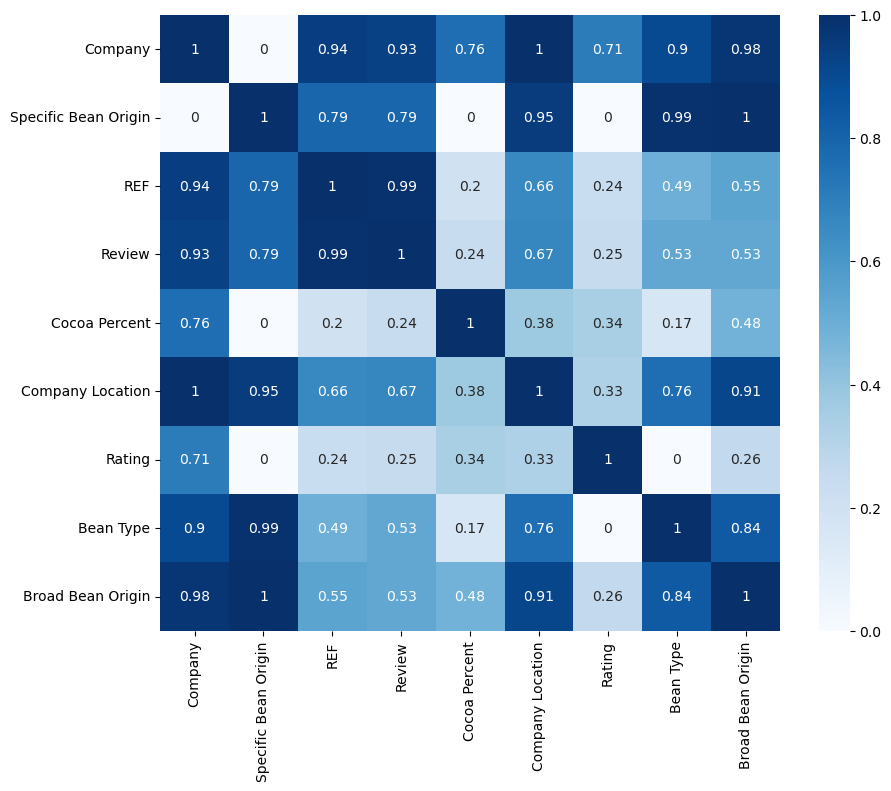

In [1443]:
plt.figure(figsize=(10, 8))
sns.heatmap(phik_overview, cmap='Blues', annot=True)

plt.show();

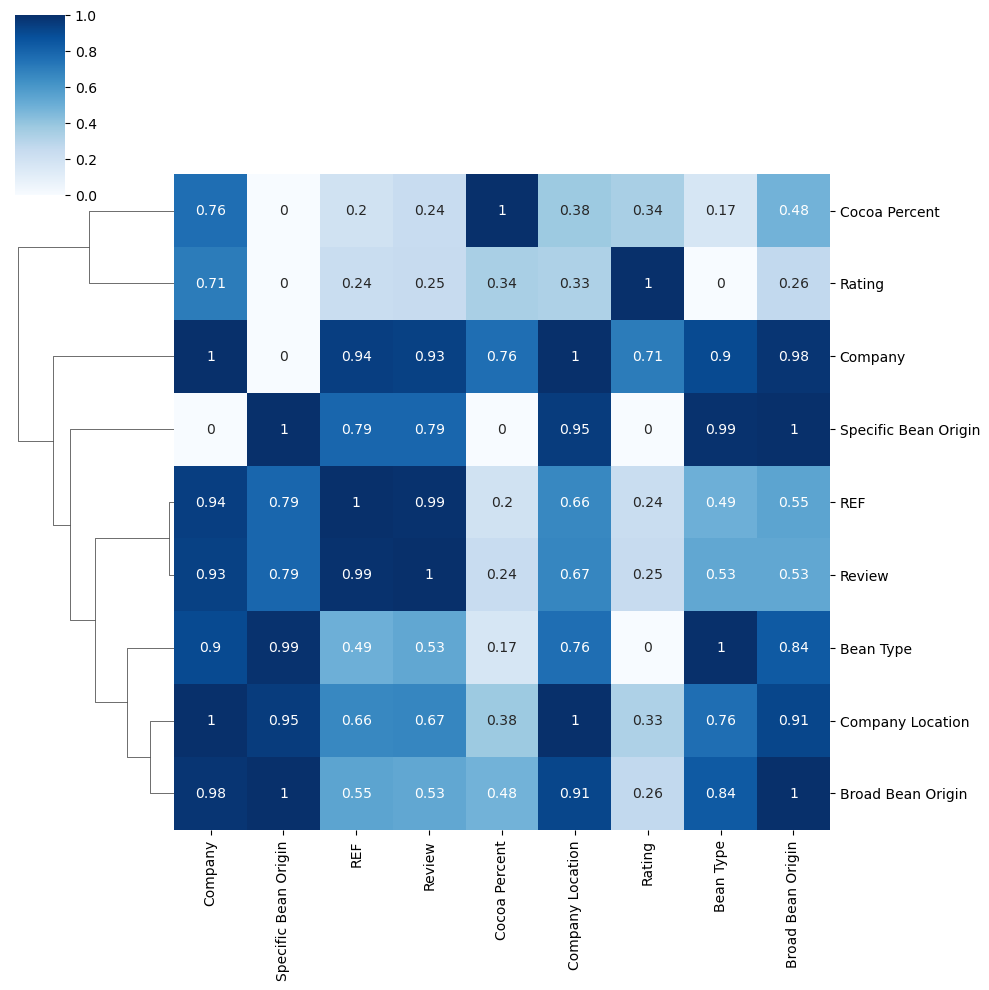

In [1444]:
sns.clustermap(phik_overview, cmap='Blues', annot=True, col_cluster=False)

plt.show();

In [1445]:
cols_temp = ['Company', 'Specific Bean Origin', 'Review', 'Cocoa Percent', 'Company Location', 'Rating', 'Bean Type', 'Broad Bean Origin']

In [1446]:
cramer_df = train[cols_temp]
cramer_df = cramer_df.astype('category')

cramer = CramersV(cramer_df)
cramer_overview = cramer.fit()

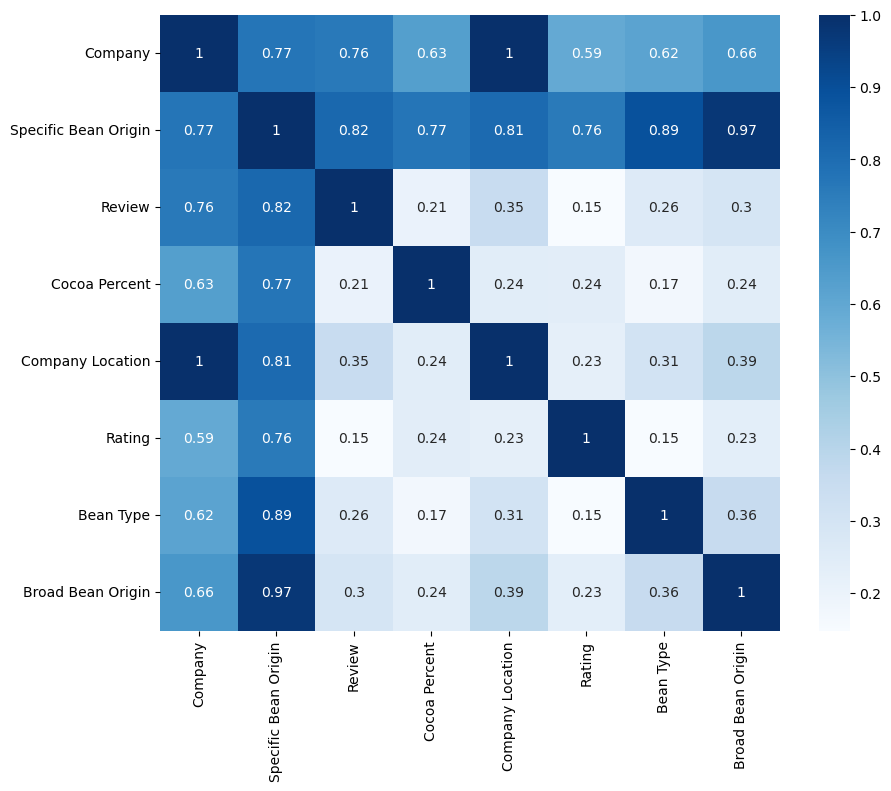

In [1447]:
plt.figure(figsize=(10, 8))
sns.heatmap(cramer_overview, cmap='Blues', annot=True)

plt.show();

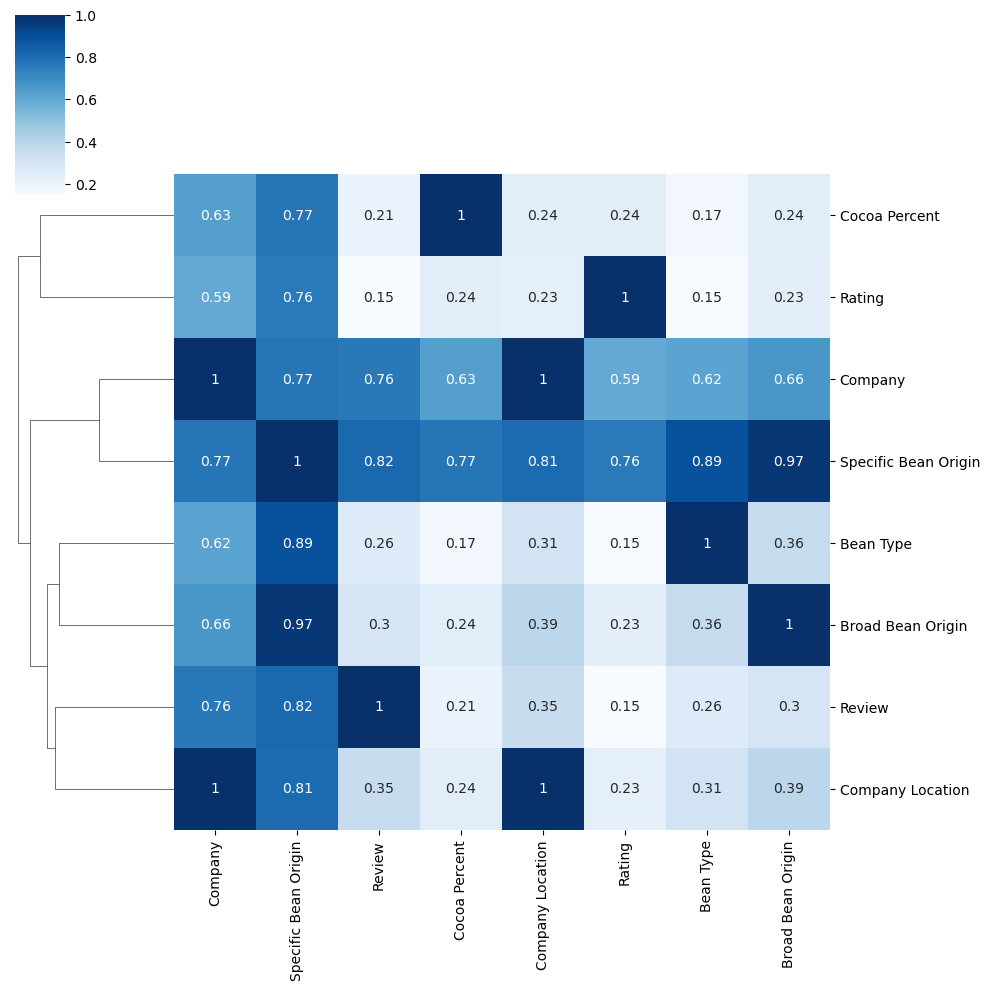

In [1448]:
sns.clustermap(cramer_overview, cmap='Blues', annot=True, col_cluster=False)

plt.show();

Визуально видно, что мультиколлинеарных наблюдается, возможно стоит удалить колонки 'Specific Bean Origin', 'REF'.

## Группировка значений признаков

In [1449]:
# df_concat['Bean Type'].sort_values().unique()
# df_concat['Broad Bean Origin'].sort_values().unique()

In [1450]:
# def mapping_groups(value, col_name):

#     groups_bean_type = {
#         'Amazonian': ['Amazon', 'Amazon Mix', 'Amazon, Ics'],
#         'Blend': ['Blend', 'Blend-Forastero,Criollo', 'Criollo, Forastero', 'Criollo, Trinitario', 
#                 'Forastero, Trinitario', 'Trinitario, Criollo', 'Trinitario, Forastero',
#                 'Trinitario, Nacional', 'Trinitario, Tcga'],
#         'Criollo': ['Criollo', 'Criollo (Amarru)', 'Criollo (Ocumare 61)', 'Criollo (Ocumare 67)',
#                     'Criollo (Ocumare 77)', 'Criollo (Ocumare)', 'Criollo (Porcelana)', 'Criollo (Wild)', 'Criollo, +'],
#         'Forastero': ['Forastero', 'Forastero (Amelonado)', 'Forastero (Arriba)', 'Forastero (Catongo)',
#                       'Forastero (Nacional)', 'Forastero (Parazinho)', 'Forastero(Arriba, Ccn)'],
#         'Nacional': ['Nacional', 'Nacional (Arriba)'],
#         'Trinitario': ['Trinitario', 'Trinitario (85% Criollo)', 'Trinitario (Amelonado)', 'Trinitario (Scavina)']
#     }

#     groups_bb_origin = {
#         'Caribbean': ['Carribean', 'Carribean(Dr/Jam/Tri)', 'Venezuela, Carribean', 'Africa, Carribean, C. Am.'],
#         'Costa Rica': ['Cost Rica, Ven', 'Costa Rica'],
#         'Dominican Republic': ['Dom. Rep., Madagascar', 'Domincan Republic', 'Dominican Rep., Bali', 'Dominican Republic'],
#         'Ecuador': ['Ecuador', 'Ecuador, Costa Rica', 'Ecuador, Mad., Png', 'Dr, Ecuador, Peru', 'Per/Ecuador, Venezuela', 'Colombia, Ecuador'],
#         'Ghana': ['Ghana', 'Ghana & Madagascar', 'Ghana, Panama, Ecuador'],
#         'Indonesia': ['Indonesia', 'Indonesia, Ghana'],
#         'Madagascar': ['Mad., Java, Png', 'Madagascar', 'Madagascar & Ecuador'],
#         'Papua New Guinea': ['Papua New Guinea', 'Gre., Png, Haw., Haiti, Mad', 'Png, Vanuatu, Mad'],
#         'Peru': ['Peru','Peru(Smartin,Pangoa,Nacional)','Peru, Belize','Peru, Dom. Rep', 'Peru, Ecuador',
#                  'Peru, Ecuador, Venezuela', 'Peru, Mad., Dom. Rep.', 'Guat., D.R., Peru, Mad., Png', 'Peru, Madagascar'],
#         'Sao Tome': ['Sao Tome', 'Sao Tome & Principe'],
#         'South America': [ 'Central And S. America', 'South America', 'South America, Africa'],
#         'Trinidad': ['Trinidad', 'Trinidad, Ecuador', 'Trinidad, Tobago',  'Venezuela, Trinidad', 'Tobago', 'Trinidad-Tobago'],
#         'Venezuela': ['Ven, Bolivia, D.R.', 'Ven, Trinidad, Ecuador', 'Ven., Indonesia, Ecuad.', 'Ven., Trinidad, Mad.',
#                       'Ven.,Ecu.,Peru,Nic.', 'Venez,Africa,Brasil,Peru,Mex', 'Venezuela', 'Venezuela, Carribean',
#                       'Venezuela, Dom. Rep.', 'Venezuela, Ghana', 'Venezuela, Java', 'Venezuela, Trinidad', 'Venezuela/ Ghana']
# }

#     col_dct = {
#        'Bean Type': groups_bean_type,
#        'Broad Bean Origin': groups_bb_origin
#     }

#     col = col_dct.get(col_name)

#     if col is None:
#         return value

#     for group, values in col.items():
#         if value in values:
#             return group
#     return value

In [1451]:
# def df_mapping_groups(df):
#     df = df.copy()
#     # for col_name in ['Company Location', 'Broad Bean Origin']:
#     for col_name in ['Broad Bean Origin']:
#         col_new = f'Group {col_name}'
#         df[col_new] = df[col_name].apply(mapping_groups, args=(col_name,))

#     return df

In [1452]:
# train = df_mapping_groups(train)
# test = df_mapping_groups(test)

In [1453]:
# def mapping_groups2(value, col_name):

#     groups_sb_origin = {'Venezuela': ['Venezuela', 'Venezuela, Trinidad', 'Venezuela, Batch 122'],
#                         'Tanzania': ['Tanzania'],
#                         'Cooproagro': ['Cooproagro'],
#                         'Java': ['Java, Indonesie',
#                         'Java',
#                         'Java, Grand Cru',
#                         'Java, Indonesian Black',
#                         'Java, Javablond'],
#                         'Chuno': ['Chuno',
#                         'Chuno, San Jose De Bocay, Pantasma R.,B.S.',
#                         'Chuno, Xoco',
#                         'Chuno, Double Turned, Xoco',
#                         'Chuno, Triple Turned, Xoco'],
#                         'Beniamo': ['Beniamo'],
#                         'Cuyagua': ['Cuyagua', 'Cuyagua, 2013'],
#                         'Lam Dong': ['Lam Dong, Batch 153', 'Lam Dong'],
#                         'Star Of Ecuador': ['Star Of Ecuador'],
#                         'Ecuador': ['Ecuador'],
#                         'Indigena Amazonia': ['Indigena Amazonia, Grand Cru, Quizas'],
#                         'Tumbes': ['Tumbes, Dear Mr. Finley, 2014',
#                         'Tumbes',
#                         'Tumbes, 2013 Harvest, Batch 8',
#                         'Tumbes, "Zarumilla"',
#                         'Tumbes, Batch 2',
#                         'Tumbes, Norandino'],
#                         'Madagascar': ['Madagascar'],
#                         'Coto Brus': ['Coto Brus, Heirloom, Batch 1',
#                         'Coto Brus',
#                         'Coto Brus, Terciopelo'],
#                         'Arriba': ['Arriba'],
#                         'Arhuacos': ['Arhuacos'],
#                         'Papua New Guinea': ['Papua New Guinea'],
#                         'Palos Blancos + Nibs': ['Palos Blancos + Nibs'],
#                         "Sisa'S Secret/ Original Micro": ["Sisa'S Secret/ Original Micro"],
#                         'Chiapas': ['Chiapas, Lacandon Jungle, Oaxacom Mtn',
#                         'Chiapas, Mokaya P.',
#                         'Chiapas, Lacandon Jungle',
#                         'Chiapas',
#                         'Chiapas, Triple Cacao'],
#                         'Africa Meets Latina': ['Africa Meets Latina'],
#                         'Hacienda Las Trincheras': ['Hacienda Las Trincheras'],
#                         'Apurimac': ['Apurimac, El Quinacho Co-Op', 'Apurimac'],
#                         'Trinite': ['Trinite'],
#                         'Congo': ['Congo, Grand Cru', 'Congo', 'Congo W/ Nibs', 'Congo, Gorilla Bar'],
#                         'Blend No.': ['Blend No. 1'],
#                         'Bahia': ['Bahia',
#                         'Bahia, Floresta Azul,Good Friends Reserve#3',
#                         'Bahia, Fazenda Venturosa',
#                         'Bahia, Batch 148',
#                         'Bahia, Scavina',
#                         'Bahia, Agri-Forestal Plantation, 2010',
#                         'Bahia, Batch A1213',
#                         'Bahia, Fazenda Camboa'],
#                         'Trintade': ['Trintade, Sao Tome'],
#                         'Peru': ['Peru'],
#                         'Guantupi River': ['Guantupi River'],
#                         'Esmeraldas': ['Esmeraldas', 'Esmeraldas, Salazar Farm'],
#                         'Bolivian': ['Bolivian'],
#                         'Hawaii': ['Hawaii'],
#                         'Ambanja': ['Ambanja, Sambirano Valley',
#                         'Ambanja, Batch 1 Srb',
#                         'Ambanja, Tsara Valley'],
#                         'Ba Ria Vung Tau Province': ['Ba Ria Vung Tau Province'],
#                         'El Oro': ['El Oro, Hacienda De Oro', 'El Oro'],
#                         'Png': ['Png, Devotion', 'Png, Nib Bar', 'Png, Voodoo', 'Png, Revolution'],
#                         'Amazonas': ['Amazonas', 'Amazonas W/ Nibs'],
#                         'Hispaniola': ['Hispaniola, Batch 170104',
#                         'Hispaniola',
#                         'Hispaniola, 2008',
#                         'Hispaniola, 2013',
#                         'Hispaniola W/ Nibs'],
#                         'Ben Tre': ['Ben Tre',
#                         'Ben Tre, Mekong Delta, Mocay',
#                         'Ben Tre, Dong Nai',
#                         'Ben Tre, Mekong Delta',
#                         'Ben Tre, Surprise Valley'],
#                         'Hacienda Victoria': ['Hacienda Victoria'],
#                         'Agua Fria; Sucre Region': ['Agua Fria; Sucre Region'],
#                         'Johe': ['Johe', 'Johe, Xoco'],
#                         'Tumaco': ['Tumaco'],
#                         'Los Llanos': ['Los Llanos'],
#                         'Trinidad': ['Trinidad'],
#                         'Ba Ria': ['Ba Ria'],
#                         'Bocas Del Toro': ['Bocas Del Toro, Tierra Oscura',
#                         'Bocas Del Toro',
#                         'Bocas Del Toro, Cocabo Co-Op'],
#                         'Patanemo': ['Patanemo', 'Patanemo, Epoch, Donaldo'],
#                         'Presidio': ['Presidio'],
#                         'Wild Thing': ['Wild Thing'],
#                         'Akosombo': ['Akosombo'],
#                         'Fazenda Sempre Firme': ['Fazenda Sempre Firme P., Bahia',
#                         'Fazenda Sempre Firme, Bahia'],
#                         'Choroni': ['Choroni', 'Choroni, Finca Torres, 48Hr C.'],
#                         'Mababa': ['Mababa'],
#                         'Latino': ['Latino'],
#                         'Jamaica': ['Jamaica'],
#                         'Costa Rica': ['Costa Rica'],
#                         'Dominican Republic': ['Dominican Republic'],
#                         'Mora Mora': ['Mora Mora 2006'],
#                         'Porcelana': ['Porcelana, Venezuela',
#                         'Porcelana',
#                         'Porcelana, Apotequil',
#                         'Porcelana, Tabasco, Finca La Joya',
#                         'Porcelana, Colombia, Amazonas',
#                         'Porcelana, Pedegral',
#                         'Porcelana, Batch 5163',
#                         'Porcelana, Premier Cru, Quizas No. 1',
#                         'Porcelana, Tabasco',
#                         'Porcelana, Tabasco, Mexico',
#                         'Porcelana, Pariguan',
#                         'Porcelana, Zulia',
#                         'Porcelana, Tabasco, Marfil De Blanco',
#                         'Porcelana, Tabasco, Limited Ed.',
#                         'Porcelana, Tabasco, La Joya'],
#                         'Fazenda Camboa': ['Fazenda Camboa, Bahia', 'Fazenda Camboa'],
#                         'La Tronca': ['La Tronca, Matagalpa'],
#                         'Quito': ['Quito'],
#                         'Pichincha': ['Pichincha'],
#                         'Equator': ['Equator'],
#                         'Sambirano Valley': ['Sambirano Valley',
#                         'Sambirano Valley, 2012',
#                         'Sambirano Valley, Batch 2477',
#                         'Sambirano Valley, #216, Mr, Lc',
#                         'Sambirano Valley, Black Science, B-60307.0',
#                         'Sambirano Valley, #214, Lr, Mc',
#                         'Sambirano Valley, #215, Mr, Mc',
#                         'Sambirano Valley, Le 100%'],
#                         'Fiji': ['Fiji'],
#                         'Satipo Pangoa Region': ['Satipo Pangoa Region, 16Hr Conche',
#                         'Satipo Pangoa Region, 20Hr Conche'],
#                         'Solomon Islands': ['Solomon Islands'],
#                         'Rio Tuma': ['Rio Tuma'],
#                         'Tien Giang': ['Tien Giang',
#                         'Tien Giang, Black S., Batch Vit60420.0',
#                         'Tien Giang, 2015, Batch 10-2-16',
#                         'Tien Giang, Gao Co-Op',
#                         'Tien Giang, Batch 1 Srb'],
#                         'Zorzal Reserva': ['Zorzal Reserva, 2015 H., Kerchner',
#                         'Zorzal Reserva',
#                         'Zorzal Reserva W/ Charles Kerchner'],
#                         'Liberia': ['Liberia, #174', 'Liberia'],
#                         'Goddess Blend': ['Goddess Blend'],
#                         'Blend': ['Blend'],
#                         'Il100': ['Il100, H. San Jose'],
#                         'Colombia': ['Colombia'],
#                         'Aranama': ['Aranama'],
#                         'Noir': ['Noir'],
#                         'Chanchamayo': ['Chanchamayo, Pichanadi, 2012, 60Hr C.'],
#                         'Rainforest': ['Rainforest'],
#                         'Acul-Du-Nord': ['Acul-Du-Nord, 2015'],
#                         'Winak': ['Winak, Sumaco'],
#                         'Sambirano': ['Sambirano',
#                         'Sambirano, Ampamakia 2005, Millot P.',
#                         'Sambirano 2006',
#                         'Sambirano, Ambanja',
#                         'Sambirano, Batch 170102',
#                         'Sambirano, Menava P.',
#                         'Sambirano, Akesson Estate',
#                         'Sambirano, Ambanja, Madagascar',
#                         'Sambirano, 2009',
#                         'Sambirano, 2008'],
#                         'Belize': ['Belize'],
#                         'Upala': ['Upala, Batch 18', 'Upala', 'Upala, Batch 12', 'Upala W/ Nibs'],
#                         'Hamakua': ['Hamakua, Hawaiian Crown, #176'],
#                         'Brazil': ['Brazil'],
#                         'Tumbes Coop': ['Tumbes Coop'],
#                         'Camino Verde': ['Camino Verde P., Balao, Guayas, 2014',
#                         'Camino Verde',
#                         'Camino Verde P., Balao, Guayas, 2013',
#                         'Camino Verde, Black S., Batch Cvu6030.0',
#                         'Camino Verde P., 2012, Balao, Guayas',
#                         'Camino Verde P., Balao, Guayas',
#                         'Camino Verde P., Balao, Guayas, "Fruity"',
#                         'Camino Verde P., Balao, Guayas, "Floral"',
#                         'Camino Verde, Guayas',
#                         'Camino Verde P., Balao, Guayas, 2012',
#                         'Camino Verde, Balao, Guayas',
#                         'Camino Verde P., Balao, 2015 Harvest, Batch8'],
#                         'Cusco': ['Cusco, Cacao Cusco', 'Cusco'],
#                         'Bolivia': ['Bolivia', 'Bolivia, Bo-Nib-Ia, W/ Nibs', 'Bolivia, Wild Thing'],
#                         'Blue Mountain Region': ['Blue Mountain Region'],
#                         'Maleku': ['Maleku'],
#                         'Philly Blend': ['Philly Blend, 5 Plantations'],
#                         'Quilla': ['Quilla'],
#                         'Alto Beni': ['Alto Beni',
#                         'Alto Beni, Upper Rio Beni, 2014',
#                         'Alto Beni, Wild Harvest, Limited Ed.',
#                         'Alto Beni, Wild Bolivian',
#                         'Alto Beni, Cru Savage',
#                         'Alto Beni, Palos Blancos',
#                         'Alto Beni, Wild Harvest, Itenez R. 24Hr C.',
#                         'Alto Beni, Palos Blanco',
#                         'Alto Beni, Covendo Region',
#                         'Alto Beni, Wild Harvest, Itenez R., 60Hr C.',
#                         'Alto Beni, Upper Rio Beni, 2015'],
#                         'Gran Couva': ['Gran Couva', 'Gran Couva 2005 P.'],
#                         'Excellence (Us Version)': ['Excellence (Us Version)'],
#                         'Maya Mountain': ['Maya Mountain, Toledo, Batch 29',
#                         'Maya Mountain',
#                         'Maya Mountain W/ Nibs'],
#                         'Vanuatu': ['Vanuatu'],
#                         'Las Acacias': ['Las Acacias E.'],
#                         'Chucuri': ['Chucuri'],
#                         'Ghana': ['Ghana'],
#                         'Cacao Blanco': ['Cacao Blanco'],
#                         'Papua Kerafat': ['Papua Kerafat'],
#                         'Manabi': ['Manabi'],
#                         'El Salvador': ['El Salvador'],
#                         'Lago Di Como': ['Lago Di Como, Blu'],
#                         'Rizek Cacao': ['Rizek Cacao, Domin. Rep.',
#                         'Rizek Cacao, Cibao Valley, Domin. Rep.'],
#                         'Kilombero': ['Kilombero, Batch 41'],
#                         'Conacado': ['Conacado, Manifesto',
#                         'Conacado',
#                         'Conacado, #223, Mr, Sc',
#                         'Conacado, 2012, 120Hr C.',
#                         'Conacado, #212, Lr, Sc',
#                         'Conacado, #224, Mr, Mc',
#                         'Conacado, #213, Dr, -C'],
#                         'Red Mayan': ['Red Mayan, Xoco'],
#                         'La Dalia': ['La Dalia',
#                         'La Dalia, Matagalpa,Cacao Bisesto,Green Label',
#                         'La Dalia, Matagalpa'],
#                         'Tchopro': ['Tchopro 68', 'Tchopro 60.5'],
#                         'San Martin': ['San Martin',
#                         'San Martin, Batch 2',
#                         'San Martin, Bellavista Coop, #226, Dr, Mc',
#                         'San Martin, Amazonian Highlands'],
#                         'Ham Luong': ['Ham Luong'],
#                         'Perla Negra': ['Perla Negra'],
#                         'Kakao Kamili': ['Kakao Kamili, Kilombero Valley'],
#                         'Honduras': ['Honduras'],
#                         'Island Growers': ['Island Growers, 96Hr C.',
#                         'Island Growers, 120Hr C.',
#                         'Island Growers, 2012, 120Hr C.'],
#                         'Carribean-Raw': ['Carribean-Raw'],
#                         'La Bahia': ['La Bahia, W/ Cane Juice', 'La Bahia, W/ Cane Sugar'],
#                         'Somia Plantation': ['Somia Plantation, Akesson, 2012',
#                         'Somia Plantation, 2012',
#                         'Somia Plantation',
#                         'Somia Plantation, Sambirano, 70Hr C'],
#                         'Dark': ['Dark', 'Dark 67', 'Dark 75', 'Dark, Stone Ground'],
#                         'Finisterra': ['Finisterra'],
#                         'Cuana': ['Cuana, 2008', 'Cuana, 2013'],
#                         'Akessons Estate': ['Akessons Estate, Sambirano, Ambanja',
#                         'Akessons Estate, Sambirano, 2013'],
#                         'Sur Del Lago': ['Sur Del Lago',
#                         'Sur Del Lago, Merida',
#                         'Sur Del Lago, Amiari Meridena, Zulia, W/ Nibs',
#                         'Sur Del Lago, Amiari Meridena, Zulia, 48Hr C.'],
#                         'Pepiniere': ['Pepiniere, Single Cote'],
#                         'West Africa': ['West Africa'],
#                         "Akesson'S": ["Akesson'S E., Sambirano V.", "Akesson'S, Batch 4411"],
#                         'Grenada': ['Grenada', 'Grenada, Black Science'],
#                         'Diego': ['Diego 48Hr/ W.F. Blend Prototype',
#                         'Diego 60Hr/ W.F. Blend Prototype'],
#                         'Andoa': ['Andoa, Grand Cru Blend'],
#                         'Xoconusco': ['Xoconusco', 'Xoconusco, Cacao Real', 'Xoconusco, Chiapas'],
#                         'Claudio Corallo': ['Claudio Corallo W/ Nibs'],
#                         'Kokoa Kamili': ['Kokoa Kamili', 'Kokoa Kamili, Batch 1 Srb'],
#                         'Nicaragua': ['Nicaragua'],
#                         'Semisweet': ['Semisweet'],
#                         'Virunga': ['Virunga'],
#                         'Wild Beniano': ['Wild Beniano, 2016, Batch 128, Heirloom'],
#                         'French Laundry': ['French Laundry 20Th Anniversary'],
#                         'Unocace': ['Unocace'],
#                         'El Carmen': ['El Carmen, Batch 1003'],
#                         'Elvesia': ['Elvesia',
#                         'Elvesia P., Black Science',
#                         'Elvesia, 2011',
#                         'Elvesia P., Batch 32',
#                         'Elvesia P.'],
#                         'Ayacucho': ['Ayacucho, "El Guinacho"'],
#                         'Toledo District': ['Toledo District, W/ Nibs',
#                         'Toledo District, 2015 Harvest',
#                         'Toledo District',
#                         'Toledo District, Maya'],
#                         'San Jose': ['San Jose'],
#                         'Tan Phu Dong': ['Tan Phu Dong, Treasure Island'],
#                         'Grand Cru Ecuador': ['Grand Cru Ecuador'],
#                         'Venezuela; Barinos': ['Venezuela; Barinos, Merida, Tachron'],
#                         'Granella': ['Granella'],
#                         'Sierra Nevada': ['Sierra Nevada', 'Sierra Nevada, Tutu Iku'],
#                         'Principe': ['Principe'],
#                         'Caranero': ['Caranero, Choc. Garage Exclusive'],
#                         'Papua': ['Papua'],
#                         'Baracoa': ['Baracoa', 'Baracoa, Cuba'],
#                         'Mantuano': ['Mantuano', 'Mantuano, 2012'],
#                         'Los Rios': ['Los Rios', 'Los Rios, Hacienda Limon, Orecao, 2014'],
#                         'Cacao Nib Crunch': ['Cacao Nib Crunch'],
#                         'Gran Blanco': ['Gran Blanco'],
#                         'Wild Bolivian': ['Wild Bolivian, Jungle Love',
#                         'Wild Bolivian',
#                         'Wild Bolivian, Batch 2'],
#                         'Lever Du Soleil': ['Lever Du Soleil'],
#                         'Los Ancones': ['Los Ancones P.'],
#                         'Maralumi': ['Maralumi P.'],
#                         'Nutty-Beta': ['Nutty-Beta'],
#                         'Caracas': ['Caracas, Venezuela And Ghana'],
#                         'Equateur': ['Equateur'],
#                         'Red Vanilla': ['Red Vanilla'],
#                         'Roig': ['Roig', 'Roig, 2014'],
#                         'Asante': ['Asante'],
#                         'Concepcion': ['Concepcion'],
#                         'Sao Tome': ['Sao Tome'],
#                         'Coucher Du Soleil': ['Coucher Du Soleil'],
#                         'Tabasco': ['Tabasco'],
#                         'Goodman Estate': ['Goodman Estate'],
#                         'Carre Amer': ['Carre Amer'],
#                         'Palo Blanco': ['Palo Blanco, Chulucanas',
#                         'Palo Blanco W/ Panela, Chulucanas'],
#                         'San Juan Estate': ['San Juan Estate, Cherry Blossoms At Night',
#                         'San Juan Estate, Gran Couva',
#                         'San Juan Estate'],
#                         'Selva Maya': ['Selva Maya'],
#                         'Perfect Illusion': ['Perfect Illusion'],
#                         'Crazy': ['Crazy 88'],
#                         'Ceylan': ['Ceylan'],
#                         'Serian': ['Serian E., Nw Borneo, B. #134/3800'],
#                         'Misterio': ['Misterio'],
#                         'Guaniamo': ['Guaniamo, Amazonas', 'Guaniamo'],
#                         'Grand Cru Ghana': ['Grand Cru Ghana'],
#                         'Puerto Rico': ['Puerto Rico'],
#                         'Wampusirpi Region': ['Wampusirpi Region'],
#                         'Campesino': ['Campesino W/ Nibs'],
#                         'Tan Phu Dong Island': ['Tan Phu Dong Island, Heart Of Darkness'],
#                         'Tenende': ['Tenende, Uwate'],
#                         'San Jose Del Tambo': ['San Jose Del Tambo'],
#                         'India': ['India'],
#                         'Matina': ['Matina 1-6, Prototype'],
#                         'Guadalcanal': ['Guadalcanal'],
#                         'Marcial': ['Marcial, Single Cote, 2012'],
#                         'Puerto Cabello': ['Puerto Cabello', 'Puerto Cabello, Mantuano'],
#                         'Villa Andina': ['Villa Andina'],
#                         'Toscano Black': ['Toscano Black'],
#                         'Antigua': ['Antigua, Special Reserve'],
#                         'Vietnam': ['Vietnam, Batch 50/100', 'Vietnam'],
#                         'Le Noir Extra Amer': ['Le Noir Extra Amer'],
#                         'Otucan': ['Otucan, Grand Cru'],
#                         'Lachua': ["Lachua, Q'Egchi Families",
#                         'Lachua W/ Maple Sugar, Batch 5',
#                         'Lachua',
#                         'Lachua W/ Cane Sugar'],
#                         'Nicaliso': ['Nicaliso, Xoco'],
#                         'Tome Acu': ['Tome Acu', 'Tome Acu E., Amazon Rainforest'],
#                         'Millot Plantation': ['Millot Plantation'],
#                         'Criollo': ['Criollo, Dominican Republic', 'Criollo, Hawaii'],
#                         'Bahia Black': ['Bahia Black, Batch Bra50722.1'],
#                         'Matasawalevu': ['Matasawalevu'],
#                         'Orinoco': ['Orinoco'],
#                         'Bahia Brazil': ['Bahia Brazil, Fazenda Sao Pedro'],
#                         'Dong Nai': ['Dong Nai'],
#                         'Panama': ['Panama'],
#                         'Matagalpa': ['Matagalpa', 'Matagalpa, Cacao Bisiesto'],
#                         'Emerald Estate': ['Emerald Estate'],
#                         'Autumn': ['Autumn, Primary Harvest, 2012'],
#                         'Downtown London': ['Downtown London'],
#                         'Non Pariel Estate': ['Non Pariel Estate'],
#                         'Akesson Estate': ['Akesson Estate'],
#                         'Bolivar': ['Bolivar, Guaranda', 'Bolivar, Arriba', 'Bolivar'],
#                         'Rugoso': ['Rugoso', 'Rugoso, Bad Fermentation', 'Rugoso, Xoco'],
#                         'Abstract S.': ['Abstract S. W/ Jamaica Nibs,Batch Abs60323.0'],
#                         'Ilblend': ['Ilblend'],
#                         'Trinitario': ['Trinitario'],
#                         'Kulili Estate': ['Kulili Estate'],
#                         'Namau Village': ['Namau Village',
#                         'Namau Village, N. Taileva P., Batch A2812'],
#                         'Rio Eni': ['Rio Eni'],
#                         'Trincheras': ['Trincheras'],
#                         'Terreiro Velho': ['Terreiro Velho P.',
#                         'Terreiro Velho P. W/ Sugar Crystals'],
#                         'Mombacho': ['Mombacho'],
#                         'Houseblend': ['Houseblend'],
#                         'Vinces': ['Vinces'],
#                         'Markham Valley': ['Markham Valley, #221, Dr, Mc',
#                         'Markham Valley',
#                         'Markham Valley, #220, Mr, Mc',
#                         'Markham Valley, #222, Lr, 0C',
#                         'Markham Valley, #219, Lr, Mc'],
#                         'Puerto Plata': ['Puerto Plata'],
#                         'Alta Verapaz': ['Alta Verapaz, 2014'],
#                         'Cuba': ['Cuba'],
#                         'Sang Yum Coop': ['Sang Yum Coop'],
#                         'Mahali': ['Mahali, Kasai'],
#                         'Classic': ['Classic'],
#                         'Capistrano': ['Capistrano'],
#                         'Nourish': ['Nourish'],
#                         'Napa': ['Napa'],
#                         'Catongo': ['Catongo'],
#                         'Cordoba': ['Cordoba'],
#                         'Haiti': ['Haiti'],
#                         'San Joaquin': ['San Joaquin'],
#                         'Fruity-Beta': ['Fruity-Beta'],
#                         'Montubia': ['Montubia'],
#                         'Guatemala': ['Guatemala'],
#                         'Talamanca': ['Talamanca, Raul-Kekoldo Community'],
#                         'Kuruba': ['Kuruba'],
#                         'Monte Alegre': ['Monte Alegre, D. Badero', 'Monte Alegre, Diego Badero'],
#                         'Selva': ['Selva'],
#                         'Mangaro': ['Mangaro P.'],
#                         'Mekong Delta & Dong Nai': ['Mekong Delta & Dong Nai'],
#                         'Satipo Region': ['Satipo Region, White Label'],
#                         'Lanquin Estate': ['Lanquin Estate'],
#                         'Cacao Nacional W.F.': ['Cacao Nacional W.F.'],
#                         'Pisa': ['Pisa'],
#                         'Le Noir Amer': ['Le Noir Amer'],
#                         'Indianer': ['Indianer, Raw'],
#                         'Madagared': ['Madagared'],
#                         'Chiapan': ['Chiapan'],
#                         'Conacado Coop': ['Conacado Coop'],
#                         'La Selva': ['La Selva'],
#                         'Chimelb': ['Chimelb, Lanquin, Alta Verapaz, B-Gua001'],
#                         'Raw': ['Raw'],
#                         'Maya Mtn': ['Maya Mtn, Moho R., Toledo D., 2015',
#                         'Maya Mtn, Moho R., Toledo D.',
#                         'Maya Mtn, Batch 454, Heirloom',
#                         'Maya Mtn',
#                         'Maya Mtn, Batch 18, Heirloom'],
#                         'Tsaranta': ['Tsaranta'],
#                         'Bali': ['Bali, Sukrama Bros. Farm, Melaya, 62Hr C',
#                         'Bali',
#                         'Bali, Jembrana',
#                         'Bali, Singaraja'],
#                         'Carribean': ['Carribean'],
#                         'Hamakua Coast': ['Hamakua Coast, Kokoleka'],
#                         'Nicalizo': ['Nicalizo'],
#                         'Gruppo Salinas': ['Gruppo Salinas'],
#                         'Manhattan': ['Manhattan'],
#                         'One Hundred': ['One Hundred'],
#                         'Corona Arriba': ['Corona Arriba'],
#                         'Kaori': ['Kaori'],
#                         'Tobago': ['Tobago'],
#                         'Akesson': ['Akesson P.'],
#                         'Trinatario Treasure': ['Trinatario Treasure'],
#                         'Crudo': ['Crudo'],
#                         'Gabon': ['Gabon'],
#                         'Ivory Coast': ['Ivory Coast', 'Ivory Coast, Batch 56/100'],
#                         'Guayas': ['Guayas'],
#                         'Star Of Peru': ['Star Of Peru'],
#                         'Sur Del Lago Classificado': ['Sur Del Lago Classificado'],
#                         'San Andres': ['San Andres, Silk',
#                         'San Andres',
#                         'San Andres, American Style'],
#                         'Caribe': ['Caribe'],
#                         'Duo- Gran Couva & Camino Verde': ['Duo- Gran Couva & Camino Verde'],
#                         'Kpime': ['Kpime'],
#                         'House Blend': ['House Blend, Batch 2'],
#                         'Momotombo': ['Momotombo'],
#                         'Costa Esmeraldas': ['Costa Esmeraldas'],
#                         'Davao': ['Davao', 'Davao, Mt. Talamo Foothills'],
#                         'Sangre Grande': ['Sangre Grande P., Trinidad'],
#                         'Asochivite': ['Asochivite, Batch 1005'],
#                         'Somia': ['Somia, 2013'],
#                         'Bundibugyo District': ['Bundibugyo District'],
#                         "Akesson'S Estate": ["Akesson'S Estate"],
#                         'Tres Hombres': ['Tres Hombres'],
#                         'Africa': ['Africa'],
#                         'Midnight': ['Midnight'],
#                         "Bachelor'S Hall": ["Bachelor'S Hall E., St. Thomas Parish"],
#                         'Macuare; Miranda; Chloe Formula': ['Macuare; Miranda; Chloe Formula'],
#                         'Nativo': ['Nativo, Varzea'],
#                         'Quetzalcoatl': ['Quetzalcoatl'],
#                         'Medagla': ['Medagla, Xoco'],
#                         'Capistrano*': ['Capistrano*'],
#                         'Special Maker Reserve': ['Special Maker Reserve'],
#                         'Twilight': ['Twilight'],
#                         'Las Islas': ['Las Islas'],
#                         '"Heirloom"': ['"Heirloom", Arriba Nacional'],
#                         'Dominican': ['Dominican'],
#                         'Asajaya E': ['Asajaya E, Nw Borneo, B. #132/4500'],
#                         'Single Estate': ['Single Estate'],
#                         'Citrus-Beta': ['Citrus-Beta'],
#                         'Los Ujuxtes': ['Los Ujuxtes'],
#                         'Ba Lai': ['Ba Lai'],
#                         'Malekula': ['Malekula P., 2013'],
#                         'South America And Africa': ['South America And Africa'],
#                         'Samar': ['Samar, East Visayas Region'],
#                         'Uganda': ['Uganda'],
#                         'Nigeria': ['Nigeria'],
#                         'Palos Blancos': ['Palos Blancos'],
#                         'Dual Origins': ['Dual Origins, Sambirano, Elvesia'],
#                         'El Ceibo Coop': ['El Ceibo Coop'],
#                         'Umoho R.': ['Umoho R., Toledo District, San Felipe'],
#                         'Winak Coop': ['Winak Coop, Napo'],
#                         'Oro': ['Oro'],
#                         'Moho River': ['Moho River'],
#                         'Mexico': ['Mexico'],
#                         'Kendari': ['Kendari'],
#                         'Noir Infini': ['Noir Infini'],
#                         'Silvestre': ['Silvestre, Batch 1, 2011',
#                         'Silvestre, Batch 7, 2013',
#                         'Silvestre, La Paz, Beni'],
#                         'Guyave': ['Guyave'],
#                         'Suchitepequez': ['Suchitepequez E.'],
#                         'Samana': ['Samana'],
#                         'Huila': ['Huila'],
#                         'Santo Domingo': ['Santo Domingo'],
#                         'Vale Do Juliana': ['Vale Do Juliana, W/ Nibs',
#                         'Vale Do Juliana E., Atlantic Forest'],
#                         'Sri Lanka': ['Sri Lanka'],
#                         '100 Percent': ['100 Percent'],
#                         'Eastern Promises': ['Eastern Promises'],
#                         'Patanemo Vil.': ['Patanemo Vil., Carabobo State, Tisano Family'],
#                         'Machu Pichu': ['Machu Pichu'],
#                         'Agua Grande': ['Agua Grande'],
#                         'Moho Valley': ['Moho Valley'],
#                         'Nyangbo': ['Nyangbo'],
#                         'Mara': ['Mara'],
#                         'Acarigua': ['Acarigua, W/ Nibs'],
#                         'Tranquilidad': ['Tranquilidad, Batch 1', 'Tranquilidad, Baures'],
#                         'Garaua': ['Garaua'],
#                         'Roxborough': ['Roxborough, Tobago'],
#                         'Chanchamayo Province': ['Chanchamayo Province'],
#                         'Marabel Farms': ['Marabel Farms'],
#                         'Tainori': ['Tainori'],
#                         'Complexite': ['Complexite'],
#                         'Oscuro': ['Oscuro', 'Oscuro, Finca Chimelb'],
#                         'Daintree Estates': ['Daintree Estates, N. Queensland'],
#                         'Don Homero- Cerecita Valley': ['Don Homero- Cerecita Valley'],
#                         'Mid Mountain': ['Mid Mountain, 2014'],
#                         'Shake Shack': ['Shake Shack'],
#                         'Amazonia': ['Amazonia'],
#                         'Guanaja': ['Guanaja'],
#                         'A Case Of The Xerces Blues': ['A Case Of The Xerces Blues, Triple Roast'],
#                         'Cabosse': ['Cabosse'],
#                         'Bellavista Coop': ['Bellavista Coop, #225, Lr, Mc, Cg Exclusive'],
#                         'Blue Mountain': ['Blue Mountain'],
#                         'Baking': ['Baking'],
#                         'Barinas': ['Barinas'],
#                         'Arauca': ['Arauca'],
#                         'Juliana': ['Juliana'],
#                         'Millot': ['Millot P., Ambanja'],
#                         'Bundibugyo': ['Bundibugyo'],
#                         'Dak Lak': ['Dak Lak, Batch 2451'],
#                         'Hacienda La Trinidad': ['Hacienda La Trinidad'],
#                         'La Amistad': ['La Amistad'],
#                         'San Juan De Cheni': ['San Juan De Cheni'],
#                         'Black Label': ['Black Label'],
#                         'Matiguas': ['Matiguas'],
#                         'Cortes': ['Cortes'],
#                         'Djakarta': ['Djakarta, Java And Ghana'],
#                         'Akata': ['Akata'],
#                         'Tawau': ['Tawau, Oct. 2015 Harvest'],
#                         'Paramaribo': ['Paramaribo, Batch 20160043-01'],
#                         'Makwale Village': ['Makwale Village, Kyela'],
#                         'Espiritu Santo': ["Espiritu Santo, 'Smoke Monster'"],
#                         'San Juan': ['San Juan'],
#                         'Little Big Man': ['Little Big Man'],
#                         'Surfin': ['Surfin'],
#                         'Kerala State': ['Kerala State'],
#                         'Aragua': ['Aragua, Trincheras'],
#                         'Buto': ['Buto'],
#                         'La Masica': ['La Masica, Batch 1, Fhia Research Center',
#                         'La Masica, Fhia',
#                         'La Masica, Batch 7, Fhia'],
#                         'Cahabon Region': ['Cahabon Region'],
#                         'Tarakan': ['Tarakan'],
#                         'Black Science Blend': ['Black Science Blend 1'],
#                         'Three Amigos(Chuao': ['Three Amigos(Chuao, Wild Bolivia, D.R.)'],
#                         'Tingo Maria': ['Tingo Maria'],
#                         'Mekong Delta': ['Mekong Delta, Early 2014 Harvest'],
#                         '2009 Hapa Nibby': ['2009 Hapa Nibby'],
#                         'Coopertiva Amazona': ['Coopertiva Amazona', 'Coopertiva Amazona W/ Nibs'],
#                         'Diego/ Original Micro': ['Diego/ Original Micro'],
#                         'Kendem Lembu': ['Kendem Lembu, Java'],
#                         'Indio Rojo': ['Indio Rojo, Xoco'],
#                         'Uba Budo': ['Uba Budo'],
#                         'Nibby': ['Nibby'],
#                         'Carre Grand Noir': ['Carre Grand Noir'],
#                         'Loma Los Pinos': ['Loma Los Pinos, Yacao Region, D.R.'],
#                         'Nature': ['Nature'],
#                         'The Lost City': ['The Lost City, Gracias A Dias, Batch 362'],
#                         'Sensations Intense': ['Sensations Intense'],
#                         'Bambamarca': ['Bambamarca, 2015'],
#                         'Norandino': ['Norandino, Batch 161208'],
#                         'Tokiala': ['Tokiala'],
#                         'Purple Haze': ['Purple Haze'],
#                         'Loma Sotavento': ['Loma Sotavento, 2013', 'Loma Sotavento'],
#                         'Noula Coop': ['Noula Coop'],
#                         'Mindo': ['Mindo'],
#                         'Criollo Blend': ['Criollo Blend'],
#                         'Nube- Prototype': ['Nube- Prototype'],
#                         'Rio Arriba': ['Rio Arriba'],
#                         'Bali (West)': ['Bali (West), Sukrama Family, Melaya Area'],
#                         'Gru Grococo': ['Gru Grococo, St. Andrews'],
#                         'Le Chocolat Chaud': ['Le Chocolat Chaud'],
#                         'Kilombero Valley': ['Kilombero Valley'],
#                         'Cumboto': ['Cumboto, Farmer Jose Lugo'],
#                         'Macondo': ['Macondo'],
#                         'Vila Gracinda': ['Vila Gracinda'],
#                         'Kokoa Kamili Coop': ['Kokoa Kamili Coop', 'Kokoa Kamili Coop, Kilombero'],
#                         'Epique': ['Epique, Blend No. 49'],
#                         'Caraibe': ['Caraibe'],
#                         'Rio Peripa': ['Rio Peripa H.'],
#                         'Waiahole': ["Waiahole, O'Ahu"],
#                         'Grand Cru Dominican Republic': ['Grand Cru Dominican Republic'],
#                         'Dos Rios': ['Dos Rios'],
#                         'Lamasdelchanka': ['Lamasdelchanka, San Martin, Oro Verde Coop'],
#                         'Chulucanas': ['Chulucanas, Batch 1', 'Chulucanas, El Platanal'],
#                         'Phantom': ['Phantom'],
#                         'Fortissima': ['Fortissima'],
#                         'South America': ['South America'],
#                         'Signature Blend': ['Signature Blend'],
#                         'Los Colorados': ['Los Colorados, Santo Domingo, Equateur'],
#                         'Moho River Valley': ['Moho River Valley'],
#                         'Wasatch': ['Wasatch'],
#                         'Guapiles': ['Guapiles'],
#                         'Huiwani Coop': ['Huiwani Coop'],
#                         'Araguani': ['Araguani'],
#                         'Nacional': ['Nacional'],
#                         'Organic Dark': ['Organic Dark'],
#                         'Duo': ['Duo, Batch 002'],
#                         'Robson Estate': ['Robson Estate'],
#                         'Grand Cru Blend No.1': ['Grand Cru Blend No.1, 5 Yr. Anniversary Ed'],
#                         'Abinao': ['Abinao'],
#                         'Peru- Ecuador': ['Peru- Ecuador'],
#                         'Manickchand Estate': ['Manickchand Estate'],
#                         'Kulili': ['Kulili P., 2013'],
#                         'Wild Beni': ['Wild Beni, Lower Rio Beni, Tranquilidad, 2015',
#                         'Wild Beni, Lower Rio Beni, Tranquilidad, 2014'],
#                         "Kaua'I": ["Kaua'I", "Kaua'I, Alea Estate +World"],
#                         'Cuyagua Village': ['Cuyagua Village'],
#                         'Camahogne': ['Camahogne'],
#                         'Chocoan Rainforest': ['Chocoan Rainforest, Teroro Escondido, Esm'],
#                         'Lacri Blend': ['Lacri Blend'],
#                         'Sisa': ['Sisa 36Hr/ W. F. Blend Prototype'],
#                         'Xocunusco': ['Xocunusco, Chiapas, Pichucalco'],
#                         'Cota Brus': ['Cota Brus, Terciopelo, 2015'],
#                         'Guadeloupe': ['Guadeloupe'],
#                         'Onyx': ['Onyx'],
#                         'Maya Belize': ['Maya Belize'],
#                         'Manjari': ['Manjari'],
#                         'Espada': ['Espada'],
#                         'Duarte Province': ['Duarte Province'],
#                         'Wampusirpi': ['Wampusirpi, Batch 007'],
#                         "Chef'S Blend": ["Chef'S Blend"],
#                         'Punta Galera': ['Punta Galera, Cacao Nacional, Gold Label'],
#                         'Australia': ['Australia'],
#                         'Fleur De Cacao': ['Fleur De Cacao'],
#                         'Agrocriso Plantation': ['Agrocriso Plantation'],
#                         'Barba': ['Barba, Xoco'],
#                         'Tenor': ['Tenor'],
#                         'Selvagem': ['Selvagem, Jari'],
#                         'Crayfish Bay Estate': ['Crayfish Bay Estate, 2014'],
#                         'St. Lucia': ['St. Lucia'],
#                         'Balinese': ['Balinese, Java'],
#                         'Ankasa': ['Ankasa'],
#                         'Cahabon': ['Cahabon'],
#                         'Kongo': ['Kongo, Highlands'],
#                         'Tapanti': ['Tapanti, Light Roast'],
#                         'Antilles (Trin/Gren/Dr/Ven)': ['Antilles (Trin/Gren/Dr/Ven)'],
#                         'Amina': ['Amina'],
#                         'Wild Bolivia': ['Wild Bolivia'],
#                         'Malekula Island': ['Malekula Island'],
#                         'Indonesia': ['Indonesia'],
#                         'Piaroa': ['Piaroa, Amazonas, Batch 350'],
#                         'Maragda': ['Maragda'],
#                         "Grand 'Anse": ["Grand 'Anse"],
#                         'Csb Chama': ['Csb Chama'],
#                         'Birmanie': ['Birmanie'],
#                         'Jutiapa': ['Jutiapa, Lot 050916D'],
#                         'Alpaco': ['Alpaco'],
#                         'Fazenda Leolinda': ['Fazenda Leolinda'],
#                         'Kakoa Kamili': ['Kakoa Kamili, Both Man & Bird & Beast'],
#                         'New Ireland': ['New Ireland'],
#                         'Taino Secret': ['Taino Secret'],
#                         'Djual Island': ['Djual Island'],
#                         'Ciaab Coop': ['Ciaab Coop'],
#                         'Santander': ['Santander'],
#                         'Rico Rugoso': ['Rico Rugoso, Xoco'],
#                         'La Patriota': ['La Patriota, Cacao Indio, Purple Label'],
#                         'Rio Dulce': ['Rio Dulce, Xoco'],
#                         'Brooklyn Blend': ['Brooklyn Blend'],
#                         'La Dorado': ['La Dorado, Light Roast'],
#                         'Saidor Estate': ['Saidor Estate, Madang P.'],
#                         'Abocfa Coop': ['Abocfa Coop'],
#                         'Chocolatey-Beta': ['Chocolatey-Beta'],
#                         'D.R. Congo': ['D.R. Congo, Cru Virunga'],
#                         'Libanio': ['Libanio'],
#                         'Nocturne': ['Nocturne'],
#                         'Sylvestre': ['Sylvestre, Oialla'],
#                         'Spring': ['Spring, Secondary Harvest, 2012'],
#                         'Boyaca': ['Boyaca, Aprocampa Coop, Pauna'],
#                         'Moxos': ['Moxos'],
#                         'Bellavista Gran Pajeten': ['Bellavista Gran Pajeten, San Martin'],
#                         'Roberto': ['Roberto'],
#                         'Uranga': ['Uranga, Lot 22032016'],
#                         'Dancing In Your Head': ['Dancing In Your Head, 5 Bean Blend'],
#                         'Pinchincha': ['Pinchincha, Mindo, Coop Nueva Esper., 2015'],
#                         'Bahia Superior': ['Bahia Superior'],
#                         'Nine': ['Nine'],
#                         'Castillo': ['Castillo, Hispaniola, Unroasted'],
#                         'Montanya': ['Montanya'],
#                         'Bittersweet': ['Bittersweet'],
#                         'Kafupbo': ['Kafupbo, Petit Bourg, De Borgnes'],
#                         'Puerto Quito': ['Puerto Quito, Heirloom'],
#                         'Teyuna': ['Teyuna'],
#                         'Pablino': ['Pablino'],
#                         'Cumbia': ['Cumbia'],
#                         'Lumas': ['Lumas, 2015 Harvest, Batch 7',
#                         'Lumas, 2015 Harvest, Batch 6, Brown Sugar'],
#                         'Orinoqua Region': ['Orinoqua Region, Arauca'],
#                         'Atsane': ['Atsane'],
#                         'Concepcion*': ['Concepcion*'],
#                         'Kumasi Sambirano': ['Kumasi Sambirano'],
#                         'Choobua': ['Choobua, Kona'],
#                         'Supremo- Sf': ['Supremo- Sf'],
#                         'Crayfish Bay Aka Non Pariel Estate': ['Crayfish Bay Aka Non Pariel Estate'],
#                         'San Francisco De Macoris': ['San Francisco De Macoris, Cibao Region'],
#                         'Arawak': ['Arawak'],
#                         'Bayou Blend': ['Bayou Blend'],
#                         'Malgascio': ['Malgascio'],
#                         'Cacao Verapaz': ['Cacao Verapaz'],
#                         'Maya Mtn.': ['Maya Mtn., Break Bar- Snark'],
#                         'Cesar': ['Cesar'],
#                         'Caraque': ['Caraque'],
#                         'Almendra Blanca': ['Almendra Blanca, Batch 1004'],
#                         'Amazon Basin Blend': ['Amazon Basin Blend'],
#                         'Haut Penja': ['Haut Penja, W/ Nibs'],
#                         'Duarte': ['Duarte, Batch 360'],
#                         'Anselmo Paraiso Estate': ['Anselmo Paraiso Estate'],
#                         'The Other One': ['The Other One, Grand Cru'],
#                         'Tamarina': ['Tamarina'],
#                         'Extra Dark': ['Extra Dark'],
#                         'Tangara': ['Tangara'],
#                         'Cedeno': ['Cedeno, Lot 271'],
#                         'Amazonas Frucht': ['Amazonas Frucht'],
#                         'Sharkey': ['Sharkey'],
#                         'Maragnam': ['Maragnam'],
#                         'Acopagro': ['Acopagro']
#  }

#     col_dct = {
#        'Specific Bean Origin': groups_sb_origin,
#     }

#     col = col_dct.get(col_name)

#     if col is None:
#         return value

#     for group, values in col.items():
#         if value in values:
#             return group
#     return value

In [1454]:
# def df_mapping_groups2(df):
#     df = df.copy()
#     for col_name in ['Specific Bean Origin']:
#         col_new = f'Group {col_name}'
#         df[col_new] = df[col_name].apply(mapping_groups2, args=(col_name,))

#     return df

In [1455]:
# train = df_mapping_groups2(train)
# test = df_mapping_groups2(test)

In [1456]:
# df_concat = df_mapping_groups2(df_concat)

In [1457]:
df_concat['Specific Bean Origin'].nunique()

762

In [1458]:
train

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin
0,Willie's Cacao,Rio Caribe,457,2009,72.0,U.K.,3.25,30,76
1,Beschle (Felchlin),"Ocumare, Premier Cru, Quizas No. 2",508,2010,72.0,Switzerland,3.50,5,76
2,Dark Forest,Tanzania,1554,2015,70.0,U.S.A.,3.00,15,64
3,Brasstown aka It's Chocolate,Cooproagro,1125,2013,72.0,U.S.A.,3.00,30,17
4,Pralus,"Java, Indonesie",32,2006,75.0,France,3.50,5,31
...,...,...,...,...,...,...,...,...,...
1250,Artisan du Chocolat,Madagascar,363,2009,80.0,U.K.,3.00,30,37
1251,Marana,Cusco,1884,2016,70.0,Peru,2.75,5,46
1252,Arete,Nacional,1534,2015,68.0,U.S.A.,3.50,23,46
1253,Fresco,"Conacado, #212, LR, SC",642,2011,72.0,U.S.A.,3.50,30,17


## Распределение переменных

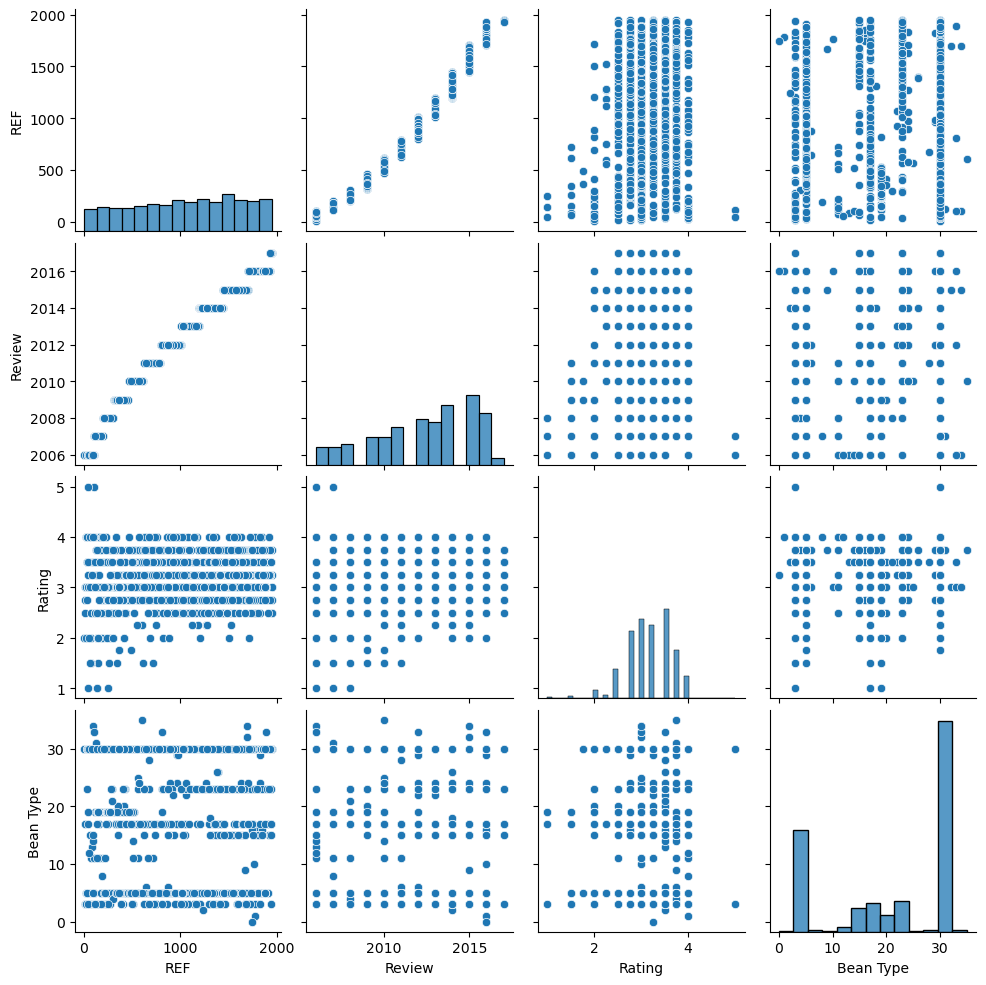

In [1459]:
sns.pairplot(df_concat)

plt.show();

In [1460]:
ratings_count = train['Rating'].value_counts(bins=16).sort_index()
ratings_count

(0.995, 1.25]      3
(1.25, 1.5]        7
(1.5, 1.75]        2
(1.75, 2.0]       23
(2.0, 2.25]        9
(2.25, 2.5]       87
(2.5, 2.75]      198
(2.75, 3.0]      234
(3.0, 3.25]      217
(3.25, 3.5]      265
(3.5, 3.75]      142
(3.75, 4.0]       66
(4.0, 4.25]        0
(4.25, 4.5]        0
(4.5, 4.75]        0
(4.75, 5.0]        2
Name: count, dtype: int64

In [1461]:
bins = train['Rating'].nunique()
bins

13

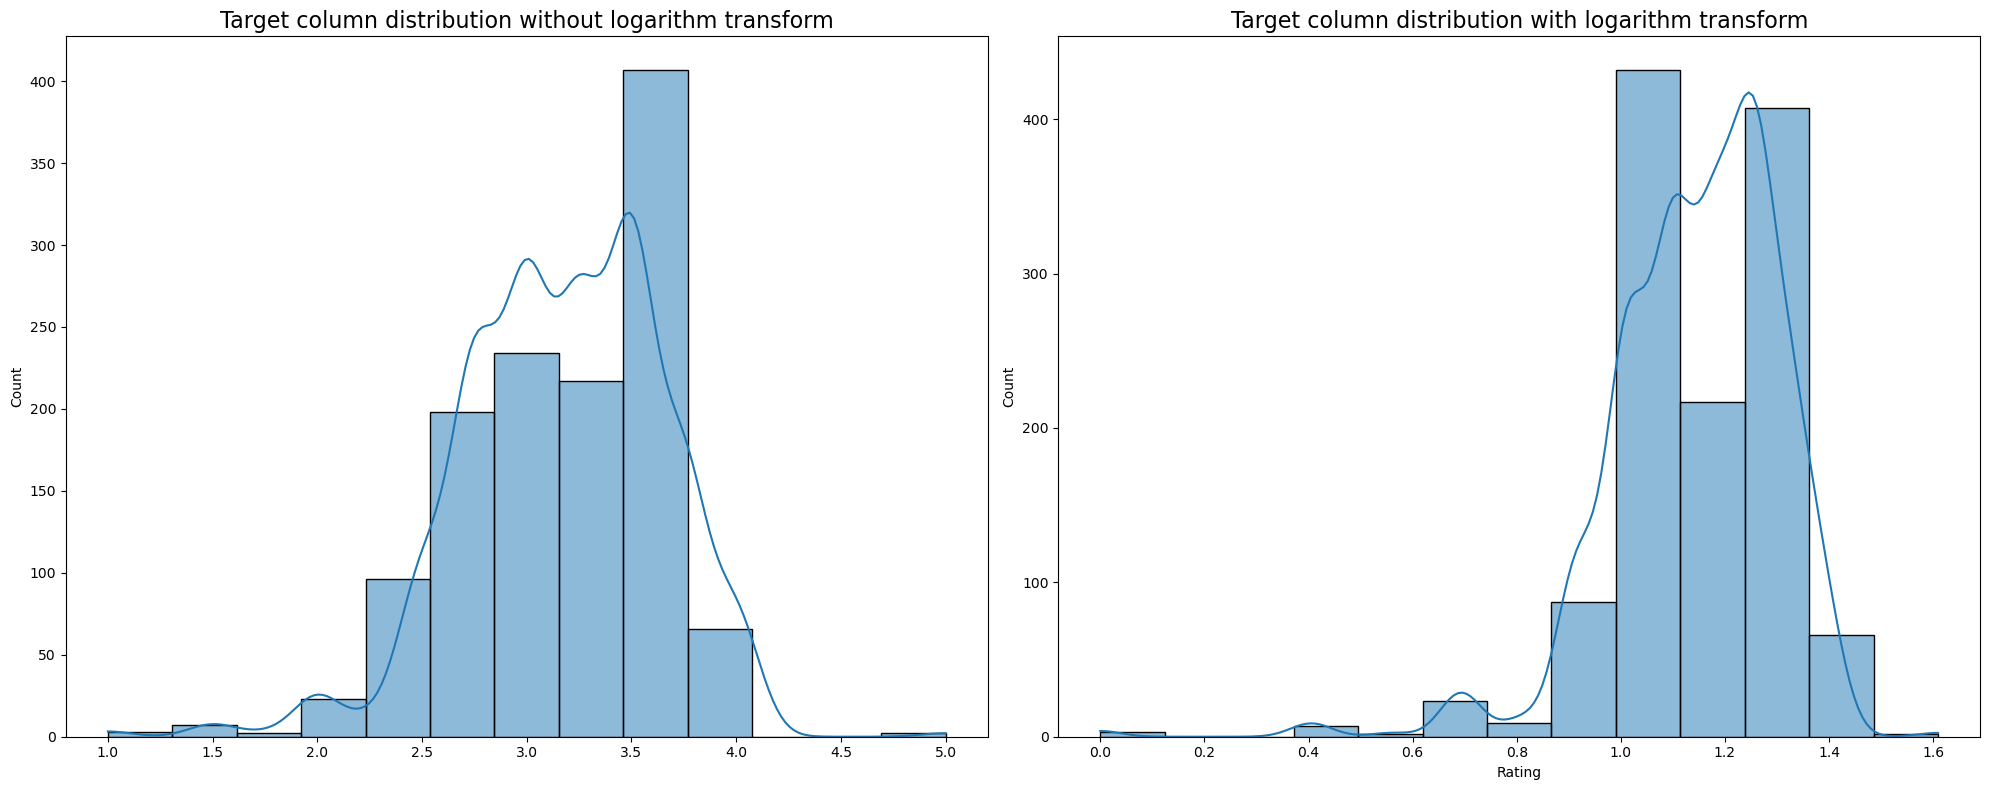

In [1462]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,8))
sns.histplot(train['Rating'].values, kde=True, bins=bins, ax=ax[0])
sns.histplot(np.log(train['Rating']), kde=True, bins=bins, ax=ax[1])
ax[0].set_title("Target column distribution without logarithm transform", fontsize = 16, 
                loc= 'center')
ax[1].set_title("Target column distribution with logarithm transform", fontsize = 16, 
                loc= 'center')
plt.tight_layout()
plt.show();

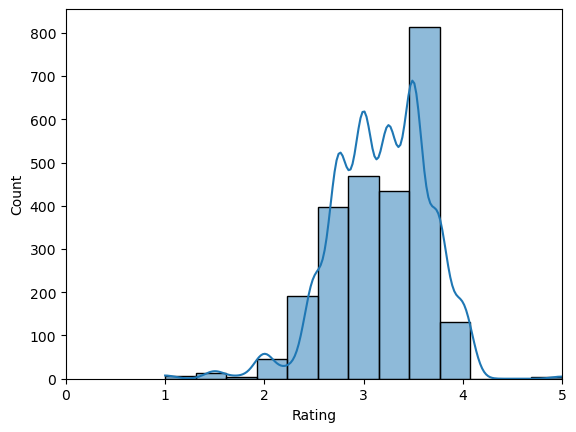

In [1463]:
sns.histplot(df_concat, x='Rating', kde=True, bins=13)
plt.xlim([0, 5])
plt.show();

Среднее: 3.176
Медиана: 3.250
Стандартное отклонение: 0.479


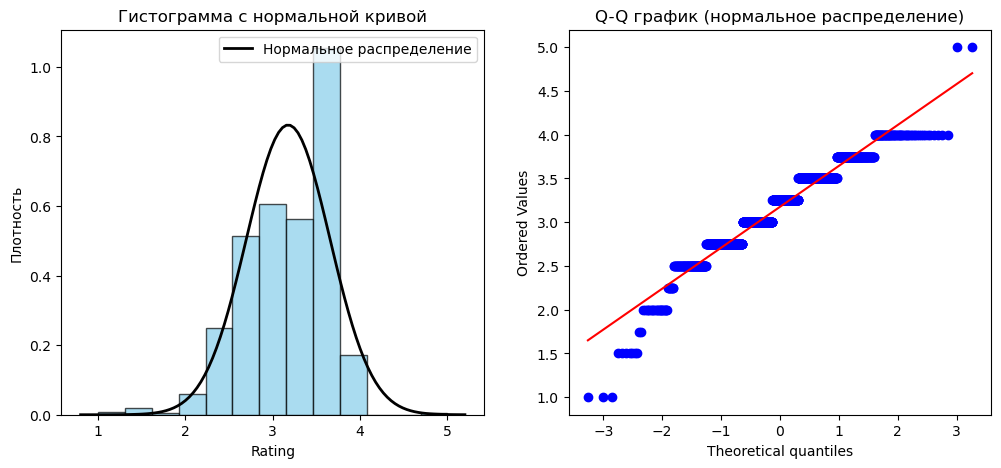


Статистические тесты на нормальность:
Тест Шапиро-Уилка: W = 0.9513786849076908, p-значение = 5.843712993874176e-20
  → Гипотеза о нормальности ОТВЕРГАЕТСЯ (p < 0.05)
Тест Колмогорова-Смирнова: D = 0.1287914566360021, p-значение = 1.3125968630043076e-18
  → Гипотеза о нормальности ОТВЕРГАЕТСЯ (p < 0.05)

Итоговый вывод:
Распределение ЗНАЧИМО ОТЛИЧАЕТСЯ от нормального (по тестам Шапиро-Уилка и Колмогорова-Смирнова).


In [1464]:
ratings = train['Rating']

mean = np.mean(ratings)
median = np.median(ratings)
std = np.std(ratings, ddof=1)

print(f'Среднее: {mean:.3f}')
print(f'Медиана: {median:.3f}')
print(f'Стандартное отклонение: {std:.3f}')

# 3. Графики
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Гистограмма с нормальной кривой
ax1.hist(ratings, bins=13, density=True, alpha=0.7, color='skyblue', edgecolor='black')
xmin, xmax = ax1.get_xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mean, std)
ax1.plot(x, p, 'k', linewidth=2, label='Нормальное распределение')
ax1.set_title('Гистограмма с нормальной кривой')
ax1.set_xlabel('Rating')
ax1.set_ylabel('Плотность')
ax1.legend()

# Q-Q график
stats.probplot(ratings, dist='norm', plot=ax2)
ax2.set_title('Q-Q график (нормальное распределение)')

plt.show()

# 4. Статистические тесты
print('\nСтатистические тесты на нормальность:')

# Тест Шапиро-Уилка
w_stat, p_shapiro = stats.shapiro(ratings)
print(f'Тест Шапиро-Уилка: W = {w_stat}, p-значение = {p_shapiro}')
if p_shapiro < 0.05:
    print('  → Гипотеза о нормальности ОТВЕРГАЕТСЯ (p < 0.05)')
else:
    print('  → Гипотеза о нормальности НЕ ОТВЕРГАЕТСЯ (p ≥ 0.05)')

# Тест Колмогорова-Смирнова (с оценкой параметров)
d_stat, p_ks = stats.kstest(ratings, cdf='norm', args=(mean, std))
print(f'Тест Колмогорова-Смирнова: D = {d_stat}, p-значение = {p_ks}')
if p_ks < 0.05:
    print('  → Гипотеза о нормальности ОТВЕРГАЕТСЯ (p < 0.05)')
else:
    print('  → Гипотеза о нормальности НЕ ОТВЕРГАЕТСЯ (p ≥ 0.05)')

# Итоговый вывод
print('\nИтоговый вывод:')
if p_shapiro < 0.05 or p_ks < 0.05:
    print('Распределение ЗНАЧИМО ОТЛИЧАЕТСЯ от нормального (по тестам Шапиро-Уилка и Колмогорова-Смирнова).')
else:
    print('Распределение НЕ ОТЛИЧАЕТСЯ от нормального (по тестам Шапиро-Уилка и Колмогорова-Смирнова).')


# Feature Engineering

In [1465]:
# def create_col_continent(value, col_name):

#     company_continent = {
#         'Europe': ['U.K.', 'Switzerland', 'France', 'Belgium', 'Spain', 'Italy', 'Austria', 'Sweden', 
#                 'Ireland', 'Poland', 'Hungary', 'Germany', 'Denmark', 'Lithuania', 'Scotland', 'Amsterdam', 
#                 'Finland', 'Iceland', 'Wales', 'Netherlands', 'Russia', 'Portugal', 'Czech Republic'], 
#         'North America': ['U.S.A.', 'Canada', 'Honduras', 'Guatemala', 'Dominican Republic', 'Grenada', 
#                         'Puerto Rico', 'Costa Rica', 'Nicaragua', 'Mexico', 'Martinique'], 
#         'South America': ['Ecuador', 'Colombia', 'Venezuela', 'Brazil', 'Peru', 'Argentina', 'Chile', 'Bolivia', 'Suriname'], 
#         'Africa': ['Madagascar', 'South Africa', 'Ghana', 'Sao Tome'], 
#         'Asia': ['Japan', 'Vietnam', 'South Korea', 'Israel', 'India', 'Singapore', 'Philippines'], 
#         'Oceania': ['New Zealand', 'Australia', 'Fiji', 'St. Lucia']
#     }

#     origin_continent = {
#         'South America': ['Venezuela', 'Bolivia', 'Ecuador', 'Peru', 'Colombia', 'Brazil', 'Panama', 'El Salvador', 'Suriname',
#                         'Peru, Dom. Rep', 'Ven., Indonesia, Ecuad.', 'Ven.,Ecu.,Peru,Nic.', 'Dr, Ecuador, Peru',
#                         'Ven, Bolivia, D.R.', 'Venezuela, Dom. Rep.', 'Peru, Ecuador, Venezuela', 'Peru, Ecuador', 'Peru(Smartin,Pangoa,Nacional)', 
#                         'Central And S. America', 'South America, Africa', 'South America', 'Venez,Africa,Brasil,Peru,Mex',
#                         'Peru, Mad., Dom. Rep.', 'Ecuador, Mad., Png', 'Venezuela, Trinidad'],
#         'Africa': ['Tanzania', 'Madagascar', 'Congo', 'Sao Tome', 'Ghana', 'Liberia',
#                 'Sao Tome & Principe', 'Principe', 'Uganda', 'Ivory Coast', 'Togo', 'Nigeria',
#                 'Cameroon', 'Ghana, Domin. Rep', 'Venezuela, Ghana', 'Ghana & Madagascar', 'Madagascar & Ecuador', 'West Africa',
#                 'Indonesia, Ghana', 'Ghana, Panama, Ecuador', 'Gre., Png, Haw., Haiti, Mad', 'Africa, Carribean, C. Am.', 'Gabon'],
#         'Asia': ['Indonesia', 'Vietnam', 'Malaysia', 'India', 'Sri Lanka', 'Burma',
#                 'Indonesia, Ghana', 'Venezuela, Java', 'Mad., Java, Png', 'Philippines'],
#         'Oceania': ['Papua New Guinea', 'Fiji', 'Solomon Islands', 'Vanuatu',
#                     'Samoa', 'Png, Vanuatu, Mad', 'Australia', 'St. Lucia'],
#         'North America': ['Nicaragua', 'Costa Rica', 'Mexico', 'Trinidad', 'Jamaica',
#                         'Belize', 'Hawaii', 'Grenada', 'Cuba', 'Puerto Rico', 'Trinidad-Tobago',
#                         'Martinique', 'Trinidad, Tobago', 'Carribean', 'Cost Rica, Ven', 'Ven., Trinidad, Mad.',
#                         'Carribean(Dr/Jam/Tri)', 'Venezuela, Carribean', 'Ecuador, Costa Rica', 'Venezuela/ Ghana', 
#                         'Ven, Trinidad, Ecuador', 'Dominican Rep., Bali', 'Guatemala', 'Honduras', 'Guat., D.R., Peru, Mad., Png',
#                         'Haiti', 'Dominican Republic', 'Domincan Republic', 'Caribbean']
#     }

#     col_dct = {
#        'Company Location': company_continent,
#        'Broad Bean Origin': origin_continent
#     }

#     col = col_dct.get(col_name)

#     if col is None:
#         return value

#     for group, values in col.items():
#         if value in values:
#             return group
#     return value

In [1466]:
# def create_cols_continent(df):
#     df = df.copy()
#     for col_name in ['Company Location', 'Broad Bean Origin']:
#         col_new = f'Continent {col_name}'
#         df[col_new] = df[col_name].apply(create_col_continent, args=(col_name,))

#     return df

In [1467]:
# train = create_cols_continent(train)
# test = create_cols_continent(test)

In [1468]:
train.head()

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin
0,Willie's Cacao,Rio Caribe,457,2009,72.0,U.K.,3.25,30,76
1,Beschle (Felchlin),"Ocumare, Premier Cru, Quizas No. 2",508,2010,72.0,Switzerland,3.50,5,76
2,Dark Forest,Tanzania,1554,2015,70.0,U.S.A.,3.00,15,64
3,Brasstown aka It's Chocolate,Cooproagro,1125,2013,72.0,U.S.A.,3.00,30,17
4,Pralus,"Java, Indonesie",32,2006,75.0,France,3.50,5,31


In [1469]:
# train['Continent Broad Bean Origin'].sort_values().unique()

In [1470]:
# train['Continent Company Location'].sort_values().unique()

In [1471]:
# train['Same Continent'] = (train['Continent Company Location'] == train['Continent Broad Bean Origin']).astype(np.int16)
# test['Same Continent'] = (test['Continent Company Location'] == test['Continent Broad Bean Origin']).astype(np.int16)

In [1472]:
train['Review'] = train['Review'].astype(np.int32)
test['Review'] = test['Review'].astype(np.int32)

In [1473]:
train['Review / REF'] = train['Review'] / train['REF']
test['Review / REF'] = test['Review'] / test['REF']

In [1474]:
train.head()

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin,Review / REF
0,Willie's Cacao,Rio Caribe,457,2009,72.0,U.K.,3.25,30,76,4.396061
1,Beschle (Felchlin),"Ocumare, Premier Cru, Quizas No. 2",508,2010,72.0,Switzerland,3.50,5,76,3.956693
2,Dark Forest,Tanzania,1554,2015,70.0,U.S.A.,3.00,15,64,1.296654
3,Brasstown aka It's Chocolate,Cooproagro,1125,2013,72.0,U.S.A.,3.00,30,17,1.789333
4,Pralus,"Java, Indonesie",32,2006,75.0,France,3.50,5,31,62.687500


In [1475]:
train.dtypes

Company                  object
Specific Bean Origin     object
REF                       int64
Review                    int32
Cocoa Percent           float32
Company Location         object
Rating                  float64
Bean Type                 int64
Broad Bean Origin         int64
Review / REF            float64
dtype: object

In [1476]:
cocoa_percent_mean = train['Cocoa Percent'].mean()
train['Cocoa Percent Deviation'] = train['Cocoa Percent'] - cocoa_percent_mean
test['Cocoa Percent Deviation'] = test['Cocoa Percent'] - cocoa_percent_mean

In [1477]:
train.head()

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin,Review / REF,Cocoa Percent Deviation
0,Willie's Cacao,Rio Caribe,457,2009,72.0,U.K.,3.25,30,76,4.396061,0.209564
1,Beschle (Felchlin),"Ocumare, Premier Cru, Quizas No. 2",508,2010,72.0,Switzerland,3.50,5,76,3.956693,0.209564
2,Dark Forest,Tanzania,1554,2015,70.0,U.S.A.,3.00,15,64,1.296654,-1.790436
3,Brasstown aka It's Chocolate,Cooproagro,1125,2013,72.0,U.S.A.,3.00,30,17,1.789333,0.209564
4,Pralus,"Java, Indonesie",32,2006,75.0,France,3.50,5,31,62.687500,3.209564


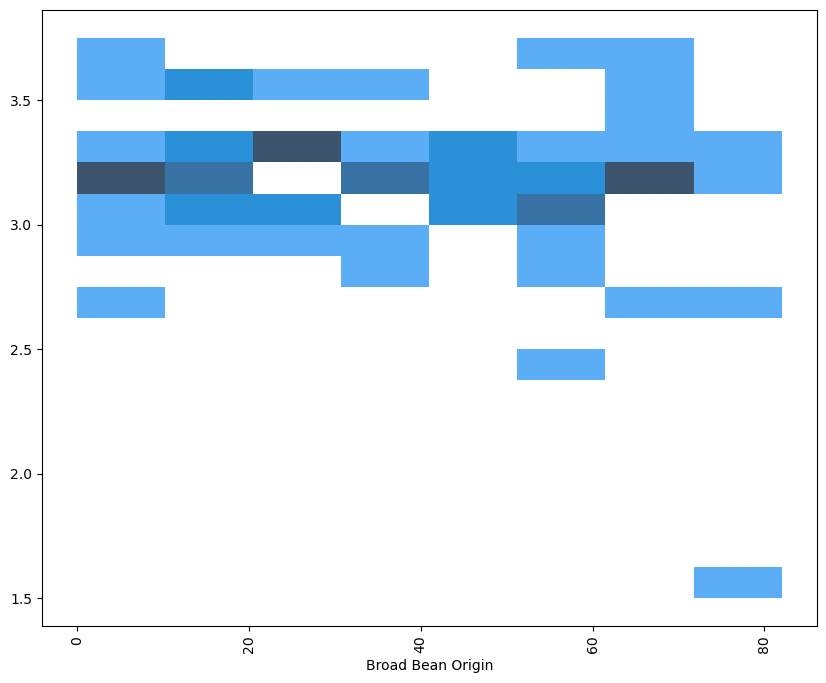

In [1478]:
bb_origin_rating = train.groupby('Broad Bean Origin')['Rating'].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 8))
sns.histplot(y=bb_origin_rating.values, x=bb_origin_rating.index)
plt.xticks(rotation=90)

plt.show();

In [1479]:
# bb_continent_rating = train.groupby('Continent Broad Bean Origin')['Rating'].mean().sort_values(ascending=False)

# plt.figure(figsize=(10, 8))
# sns.histplot(y=bb_continent_rating.values, x=bb_continent_rating.index)
# plt.xticks(rotation=90)

# plt.show();

In [1480]:
# company_continent_rating = train.groupby('Continent Company Location')['Rating'].mean().sort_values(ascending=False)

# plt.figure(figsize=(10, 8))
# sns.histplot(y=company_continent_rating.values, x=company_continent_rating.index)
# plt.xticks(rotation=90)

# plt.show();

In [1481]:
# train['Is Oceania'] = ((train['Continent Company Location'] == 'Oceania') & (train['Continent Broad Bean Origin'] == 'Oceania')).astype(np.int16)
# test['Is Oceania'] = ((test['Continent Company Location'] == 'Oceania') & (test['Continent Broad Bean Origin'] == 'Oceania')).astype(np.int16)

In [1482]:
df_concat.columns

Index(['Company', 'Specific Bean Origin', 'REF', 'Review', 'Cocoa Percent',
       'Company Location', 'Rating', 'Bean Type', 'Broad Bean Origin'],
      dtype='object')

# Сравнение моделей

In [1483]:
cat_features = [i for i, col in enumerate(X.columns) if X[col].dtype.name in ['category', 'object']]

NameError: name 'X' is not defined

In [ ]:
n_estimators = 500
lgbm = LGBMRegressor(n_estimators=n_estimators, max_depth=7, n_jobs=-1, learning_rate=0.08, objective='regression', metric=['rmse'])
xgb = XGBRegressor(n_estimators=n_estimators, max_depth=9, n_jobs=-1, learning_rate=0.08, eval_metric=['rmse'])
catboost = CatBoostRegressor(cat_features=cat_features, learning_rate=0.08, max_depth=9, eval_metric='RMSE')

In [ ]:
def get_scores(report_df, model, X, y, name):
    report = pd.DataFrame(columns=['r2_mean', 'r2_std'], data=[0])

    scores = cross_val_score(model, X, y, cv=3, scoring='r2', n_jobs=-1)

    report['r2_mean'] = scores.mean()
    report['r2_std'] = scores.std()
    report.index = [name]
    report_df = pd.concat([report_df, report], axis=0)

    return report_df

In [ ]:
df_report = pd.DataFrame()

In [ ]:
df_report = get_scores(df_report, catboost, X, y, 'CatBoost')

NameError: name 'get_scores' is not defined

In [ ]:
df_report = get_scores(df_report, lgbm, X, y, 'LGBM')

ValueError: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\pong\anaconda3\envs\ml\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\pong\anaconda3\envs\ml\Lib\site-packages\lightgbm\sklearn.py", line 1398, in fit
    super().fit(
  File "c:\Users\pong\anaconda3\envs\ml\Lib\site-packages\lightgbm\sklearn.py", line 1049, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\pong\anaconda3\envs\ml\Lib\site-packages\lightgbm\engine.py", line 297, in train
    booster = Booster(params=params, train_set=train_set)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\pong\anaconda3\envs\ml\Lib\site-packages\lightgbm\basic.py", line 3656, in __init__
    train_set.construct()
  File "c:\Users\pong\anaconda3\envs\ml\Lib\site-packages\lightgbm\basic.py", line 2590, in construct
    self._lazy_init(
  File "c:\Users\pong\anaconda3\envs\ml\Lib\site-packages\lightgbm\basic.py", line 2123, in _lazy_init
    data, feature_name, categorical_feature, self.pandas_categorical = _data_from_pandas(
                                                                       ^^^^^^^^^^^^^^^^^^
  File "c:\Users\pong\anaconda3\envs\ml\Lib\site-packages\lightgbm\basic.py", line 868, in _data_from_pandas
    _pandas_to_numpy(data, target_dtype=target_dtype),
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\pong\anaconda3\envs\ml\Lib\site-packages\lightgbm\basic.py", line 814, in _pandas_to_numpy
    _check_for_bad_pandas_dtypes(data.dtypes)
  File "c:\Users\pong\anaconda3\envs\ml\Lib\site-packages\lightgbm\basic.py", line 805, in _check_for_bad_pandas_dtypes
    raise ValueError(
ValueError: pandas dtypes must be int, float or bool.
Fields with bad pandas dtypes: Company: object, Specific Bean Origin: object, Company Location: object, Bean Type: object, Broad Bean Origin: object


In [ ]:
df_report = get_scores(df_report, xgb, X, y, 'XGB')

AttributeError: 'super' object has no attribute '__sklearn_tags__'

In [ ]:
df_report

,R2_CV_Score
CatBoost,0.144455


In [ ]:
train.head()

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin,splitted_df
0,Willie's Cacao,Rio Caribe,457,2009,72.0,U.K.,3.25,Trinitario,Venezuela,train
1,Beschle (Felchlin),"Ocumare, Premier Cru, Quizas No. 2",508,2010,72.0,Switzerland,3.50,Other,Venezuela,train
2,Dark Forest,Tanzania,1554,2015,70.0,U.S.A.,3.00,Criollo,Tanzania,train
3,Brasstown aka It's Chocolate,Cooproagro,1125,2013,72.0,U.S.A.,3.00,Trinitario,Dominican Republic,train
4,Pralus,"Java, Indonesie",32,2006,75.0,France,3.50,Criollo,Indonesia,train


In [ ]:
train.dtypes

Company                  object
Specific Bean Origin     object
REF                       int64
Review                   object
Cocoa Percent           float32
Company Location         object
Rating                  float64
Bean Type                object
Broad Bean Origin        object
splitted_df              object
dtype: object

# Обучение модели

In [ ]:
train.columns

Index(['Company', 'Specific Bean Origin', 'REF', 'Review', 'Cocoa Percent',
       'Company Location', 'Rating', 'Bean Type', 'Broad Bean Origin',
       'Company Continent', 'Broad Bean Continent', 'Same Continent',
       'Review / REF', 'Cocoa Percent Deviation', 'Is Oceania'],
      dtype='object')

In [ ]:
['Company', 'Specific Bean Origin', 'REF', 'Review', 'Cocoa Percent',
'Company Location', 'Bean Type', 'Broad Bean Origin', 
'Continent Company Location', 'Continent Broad Bean Origin', 'Same Continent', 'Review / REF', 'Is Oceania', 'Cocoa Percent Deviation']
# 1
# cols = ['Company', 'Specific Bean Origin', 'REF', 'Review', 'Cocoa Percent',
# 'Company Location', 'Bean Type', 'Broad Bean Origin', 
# 'Continent Company Location', 'Continent Broad Bean Origin', 'Same Continent', 'Review / REF', 'Is Oceania', 'Cocoa Percent Deviation']
# 2
cols = ['Company', 'Specific Bean Origin', 'REF', 'Review', 'Cocoa Percent',
'Company Location', 'Bean Type', 'Broad Bean Origin', 
'Same Continent', 'Review / REF', 'Cocoa Percent Deviation']
# 3
# cols = ['Company', 'Specific Bean Origin', 'REF', 'Review', 'Cocoa Percent',
# 'Company Location', 'Bean Type', 'Broad Bean Origin', 
# 'Continent Company Location', 'Same Continent', 'Review / REF', 'Cocoa Percent Deviation']

In [ ]:
X = train[cols]
y = np.log(train['Rating'])
# y = train['Rating']
test = test[cols]

In [ ]:
# scaler = MinMaxScaler()
# X[['REF', 'Cocoa Percent']] = scaler.fit_transform(X[['REF', 'Cocoa Percent']])

# # scaler = StandardScaler()
# # X[['REF', 'Cocoa Percent']] = scaler.fit_transform(X[['REF', 'Cocoa Percent']])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X.dtypes

Company                     object
Specific Bean Origin        object
REF                          int64
Review                       int64
Cocoa Percent              float32
Company Location            object
Bean Type                   object
Broad Bean Origin           object
Company Continent           object
Same Continent               int16
Review / REF               float64
Cocoa Percent Deviation    float32
dtype: object

In [ ]:
X['Specific Bean Origin'].nunique()

616

In [ ]:
cat_features = [i for i, col in enumerate(X.columns) if X[col].dtype.name in ['category', 'object']]

In [ ]:
params = {'learning_rate': 0.008553940111605946,
          'n_estimators': 2114,
          'l2_leaf_reg': 1.4163130536678312,
          'random_strength': 4.287920281067569,
          'bagging_temperature': 0.7916641053388684,
          'grow_policy': 'SymmetricTree',
          'min_data_in_leaf': 7,
          'rsm': 0.9923008576207031
          }

In [ ]:
# params = {'learning_rate': 0.007520420654485367,
#         'l2_leaf_reg': 1.3522242767637895,
#         'loss_function': 'RMSE',
#         'random_strength': 0.07997518675548071,
#         'bagging_temperature': 0.28238271673339294,
#         'n_estimators': 1946}

In [ ]:
model = CatBoostRegressor(cat_features=cat_features, **params, silent=True)

scores = cross_val_score(model, X, y, cv=3, scoring='r2', n_jobs=-1).mean()
scores

0.20533855800703993

In [ ]:
# C новыми фичами
# 0.2121259266069528

# С маппингом фулл

# 0.20863990582958777 без Scaler с Review с np.log
# 0.20546725475372918 без Scaler с Review

# С маппингом лайт

# 0.20760436749991604 без Scaler с Review с np.log
# 0.20664662299206418 без Scaler с Review

# Без маппинга

# 0.21359160268312513 без Scaler с Review с np.log
# 0.21359160268312513 с MinMaxScaler с Review с np.log
# 0.21107482352883877 без Scaler с Review без 'rsm' в params
# 0.20804831236352153 без Scaler с Review
# 0.20773979204409335 с MinMaxScaler
# 0.2077659348305294 с StandartScaler

In [ ]:
model = CatBoostRegressor(cat_features=cat_features, **params, silent=True)
model.fit(X_train, y_train)

score = r2_score(y_test, model.predict(X_test))
score

0.2329163049625702

In [ ]:
# C новыми фичами
# 0.2193200050448073 полный набор
# 0.23778454217391998 второй набор

# С маппингом фулл

# 0.2330602072060809 без Scaler с Review с np.log
# 0.22815180588362238 без Scaler с Review

# С маппингом лайт

# 0.23258690741494337 без Scaler с Review с np.log
# 0.2260191589185948 без Scaler с Review

# Без маппинга

# 0.20507320045026678 без Scaler с Review с np.log
# 0.20819856183027696 без Scaler с Review
# 0.20819856183027696 с MinMaxScaler
# 0.20819856183027696 с StandartScaler

In [ ]:
stop

NameError: name 'stop' is not defined

# Оптюна

## Для сравнения с эталонными значениями

In [1484]:
cols = train.columns.tolist()

print(f'Все признаки:\n{cols}')

Все признаки:
['Company', 'Specific Bean Origin', 'REF', 'Review', 'Cocoa Percent', 'Company Location', 'Rating', 'Bean Type', 'Broad Bean Origin', 'Review / REF', 'Cocoa Percent Deviation']


In [1485]:
num_cols = train.select_dtypes(include='number').columns.tolist()
cat_cols = train.select_dtypes(exclude='number').columns.tolist()

print(f'Числовые признаки:\n{num_cols}')
print()
print(f'Категориальные признаки:\n{cat_cols}')

Числовые признаки:
['REF', 'Review', 'Cocoa Percent', 'Rating', 'Bean Type', 'Broad Bean Origin', 'Review / REF', 'Cocoa Percent Deviation']

Категориальные признаки:
['Company', 'Specific Bean Origin', 'Company Location']


In [1486]:
# test['Cocoa Percent'] = test['Cocoa Percent'].str.rstrip('%').astype(np.float32)
test['Review'] = test['Review'].astype('object')

mm_scaler = MinMaxScaler()

train['REF'] = mm_scaler.fit_transform(train[['REF']])  
test['REF'] = mm_scaler.transform(test[['REF']])

mm_scaler = MinMaxScaler()

train['Cocoa Percent'] = mm_scaler.fit_transform(train[['Cocoa Percent']])  
test['Cocoa Percent'] = mm_scaler.transform(test[['Cocoa Percent']])
train['Bean Type'] = train['Bean Type'].astype(np.float32)
test['Bean Type'] = test['Bean Type'].astype(np.float32)

mm_scaler = MinMaxScaler()

train['Bean Type'] = mm_scaler.fit_transform(train[['Bean Type']])  
test['Bean Type'] = mm_scaler.transform(test[['Bean Type']])
train['Broad Bean Origin'] = train['Broad Bean Origin'].astype(np.float32)
test['Broad Bean Origin'] = test['Broad Bean Origin'].astype(np.float32)

mm_scaler = MinMaxScaler()

train['Broad Bean Origin'] = mm_scaler.fit_transform(train[['Broad Bean Origin']])  
test['Broad Bean Origin'] = mm_scaler.transform(test[['Broad Bean Origin']])

# cat_features = [i for i, col in enumerate(train.columns) if train[col].dtype.name in ['category', 'object']]

In [1487]:
train.dtypes

Company                     object
Specific Bean Origin        object
REF                        float64
Review                       int32
Cocoa Percent              float32
Company Location            object
Rating                     float64
Bean Type                  float32
Broad Bean Origin          float32
Review / REF               float64
Cocoa Percent Deviation    float32
dtype: object

In [1488]:
train

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin,Review / REF,Cocoa Percent Deviation
0,Willie's Cacao,Rio Caribe,0.232152,2009,0.481481,U.K.,3.25,0.882353,0.926829,4.396061,0.209564
1,Beschle (Felchlin),"Ocumare, Premier Cru, Quizas No. 2",0.258346,2010,0.481481,Switzerland,3.50,0.147059,0.926829,3.956693,0.209564
2,Dark Forest,Tanzania,0.795583,2015,0.444444,U.S.A.,3.00,0.441176,0.780488,1.296654,-1.790436
3,Brasstown aka It's Chocolate,Cooproagro,0.575244,2013,0.481481,U.S.A.,3.00,0.882353,0.207317,1.789333,0.209564
4,Pralus,"Java, Indonesie",0.013867,2006,0.537037,France,3.50,0.147059,0.378049,62.687500,3.209564
...,...,...,...,...,...,...,...,...,...,...,...
1250,Artisan du Chocolat,Madagascar,0.183873,2009,0.629630,U.K.,3.00,0.882353,0.451219,5.534435,8.209564
1251,Marana,Cusco,0.965074,2016,0.444444,Peru,2.75,0.147059,0.560976,1.070064,-1.790436
1252,Arete,Nacional,0.785311,2015,0.407407,U.S.A.,3.50,0.676471,0.560976,1.313559,-3.790436
1253,Fresco,"Conacado, #212, LR, SC",0.327170,2011,0.481481,U.S.A.,3.50,0.882353,0.207317,3.132399,0.209564


In [1489]:
train.columns

Index(['Company', 'Specific Bean Origin', 'REF', 'Review', 'Cocoa Percent',
       'Company Location', 'Rating', 'Bean Type', 'Broad Bean Origin',
       'Review / REF', 'Cocoa Percent Deviation'],
      dtype='object')

In [1490]:
['Company', 'Specific Bean Origin', 'REF', 'Review', 'Cocoa Percent', 'Company Location', 'Bean Type', 'Broad Bean Origin',
 'Review / REF', 'Cocoa Percent Deviation']

# 1
cols1 = ['Company', 'Specific Bean Origin', 'REF', 'Review', 'Cocoa Percent', 'Company Location', 'Bean Type', 'Broad Bean Origin',
        'Review / REF', 'Cocoa Percent Deviation']


# 2
cols2 = ['Company', 'Specific Bean Origin', 'REF', 'Review', 'Cocoa Percent', 'Company Location', 'Bean Type', 'Broad Bean Origin']


# 3
cols3 = ['Company', 'Specific Bean Origin', 'REF', 'Review', 'Cocoa Percent', 'Company Location', 'Bean Type', 'Broad Bean Origin']


# 4
cols4 = ['Company', 'Specific Bean Origin', 'REF', 'Review', 'Cocoa Percent', 'Company Location', 'Bean Type', 'Broad Bean Origin']


# 5
cols5 = ['Company', 'Specific Bean Origin', 'REF', 'Review', 'Cocoa Percent', 'Company Location', 'Bean Type', 'Broad Bean Origin',
         'Review / REF', 'Cocoa Percent Deviation']


# 6
cols6 = ['Company', 'Specific Bean Origin', 'REF', 'Review', 'Cocoa Percent', 'Company Location', 'Bean Type', 'Broad Bean Origin', 
'Review / REF', 'Cocoa Percent Deviation']


# 7
cols7 = ['Company', 'Specific Bean Origin', 'REF', 'Cocoa Percent', 'Company Location', 'Bean Type', 'Broad Bean Origin', 
'Review / REF', 'Cocoa Percent Deviation']


# 8
cols8 = ['Company', 'Specific Bean Origin', 'Review', 'Cocoa Percent', 'Company Location', 'Bean Type', 'Broad Bean Origin', 
'Review / REF', 'Cocoa Percent Deviation']


# 9
cols9 = ['Company', 'Specific Bean Origin', 'REF', 'Review', 'Cocoa Percent', 'Company Location', 'Bean Type', 'Broad Bean Origin',
          'Review / REF', 'Cocoa Percent Deviation']


# 10
cols10 = ['Company', 'Specific Bean Origin', 'REF', 'Review', 'Cocoa Percent', 'Company Location', 'Bean Type', 'Broad Bean Origin']


# 11
cols11 = ['REF', 'Review', 'Cocoa Percent',
 'Review / REF', 'Cocoa Percent Deviation']


# 12
cols12 = ['REF', 'Review', 'Cocoa Percent']

# 13
cols13 = ['Review', 'Cocoa Percent', 
          'Review / REF', 'Cocoa Percent Deviation']


# 14
cols14 = ['Company', 'Specific Bean Origin', 'REF', 'Review', 'Cocoa Percent', 'Company Location', 'Bean Type', 'Broad Bean Origin',
  ]


# 15
cols15 = ['Company', 'REF', 'Review', 'Cocoa Percent', 'Company Location', 'Bean Type', 'Broad Bean Origin',
           'Review / REF', 'Cocoa Percent Deviation']



cols_lst = [cols1, cols2, cols3, cols4, cols5, cols6, cols7, cols8, cols9, cols10, cols11, cols12, cols13, cols14, cols15]

In [1491]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error, mean_squared_error

In [1492]:
# 3536-32	    0.029228	0.009231	0.038588	0.001489
# 3536-35	    0.026113	0.008232	0.034253	0.001173
# 3536-37	    0.028541	0.009024	0.037442	0.001402

# 3532-32	    0.024819	0.007824	0.032240	0.001039
# 3532-35	    0.024819	0.007824	0.032240	0.001039
# 3532-37	    0.026301	0.008307	0.033499	0.001122

# 37-32	        0.047462	0.014993	0.061630	0.003798
# 37-35	        0.017682	0.005598	0.022911	0.000525
# 37-3536	    0.028541	0.009027	0.037442	0.001402
# 37-3532	    0.026301	0.008313	0.033499	0.001122

In [1493]:
submission_35_32 = pd.read_csv('choko_submission_35_32.csv', usecols= ['Rating'])
submission_35_32 = submission_35_32.values

submission_37 = pd.read_csv('choko_submission_37.csv', usecols= ['Rating'])
submission_37 = submission_37.values

In [1494]:
# X_train = train[cols1]
# y_train = train['Rating']
# X_test = test[cols1]
# cat_features = [i for i, col in enumerate(X_train.columns) if X_train[col].dtype.name in ['category', 'object']]

In [1495]:
# params = {'learning_rate': 0.009039437713326022, 'n_estimators': 2273, 'l2_leaf_reg': 1.4513127455825996, 
#             'random_strength': 8.542817281162387, 'bagging_temperature': 0.3744773241174496}
# model = CatBoostRegressor(cat_features=cat_features, **params, silent=True, task_type='GPU')
# model.fit(X_train, y_train)
# # return model

In [1496]:
# y_pred = model.predict(X_test)

In [1497]:
def cb_fit(X_, y_):
    params = {'learning_rate': 0.009039437713326022, 'n_estimators': 2273, 'l2_leaf_reg': 1.4513127455825996, 
              'random_strength': 8.542817281162387, 'bagging_temperature': 0.3744773241174496}
    model = CatBoostRegressor(cat_features=cat_features, **params, silent=True, task_type='GPU')
    model.fit(X_, y_)
    return model

In [1498]:
# subs_report = pd.DataFrame()

# submission_lst = [(submission_32, '32'), (submission_35, '35'), (submission_35_36, '3536'), (submission_35_32, '3532'), 
#                   (submission_37, '37'), (submission_102, '102'), (submission_105, '105'), (submission_111, '111')]

# for i in range(len(submission_lst)):
#     for j in range(len(submission_lst)):
#         if i != j:
#             i_name, j_name = submission_lst[i][1], submission_lst[j][1]
#             mae = mean_absolute_error(submission_lst[i][0], submission_lst[j][0])
#             mape = mean_absolute_percentage_error(submission_lst[i][0], submission_lst[j][0])
#             rmse = root_mean_squared_error(submission_lst[i][0], submission_lst[j][0])
#             mse = mean_squared_error(submission_lst[i][0], submission_lst[j][0])
#             report = pd.DataFrame(columns=['MAE', 'MAPE', 'RMSE', 'MSE'], data=[[0, 0, 0, 0]])
#             report[['MAE', 'MAPE', 'RMSE', 'MSE']] =  mae, mape, rmse, mse
#             report.index = [f'{i_name}-{j_name}',]
#             subs_report = pd.concat([subs_report, report], axis=0)

#     # return subs_report



In [1499]:
def get_scores(report_df, y_pred, name):
    
    submission_lst = [(submission_35_32, '3532'), (submission_37, '37')]
    
    for i in range(len(submission_lst)):
        i_name = submission_lst[i][1]
        mae = mean_absolute_error(submission_lst[i][0], y_pred)
        mape = mean_absolute_percentage_error(submission_lst[i][0], y_pred)
        rmse = root_mean_squared_error(submission_lst[i][0], y_pred)
        mse = mean_squared_error(submission_lst[i][0], y_pred)
    print(mae, mape, rmse, mse)

    report = pd.DataFrame(columns=['Subs', 'MAE', 'MAPE', 'RMSE', 'MSE'], data=[[0, 0, 0, 0, 0]])
    report[['MAE', 'MAPE', 'RMSE', 'MSE']] =  mae, mape, rmse, mse
    report.index = [f'{name} {i_name}']

    report_df = pd.concat([report_df, report], axis=0)

    return report_df

In [1500]:
df_report = pd.DataFrame()

for number, cols in enumerate(cols_lst, start=1):
    X_train = train[cols]
    y_train = train['Rating']
    X_test = test[cols]
    cat_features = [i for i, col in enumerate(X_train.columns) if X_train[col].dtype.name in ['category', 'object']]
    print(f'Набор колонок № {number}',  cols, sep='\n')
    for n_est, (X_train_, y_train_) in enumerate([(X_train, y_train), (X_train, np.log(y_train))], start=1):
        log_base = ('log', 'base')[n_est % 2]
        print(log_base)
        model = cb_fit(X_train_, y_train_)
        y_pred = model.predict(X_test)
        if log_base == 'log':
            y_pred = np.exp(y_pred)
        df_report = get_scores(df_report, y_pred, f'col{number}-{log_base}')

Набор колонок № 1
['Company', 'Specific Bean Origin', 'REF', 'Review', 'Cocoa Percent', 'Company Location', 'Bean Type', 'Broad Bean Origin', 'Review / REF', 'Cocoa Percent Deviation']
base
0.08423198120874875 0.026694146531427904 0.11068844580890567 0.012251932035591048
log
0.09741528494254068 0.030762460805098243 0.1250328714305665 0.01563321893817257
Набор колонок № 2
['Company', 'Specific Bean Origin', 'REF', 'Review', 'Cocoa Percent', 'Company Location', 'Bean Type', 'Broad Bean Origin']
base
0.08118306626316675 0.02570274965140708 0.10652495735542136 0.01134756653957434
log
0.0977974306023572 0.030932690406706737 0.1270467165011271 0.016140868173717755
Набор колонок № 3
['Company', 'Specific Bean Origin', 'REF', 'Review', 'Cocoa Percent', 'Company Location', 'Bean Type', 'Broad Bean Origin']
base
0.08118306626316675 0.02570274965140708 0.10652495735542136 0.01134756653957434
log


KeyboardInterrupt: 

In [ ]:
# 0.029228	0.009231	0.038588	0.001489
df_report

,Subs,MAE,MAPE,RMSE,MSE
col1-base 37,0,0.087576,0.027626,0.112153,0.012578
col1-log 37,0,0.100290,0.031479,0.127809,0.016335
col2-base 37,0,0.084945,0.026913,0.107751,0.011610
col2-log 37,0,0.098829,0.031050,0.124925,0.015606
col3-base 37,0,0.086100,0.027242,0.112365,0.012626
col3-log 37,0,0.097002,0.030575,0.125399,0.015725
col4-base 37,0,0.086374,0.027279,0.110760,0.012268
col4-log 37,0,0.099745,0.031422,0.127961,0.016374
col5-base 37,0,0.084867,0.026840,0.108293,0.011727
col5-log 37,0,0.098071,0.030822,0.123528,0.015259


In [ ]:
stop

NameError: name 'stop' is not defined

## Для подбора параметров

In [ ]:
def objective_catboost(trial, X_, y_):

    params = {
        'max_depth': 4,
        'learning_rate': trial.suggest_float("learning_rate", 0.0005, 0.2, log=True),    # Скорость обучения
        'n_estimators': trial.suggest_int("n_estimators", 1800, 3000),
        'l2_leaf_reg': trial.suggest_float("l2_leaf_reg", 1, 10),   # Коэффициент L2-регуляризации
        'random_strength': trial.suggest_float("random_strength", 0, 10),   # Степень случайности
        'bagging_temperature':  trial.suggest_float("bagging_temperature", 0, 1),   # Интенсивность бэггинга
        'grow_policy': 'SymmetricTree',
        # 'border_count': trial.suggest_int("border_count", 32, 255)
        # 'iterations': trial.suggest_int('iterations', 100, 300),  # Количество итераций
        # 'depth': trial.suggest_int('depth', 3, 4, 5),  # Глубина деревьев
        # 'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.2),  # Скорость обучения
        # 'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 4, 8),  # Коэффициент L2-регуляризации
        # 'loss_function': trial.suggest_categorical('loss_function', ['RMSE', 'MAE']),  # Функция потерь
        # 'early_stopping_rounds': trial.suggest_int('early_stopping_rounds', 10, 20),  # Ранняя остановка
        # 'border_count': trial.suggest_categorical('border_count', [32, 128]),  # Количество границ
        # 'random_strength': trial.suggest_float('random_strength', 0.1, 10),  # Степень случайности
        # 'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),  # Интенсивность бэггинга
        # 'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise']),    # Стратегия роста
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 15),   # Минимальное количество объектов в листе
        'rsm': trial.suggest_float('rsm', 0.8, 1.0),    # Доля признаков для каждого дерева

    }
    
    model = CatBoostRegressor(cat_features=cat_features, **params, silent=True)

    score = cross_val_score(model, X_, y_, cv=3, scoring="r2", n_jobs=-1).mean()
    return score

# study = optuna.create_study(direction="maximize")
# study.optimize(objective_catboost, n_trials=5, n_jobs=-1)

In [ ]:
# report = pd.DataFrame(columns=['best_value', 'best_trial_number', 'best_params'], data=[[0, 0, 0]])
# report[['best_value', 'best_trial_number', 'best_params']] = study.best_value, study.best_trial.number, str(study.best_params)
# study.best_value, study.best_trial.number, study.best_params

In [ ]:
# print(report['best_params'].to_dict()[0])

In [ ]:
# report

In [ ]:
def get_scores(report_df, study, name):
    report = pd.DataFrame(columns=['best_value', 'best_trial_number', 'best_params'], data=[[0, 0, 0]])
    report[['best_value', 'best_trial_number', 'best_params']] = study.best_value, study.best_trial.number, str(study.best_params)
    report.index = [name]

    report_df = pd.concat([report_df, report], axis=0)

    return report_df

In [ ]:
df_report = pd.DataFrame()

for number, cols in enumerate([eval(f'cols{i}') for i in range(1, 4)], start=1):
    X_train = train[cols]
    y_train = train['Rating']
    X_test = test[cols]
    cat_features = [i for i, col in enumerate(X_train.columns) if X_train[col].dtype.name in ['category', 'object']]
    print(f'Набор колонок № {number}',  cols, sep='\n')
    for n_est, (X_train_, y_train_) in enumerate([(X_train, y_train), (X_train, np.log(y_train))], start=1):
        log_base = ('log', 'base')[n_est % 2]
        print(log_base)

        study = optuna.create_study(direction="maximize")
        study.optimize(
            lambda trial: objective_catboost(trial, X_train_, y_train_),
            n_trials=2,
            n_jobs=-1
    )   
        df_report = get_scores(df_report, study, f'{number} {log_base}')

        print()
    print()

[I 2025-11-16 11:38:49,416] A new study created in memory with name: no-name-6466a33b-e0c9-4c1b-89d1-091d59b1cbd8


Набор колонок № 1
['Company', 'Specific Bean Origin', 'REF', 'Review', 'Cocoa Percent', 'Company Location', 'Bean Type', 'Broad Bean Origin', 'Company Continent', 'Broad Bean Continent', 'Same Continent', 'Review / REF', 'Is Oceania', 'Cocoa Percent Deviation']
base


[I 2025-11-16 11:39:23,943] Trial 1 finished with value: 0.07895761488890951 and parameters: {'learning_rate': 0.0009054472662640887, 'n_estimators': 2305, 'l2_leaf_reg': 6.4444257809762595, 'random_strength': 9.436833845829481, 'bagging_temperature': 0.08284185055400028, 'min_data_in_leaf': 12, 'rsm': 0.9793499512211602}. Best is trial 1 with value: 0.07895761488890951.
[I 2025-11-16 11:39:35,917] Trial 0 finished with value: 0.10228131315683668 and parameters: {'learning_rate': 0.11183660890904479, 'n_estimators': 2961, 'l2_leaf_reg': 2.815108533122846, 'random_strength': 3.2646083213780344, 'bagging_temperature': 0.4865732359399463, 'min_data_in_leaf': 5, 'rsm': 0.9868994707798235}. Best is trial 0 with value: 0.10228131315683668.
[I 2025-11-16 11:39:35,917] A new study created in memory with name: no-name-013af1d8-72a4-4de4-aa67-6b67ef6667e2



log


[I 2025-11-16 11:40:14,115] Trial 1 finished with value: 0.17890030135488214 and parameters: {'learning_rate': 0.05606960651765896, 'n_estimators': 2270, 'l2_leaf_reg': 3.8418241422457484, 'random_strength': 7.724610612295661, 'bagging_temperature': 0.004952123898984917, 'min_data_in_leaf': 12, 'rsm': 0.8279794277822732}. Best is trial 1 with value: 0.17890030135488214.
[I 2025-11-16 11:40:19,100] Trial 0 finished with value: 0.20390888054310266 and parameters: {'learning_rate': 0.015191392527046247, 'n_estimators': 2731, 'l2_leaf_reg': 2.8572874651122326, 'random_strength': 7.92892390973531, 'bagging_temperature': 0.9872675395460855, 'min_data_in_leaf': 12, 'rsm': 0.8025454047913914}. Best is trial 0 with value: 0.20390888054310266.
[I 2025-11-16 11:40:19,100] A new study created in memory with name: no-name-d5d0e9c6-90a2-4cc0-a6eb-1aef8999caa3




Набор колонок № 2
['Company', 'Specific Bean Origin', 'REF', 'Review', 'Cocoa Percent', 'Company Location', 'Bean Type', 'Broad Bean Origin', 'Same Continent', 'Review / REF', 'Cocoa Percent Deviation']
base


[I 2025-11-16 11:41:01,731] Trial 0 finished with value: 0.12399465103066232 and parameters: {'learning_rate': 0.1263776699567238, 'n_estimators': 2569, 'l2_leaf_reg': 9.071050221574291, 'random_strength': 9.173389856280089, 'bagging_temperature': 0.0726365664557862, 'min_data_in_leaf': 14, 'rsm': 0.8933892264606434}. Best is trial 0 with value: 0.12399465103066232.
[I 2025-11-16 11:41:06,504] Trial 1 finished with value: 0.19640855418540948 and parameters: {'learning_rate': 0.007459781084791583, 'n_estimators': 2984, 'l2_leaf_reg': 8.941312701664199, 'random_strength': 1.2485601953468095, 'bagging_temperature': 0.7182350244689301, 'min_data_in_leaf': 8, 'rsm': 0.9277396496228546}. Best is trial 1 with value: 0.19640855418540948.
[I 2025-11-16 11:41:06,507] A new study created in memory with name: no-name-5d37f594-e303-48b7-bb67-50ec58aa92bd



log


[I 2025-11-16 11:41:47,626] Trial 0 finished with value: 0.12957645075738988 and parameters: {'learning_rate': 0.0005049819424545901, 'n_estimators': 2277, 'l2_leaf_reg': 1.9932297420702834, 'random_strength': 0.8960452732471491, 'bagging_temperature': 0.8853939662694976, 'min_data_in_leaf': 10, 'rsm': 0.9601249393855034}. Best is trial 0 with value: 0.12957645075738988.
[I 2025-11-16 11:41:49,676] Trial 1 finished with value: 0.2064323814804241 and parameters: {'learning_rate': 0.010172610713453148, 'n_estimators': 2512, 'l2_leaf_reg': 9.538007427800514, 'random_strength': 8.170540732653242, 'bagging_temperature': 0.7620033314293594, 'min_data_in_leaf': 15, 'rsm': 0.9929569624060708}. Best is trial 1 with value: 0.2064323814804241.
[I 2025-11-16 11:41:49,676] A new study created in memory with name: no-name-ed43d489-c773-4763-b0ea-8757045445a1




Набор колонок № 3
['Company', 'Specific Bean Origin', 'REF', 'Review', 'Cocoa Percent', 'Company Location', 'Bean Type', 'Broad Bean Origin', 'Company Continent', 'Same Continent', 'Review / REF', 'Cocoa Percent Deviation']
base


[I 2025-11-16 11:42:35,553] Trial 0 finished with value: 0.18697835971719542 and parameters: {'learning_rate': 0.003549436132960502, 'n_estimators': 2963, 'l2_leaf_reg': 9.019639968801714, 'random_strength': 7.2455633717483625, 'bagging_temperature': 0.7052896316470975, 'min_data_in_leaf': 13, 'rsm': 0.9677638533689195}. Best is trial 0 with value: 0.18697835971719542.
[I 2025-11-16 11:42:37,345] Trial 1 finished with value: 0.11994509268299063 and parameters: {'learning_rate': 0.12206938651955228, 'n_estimators': 2849, 'l2_leaf_reg': 4.125938634942184, 'random_strength': 2.779174571128684, 'bagging_temperature': 0.5440398047879788, 'min_data_in_leaf': 15, 'rsm': 0.8290354344419676}. Best is trial 0 with value: 0.18697835971719542.
[I 2025-11-16 11:42:37,345] A new study created in memory with name: no-name-3f759cc2-adf1-4ad6-9609-b28f3aa4640c



log


[I 2025-11-16 11:43:11,382] Trial 1 finished with value: 0.1313378723701281 and parameters: {'learning_rate': 0.15152250346021276, 'n_estimators': 2055, 'l2_leaf_reg': 9.96601103042109, 'random_strength': 8.918005727250845, 'bagging_temperature': 0.8281202756651832, 'min_data_in_leaf': 10, 'rsm': 0.8828771075590209}. Best is trial 1 with value: 0.1313378723701281.
[I 2025-11-16 11:43:14,307] Trial 0 finished with value: 0.13317435571568978 and parameters: {'learning_rate': 0.002036137466166768, 'n_estimators': 2649, 'l2_leaf_reg': 9.601497735000734, 'random_strength': 9.870913211795983, 'bagging_temperature': 0.245434098993059, 'min_data_in_leaf': 15, 'rsm': 0.9722855702256832}. Best is trial 0 with value: 0.13317435571568978.


In [ ]:
df_report

,best_value,best_trial_number,best_params
1 base,0.102281,0,"{'learning_rate': 0.11183660890904479, 'n_esti..."
1 log,0.203909,0,"{'learning_rate': 0.015191392527046247, 'n_est..."
2 base,0.196409,1,"{'learning_rate': 0.007459781084791583, 'n_est..."
2 log,0.206432,1,"{'learning_rate': 0.010172610713453148, 'n_est..."
3 base,0.186978,0,"{'learning_rate': 0.003549436132960502, 'n_est..."
3 log,0.133174,0,"{'learning_rate': 0.002036137466166768, 'n_est..."


In [ ]:
study.best_value, study.best_trial.number, study.best_params

(0.17691325048112702,
 1,
 {'learning_rate': 0.0015673194201057494,
  'n_estimators': 2470,
  'l2_leaf_reg': 1.5960752755439227,
  'random_strength': 2.949663761241912,
  'bagging_temperature': 0.014119428116887933,
  'min_data_in_leaf': 9,
  'rsm': 0.8685107701748953})

In [ ]:
phik_overview = phik.phik_matrix(train)

interval columns not set, guessing: ['REF', 'Review', 'Cocoa Percent', 'Rating', 'Same Continent', 'Review / REF', 'Cocoa Percent Deviation', 'Is Oceania']


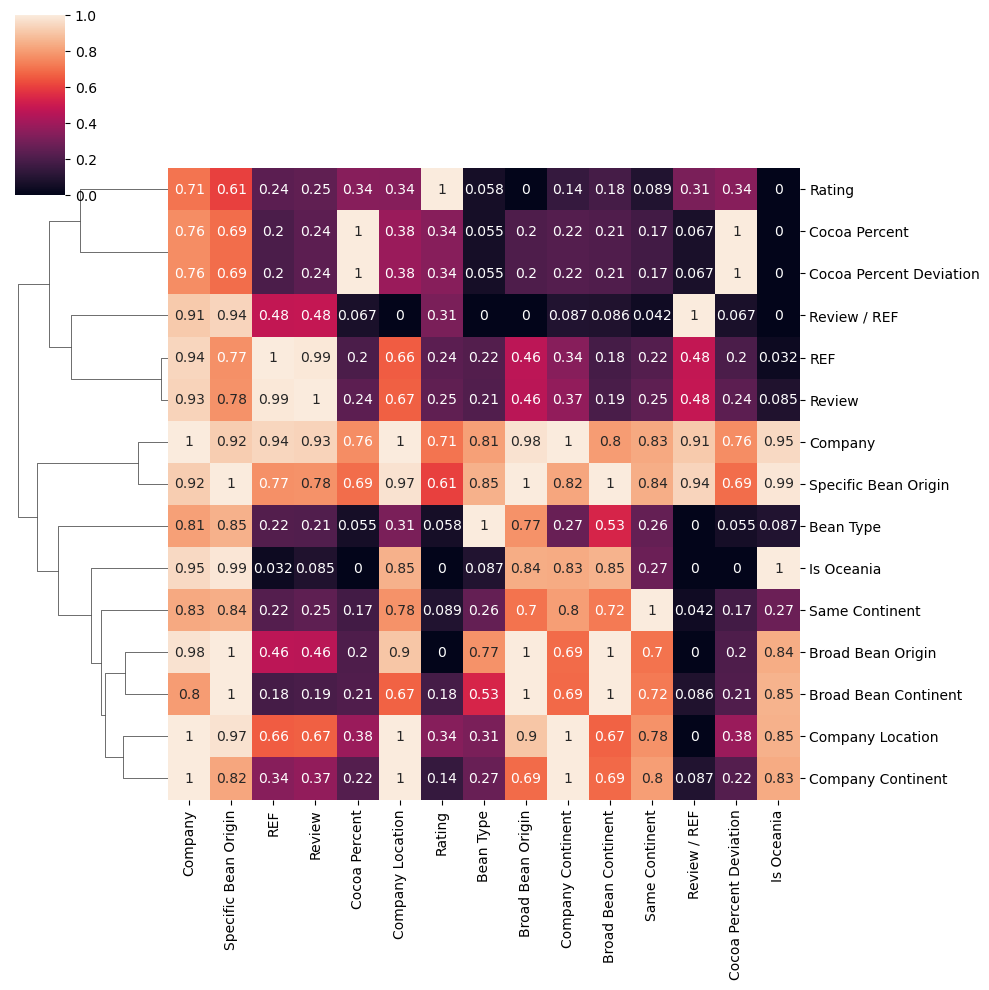

In [ ]:
sns.clustermap(phik_overview, annot=True, col_cluster=False)

90360

In [ ]:
X_train = train[cols]
y_train = np.log(train['Rating'])
X_test = test[cols]

In [ ]:
cat_features = [i for i, col in enumerate(X.columns) if X[col].dtype.name in ['category', 'object']]

In [ ]:
def objective_catboost(trial):

    params = {
        'max_depth': 4,
        'learning_rate': trial.suggest_float("learning_rate", 0.0005, 0.2, log=True),    # Скорость обучения
        'n_estimators': trial.suggest_int("n_estimators", 1800, 3000),
        'l2_leaf_reg': trial.suggest_float("l2_leaf_reg", 1, 10),   # Коэффициент L2-регуляризации
        'random_strength': trial.suggest_float("random_strength", 0, 10),   # Степень случайности
        'bagging_temperature':  trial.suggest_float("bagging_temperature", 0, 1),   # Интенсивность бэггинга
        'grow_policy': 'SymmetricTree',
        # 'border_count': trial.suggest_int("border_count", 32, 255)
        # 'iterations': trial.suggest_int('iterations', 100, 300),  # Количество итераций
        # 'depth': trial.suggest_int('depth', 3, 4, 5),  # Глубина деревьев
        # 'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.2),  # Скорость обучения
        # 'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 4, 8),  # Коэффициент L2-регуляризации
        # 'loss_function': trial.suggest_categorical('loss_function', ['RMSE', 'MAE']),  # Функция потерь
        # 'early_stopping_rounds': trial.suggest_int('early_stopping_rounds', 10, 20),  # Ранняя остановка
        # 'border_count': trial.suggest_categorical('border_count', [32, 128]),  # Количество границ
        # 'random_strength': trial.suggest_float('random_strength', 0.1, 10),  # Степень случайности
        # 'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),  # Интенсивность бэггинга
        # 'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise']),    # Стратегия роста
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 15),   # Минимальное количество объектов в листе
        'rsm': trial.suggest_float('rsm', 0.8, 1.0),    # Доля признаков для каждого дерева

    }
    
    model = CatBoostRegressor(cat_features=cat_features, **params, silent=True)

    score = cross_val_score(model, X, y, cv=3, scoring="r2", n_jobs=-1).mean()
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective_catboost, n_trials=5, n_jobs=-1)

[I 2025-11-16 10:18:50,338] A new study created in memory with name: no-name-5f585193-f634-4508-b81c-885f83a8acd5
[I 2025-11-16 10:19:58,144] Trial 0 finished with value: 0.20019744289984495 and parameters: {'learning_rate': 0.012742680805076451, 'n_estimators': 2112, 'l2_leaf_reg': 3.535541608864987, 'random_strength': 0.05212478790448172, 'bagging_temperature': 0.9900408655718266, 'min_data_in_leaf': 13, 'rsm': 0.8470317046691513}. Best is trial 0 with value: 0.20019744289984495.
[I 2025-11-16 10:20:05,489] Trial 10 finished with value: 0.14514465374494237 and parameters: {'learning_rate': 0.001901045298754066, 'n_estimators': 2600, 'l2_leaf_reg': 2.8696388099157852, 'random_strength': 9.133456327804412, 'bagging_temperature': 0.9008790389441511, 'min_data_in_leaf': 8, 'rsm': 0.9706997138474829}. Best is trial 0 with value: 0.20019744289984495.
[I 2025-11-16 10:20:14,130] Trial 1 finished with value: 0.21747478801278744 and parameters: {'learning_rate': 0.006000405879717112, 'n_estim

In [ ]:
# Best is trial 158 with value: 0.2238632257309918.

In [ ]:
params = study.best_params
params

In [ ]:
params = study.best_params

model = CatBoostRegressor(
        cat_features=cat_features, **params,
        silent=True
    )
model.fit(X, y)
model.get_params()
pred = model.predict(test)
test = test.copy()
result = pd.DataFrame()
result['id'] = np.arange(len(test))
result['Rating'] = np.exp(pred)

result[['id','Rating']].to_csv("choko_submission_105.csv", index=False)

In [ ]:
result = pd.read_csv('choko_submission_101.csv')
# result['id'] = np.arange(len(X_test))
result['Rating'] = np.exp(result['Rating'])

result[['id','Rating']].to_csv("choko_submission_111.csv", index=False)

In [ ]:
result = pd.read_csv('choko_submission_111.csv')
result

,id,Rating
0,0,3.089433
1,1,3.070250
2,2,3.087707
3,3,3.408687
4,4,2.890714
...,...,...
535,535,3.093728
536,536,3.317151
537,537,3.456239
538,538,2.973625


In [ ]:
#2
cols = ['Company', 'Specific Bean Origin', 'REF', 'Review', 'Cocoa Percent',
'Company Location', 'Bean Type', 'Broad Bean Origin', 
'Same Continent', 'Review / REF', 'Cocoa Percent Deviation']

In [ ]:
X = train[cols]
y = train['Rating']
# y = train['Rating']
# test = test[cols]

In [ ]:
cat_features = [i for i, col in enumerate(X.columns) if X[col].dtype.name in ['category', 'object']]

In [ ]:
def objective_catboost(trial):

    params = {
        'max_depth': 4,
        'learning_rate': trial.suggest_float("learning_rate", 0.0005, 0.2, log=True),    # Скорость обучения
        'n_estimators': trial.suggest_int("n_estimators", 1800, 3000),
        'l2_leaf_reg': trial.suggest_float("l2_leaf_reg", 1, 10),   # Коэффициент L2-регуляризации
        'random_strength': trial.suggest_float("random_strength", 0, 10),   # Степень случайности
        'bagging_temperature':  trial.suggest_float("bagging_temperature", 0, 1),   # Интенсивность бэггинга
        'grow_policy': 'SymmetricTree',
        # 'border_count': trial.suggest_int("border_count", 32, 255)
        # 'iterations': trial.suggest_int('iterations', 100, 300),  # Количество итераций
        # 'depth': trial.suggest_int('depth', 3, 4, 5),  # Глубина деревьев
        # 'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.2),  # Скорость обучения
        # 'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 4, 8),  # Коэффициент L2-регуляризации
        # 'loss_function': trial.suggest_categorical('loss_function', ['RMSE', 'MAE']),  # Функция потерь
        # 'early_stopping_rounds': trial.suggest_int('early_stopping_rounds', 10, 20),  # Ранняя остановка
        # 'border_count': trial.suggest_categorical('border_count', [32, 128]),  # Количество границ
        # 'random_strength': trial.suggest_float('random_strength', 0.1, 10),  # Степень случайности
        # 'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),  # Интенсивность бэггинга
        # 'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise']),    # Стратегия роста
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 15),   # Минимальное количество объектов в листе
        'rsm': trial.suggest_float('rsm', 0.8, 1.0),    # Доля признаков для каждого дерева

    }
    
    model = CatBoostRegressor(cat_features=cat_features, **params, silent=True)

    score = cross_val_score(model, X, y, cv=3, scoring="r2", n_jobs=-1).mean()
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective_catboost, n_trials=400, n_jobs=-1)

In [ ]:
# Best is trial 394 with value: 0.21109776942446004.

In [ ]:
params = study.best_params
params

In [ ]:
params = study.best_params

model = CatBoostRegressor(
        cat_features=cat_features, **params,
        silent=True
    )
model.fit(X, y)
model.get_params()
pred = model.predict(X_test)
result = pd.DataFrame()
result['id'] = np.arange(len(X_test))
result['Rating'] = np.exp(pred)

result[['id','Rating']].to_csv("choko_submission_102.csv", index=False)

In [ ]:
#1 log
cols = ['Company', 'Specific Bean Origin', 'REF', 'Review', 'Cocoa Percent',
'Company Location', 'Bean Type', 'Broad Bean Origin', 
'Continent Company Location', 'Continent Broad Bean Origin', 'Same Continent', 'Review / REF', 'Is Oceania', 'Cocoa Percent Deviation']

In [ ]:
X = train[cols]
y = np.log(train['Rating'])
# y = train['Rating']
# test = test[cols]

In [ ]:
cat_features = [i for i, col in enumerate(X.columns) if X[col].dtype.name in ['category', 'object']]

In [ ]:
def objective_catboost(trial):

    params = {
        'max_depth': 4,
        'learning_rate': trial.suggest_float("learning_rate", 0.0005, 0.2, log=True),    # Скорость обучения
        'n_estimators': trial.suggest_int("n_estimators", 1800, 3000),
        'l2_leaf_reg': trial.suggest_float("l2_leaf_reg", 1, 10),   # Коэффициент L2-регуляризации
        'random_strength': trial.suggest_float("random_strength", 0, 10),   # Степень случайности
        'bagging_temperature':  trial.suggest_float("bagging_temperature", 0, 1),   # Интенсивность бэггинга
        'grow_policy': 'SymmetricTree',
        # 'border_count': trial.suggest_int("border_count", 32, 255)
        # 'iterations': trial.suggest_int('iterations', 100, 300),  # Количество итераций
        # 'depth': trial.suggest_int('depth', 3, 4, 5),  # Глубина деревьев
        # 'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.2),  # Скорость обучения
        # 'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 4, 8),  # Коэффициент L2-регуляризации
        # 'loss_function': trial.suggest_categorical('loss_function', ['RMSE', 'MAE']),  # Функция потерь
        # 'early_stopping_rounds': trial.suggest_int('early_stopping_rounds', 10, 20),  # Ранняя остановка
        # 'border_count': trial.suggest_categorical('border_count', [32, 128]),  # Количество границ
        # 'random_strength': trial.suggest_float('random_strength', 0.1, 10),  # Степень случайности
        # 'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),  # Интенсивность бэггинга
        # 'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise']),    # Стратегия роста
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 15),   # Минимальное количество объектов в листе
        'rsm': trial.suggest_float('rsm', 0.8, 1.0),    # Доля признаков для каждого дерева

    }
    
    model = CatBoostRegressor(cat_features=cat_features, **params, silent=True)

    score = cross_val_score(model, X, y, cv=3, scoring="r2", n_jobs=-1).mean()
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective_catboost, n_trials=400, n_jobs=-1)

[I 2025-11-16 06:05:45,174] A new study created in memory with name: no-name-1d406b54-57ed-4366-a6f9-5d6cb2e08263
[I 2025-11-16 06:07:07,514] Trial 2 finished with value: 0.21252571684606444 and parameters: {'learning_rate': 0.00596682643479189, 'n_estimators': 2915, 'l2_leaf_reg': 1.7167067665447875, 'random_strength': 6.158020940766935, 'bagging_temperature': 0.6800348374640829, 'min_data_in_leaf': 14, 'rsm': 0.8021207025463584}. Best is trial 2 with value: 0.21252571684606444.
[I 2025-11-16 06:07:47,988] Trial 6 finished with value: 0.13246525642546814 and parameters: {'learning_rate': 0.000672758369948588, 'n_estimators': 2424, 'l2_leaf_reg': 2.1532225253934985, 'random_strength': 1.9682710094112943, 'bagging_temperature': 0.6809435837850526, 'min_data_in_leaf': 10, 'rsm': 0.9718193191472851}. Best is trial 2 with value: 0.21252571684606444.
[I 2025-11-16 06:07:55,685] Trial 0 finished with value: 0.1338244655731178 and parameters: {'learning_rate': 0.09142789325792203, 'n_estimato

In [ ]:
# Best is trial 234 with value: 0.2187189636297209.

In [ ]:
params = study.best_params
params
# {'learning_rate': 0.003733914765515183,
#  'n_estimators': 2912,
#  'l2_leaf_reg': 1.1881313427981934,
#  'random_strength': 0.9928426619662443,
#  'bagging_temperature': 0.029036838269319902,
#  'min_data_in_leaf': 13,
#  'rsm': 0.8991675984923386}

{'learning_rate': 0.003733914765515183,
 'n_estimators': 2912,
 'l2_leaf_reg': 1.1881313427981934,
 'random_strength': 0.9928426619662443,
 'bagging_temperature': 0.029036838269319902,
 'min_data_in_leaf': 13,
 'rsm': 0.8991675984923386}

In [ ]:
# params = study.best_params

# model = CatBoostRegressor(
#         cat_features=cat_features, **params,
#         silent=True
#     )
# model.fit(X, y)
# model.get_params()
# pred = model.predict(test)
# test = test.copy()
# result = pd.DataFrame()
# result['id'] = np.arange(len(test))
# result['Rating'] = pred

# result[['id','Rating']].to_csv("choko_submission_103.csv", index=False)

In [ ]:
#1
cols = ['Company', 'Specific Bean Origin', 'REF', 'Review', 'Cocoa Percent',
'Company Location', 'Bean Type', 'Broad Bean Origin', 
'Continent Company Location', 'Continent Broad Bean Origin', 'Same Continent', 'Review / REF', 'Is Oceania', 'Cocoa Percent Deviation']

In [ ]:
X = train[cols]
y = train['Rating']
# y = train['Rating']
# test = test[cols]

In [ ]:
cat_features = [i for i, col in enumerate(X.columns) if X[col].dtype.name in ['category', 'object']]

In [ ]:
def objective_catboost(trial):

    params = {
        'max_depth': 4,
        'learning_rate': trial.suggest_float("learning_rate", 0.0005, 0.2, log=True),    # Скорость обучения
        'n_estimators': trial.suggest_int("n_estimators", 1800, 3000),
        'l2_leaf_reg': trial.suggest_float("l2_leaf_reg", 1, 10),   # Коэффициент L2-регуляризации
        'random_strength': trial.suggest_float("random_strength", 0, 10),   # Степень случайности
        'bagging_temperature':  trial.suggest_float("bagging_temperature", 0, 1),   # Интенсивность бэггинга
        'grow_policy': 'SymmetricTree',
        # 'border_count': trial.suggest_int("border_count", 32, 255)
        # 'iterations': trial.suggest_int('iterations', 100, 300),  # Количество итераций
        # 'depth': trial.suggest_int('depth', 3, 4, 5),  # Глубина деревьев
        # 'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.2),  # Скорость обучения
        # 'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 4, 8),  # Коэффициент L2-регуляризации
        # 'loss_function': trial.suggest_categorical('loss_function', ['RMSE', 'MAE']),  # Функция потерь
        # 'early_stopping_rounds': trial.suggest_int('early_stopping_rounds', 10, 20),  # Ранняя остановка
        # 'border_count': trial.suggest_categorical('border_count', [32, 128]),  # Количество границ
        # 'random_strength': trial.suggest_float('random_strength', 0.1, 10),  # Степень случайности
        # 'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),  # Интенсивность бэггинга
        # 'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise']),    # Стратегия роста
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 15),   # Минимальное количество объектов в листе
        'rsm': trial.suggest_float('rsm', 0.8, 1.0),    # Доля признаков для каждого дерева

    }
    
    model = CatBoostRegressor(cat_features=cat_features, **params, silent=True)

    score = cross_val_score(model, X, y, cv=3, scoring="r2", n_jobs=-1).mean()
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective_catboost, n_trials=400, n_jobs=-1)

[I 2025-11-16 07:12:54,370] A new study created in memory with name: no-name-b3673ef3-81c3-4925-9dee-9d946b5f7ebe
[I 2025-11-16 07:14:02,762] Trial 0 finished with value: 0.10582898378830119 and parameters: {'learning_rate': 0.000793377306658876, 'n_estimators': 2454, 'l2_leaf_reg': 5.698913411725497, 'random_strength': 3.787110762665243, 'bagging_temperature': 0.07244370341409734, 'min_data_in_leaf': 13, 'rsm': 0.9733095932242338}. Best is trial 0 with value: 0.10582898378830119.
[I 2025-11-16 07:14:07,416] Trial 2 finished with value: 0.12165709737795427 and parameters: {'learning_rate': 0.0012203879853475061, 'n_estimators': 2731, 'l2_leaf_reg': 1.9408897432530492, 'random_strength': 6.986287483285363, 'bagging_temperature': 0.7434229741114395, 'min_data_in_leaf': 6, 'rsm': 0.9905493558869334}. Best is trial 2 with value: 0.12165709737795427.
[I 2025-11-16 07:14:11,140] Trial 5 finished with value: 0.16933338091452 and parameters: {'learning_rate': 0.048305633906797985, 'n_estimator

In [ ]:
# Best is trial 386 with value: 0.207989339889289.

In [ ]:
params = study.best_params
params
# {'learning_rate': 0.009296791684009065,
#  'n_estimators': 2055,
#  'l2_leaf_reg': 1.1961294464116703,
#  'random_strength': 8.657769512276648,
#  'bagging_temperature': 0.8665547221364935,
#  'min_data_in_leaf': 14,
#  'rsm': 0.8220823132727318}

{'learning_rate': 0.009296791684009065,
 'n_estimators': 2055,
 'l2_leaf_reg': 1.1961294464116703,
 'random_strength': 8.657769512276648,
 'bagging_temperature': 0.8665547221364935,
 'min_data_in_leaf': 14,
 'rsm': 0.8220823132727318}

In [ ]:
# params = study.best_params

# model = CatBoostRegressor(
#         cat_features=cat_features, **params,
#         silent=True
#     )
# model.fit(X, y)
# model.get_params()
# pred = model.predict(test)
# test = test.copy()
# result = pd.DataFrame()
# result['id'] = np.arange(len(test))
# result['Rating'] = pred

# result[['id','Rating']].to_csv("choko_submission_104.csv", index=False)

In [ ]:
#3 log
cols = ['Company', 'Specific Bean Origin', 'REF', 'Review', 'Cocoa Percent',
'Company Location', 'Bean Type', 'Broad Bean Origin', 
'Continent Company Location', 'Same Continent', 'Review / REF', 'Cocoa Percent Deviation']

In [ ]:
X = train[cols]
y = np.log(train['Rating'])
# y = train['Rating']
test = test[cols]

In [ ]:
cat_features = [i for i, col in enumerate(X.columns) if X[col].dtype.name in ['category', 'object']]

In [ ]:
def objective_catboost(trial):

    params = {
        'max_depth': 4,
        'learning_rate': trial.suggest_float("learning_rate", 0.0005, 0.2, log=True),    # Скорость обучения
        'n_estimators': trial.suggest_int("n_estimators", 1800, 3000),
        'l2_leaf_reg': trial.suggest_float("l2_leaf_reg", 1, 10),   # Коэффициент L2-регуляризации
        'random_strength': trial.suggest_float("random_strength", 0, 10),   # Степень случайности
        'bagging_temperature':  trial.suggest_float("bagging_temperature", 0, 1),   # Интенсивность бэггинга
        'grow_policy': 'SymmetricTree',
        # 'border_count': trial.suggest_int("border_count", 32, 255)
        # 'iterations': trial.suggest_int('iterations', 100, 300),  # Количество итераций
        # 'depth': trial.suggest_int('depth', 3, 4, 5),  # Глубина деревьев
        # 'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.2),  # Скорость обучения
        # 'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 4, 8),  # Коэффициент L2-регуляризации
        # 'loss_function': trial.suggest_categorical('loss_function', ['RMSE', 'MAE']),  # Функция потерь
        # 'early_stopping_rounds': trial.suggest_int('early_stopping_rounds', 10, 20),  # Ранняя остановка
        # 'border_count': trial.suggest_categorical('border_count', [32, 128]),  # Количество границ
        # 'random_strength': trial.suggest_float('random_strength', 0.1, 10),  # Степень случайности
        # 'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),  # Интенсивность бэггинга
        # 'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise']),    # Стратегия роста
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 15),   # Минимальное количество объектов в листе
        'rsm': trial.suggest_float('rsm', 0.8, 1.0),    # Доля признаков для каждого дерева

    }
    
    model = CatBoostRegressor(cat_features=cat_features, **params, silent=True)

    score = cross_val_score(model, X, y, cv=3, scoring="r2", n_jobs=-1).mean()
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective_catboost, n_trials=400, n_jobs=-1)

[I 2025-11-16 08:10:35,958] A new study created in memory with name: no-name-d56d005a-637d-4fd8-8602-f7ec754b2719
[I 2025-11-16 08:11:26,046] Trial 1 finished with value: 0.09829926252664567 and parameters: {'learning_rate': 0.000567028800200595, 'n_estimators': 1815, 'l2_leaf_reg': 3.6339841994634594, 'random_strength': 1.7271945045641712, 'bagging_temperature': 0.23970109623639912, 'min_data_in_leaf': 8, 'rsm': 0.9036904397225322}. Best is trial 1 with value: 0.09829926252664567.
[I 2025-11-16 08:11:32,109] Trial 0 finished with value: 0.2057444729314786 and parameters: {'learning_rate': 0.011684318715491946, 'n_estimators': 1956, 'l2_leaf_reg': 7.212898631852738, 'random_strength': 6.301160544396305, 'bagging_temperature': 0.06450585684113752, 'min_data_in_leaf': 10, 'rsm': 0.8588449981892746}. Best is trial 0 with value: 0.2057444729314786.
[I 2025-11-16 08:11:34,494] Trial 3 finished with value: 0.15549941844663062 and parameters: {'learning_rate': 0.002927936067569354, 'n_estimat

In [ ]:
# Best is trial 268 with value: 0.2229410243695933.

In [ ]:
# params = study.best_params
params = {'learning_rate': 0.005871558990476109,
 'n_estimators': 1921,
 'l2_leaf_reg': 1.373134743261065,
 'random_strength': 2.1454001996086878,
 'bagging_temperature': 0.6175751726125848,
 'min_data_in_leaf': 11,
 'rsm': 0.9108772330152726}

In [ ]:
# params = study.best_params

model = CatBoostRegressor(
        cat_features=cat_features, **params,
        silent=True
    )
model.fit(X, y)
model.get_params()
pred = model.predict(test)
test = test.copy()
result = pd.DataFrame()
result['id'] = np.arange(len(test))
result['Rating'] = np.exp(pred)

result[['id','Rating']].to_csv("choko_submission_105.csv", index=False)

In [ ]:
#3
cols = ['Company', 'Specific Bean Origin', 'REF', 'Review', 'Cocoa Percent',
'Company Location', 'Bean Type', 'Broad Bean Origin', 
'Continent Company Location', 'Same Continent', 'Review / REF', 'Cocoa Percent Deviation']

In [ ]:
X = train[cols]
y = train['Rating']
# y = train['Rating']
# test = test[cols]

In [ ]:
cat_features = [i for i, col in enumerate(X.columns) if X[col].dtype.name in ['category', 'object']]

In [ ]:
def objective_catboost(trial):

    params = {
        'max_depth': 4,
        'learning_rate': trial.suggest_float("learning_rate", 0.0005, 0.2, log=True),    # Скорость обучения
        'n_estimators': trial.suggest_int("n_estimators", 1800, 3000),
        'l2_leaf_reg': trial.suggest_float("l2_leaf_reg", 1, 10),   # Коэффициент L2-регуляризации
        'random_strength': trial.suggest_float("random_strength", 0, 10),   # Степень случайности
        'bagging_temperature':  trial.suggest_float("bagging_temperature", 0, 1),   # Интенсивность бэггинга
        'grow_policy': 'SymmetricTree',
        # 'border_count': trial.suggest_int("border_count", 32, 255)
        # 'iterations': trial.suggest_int('iterations', 100, 300),  # Количество итераций
        # 'depth': trial.suggest_int('depth', 3, 4, 5),  # Глубина деревьев
        # 'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.2),  # Скорость обучения
        # 'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 4, 8),  # Коэффициент L2-регуляризации
        # 'loss_function': trial.suggest_categorical('loss_function', ['RMSE', 'MAE']),  # Функция потерь
        # 'early_stopping_rounds': trial.suggest_int('early_stopping_rounds', 10, 20),  # Ранняя остановка
        # 'border_count': trial.suggest_categorical('border_count', [32, 128]),  # Количество границ
        # 'random_strength': trial.suggest_float('random_strength', 0.1, 10),  # Степень случайности
        # 'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),  # Интенсивность бэггинга
        # 'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise']),    # Стратегия роста
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 15),   # Минимальное количество объектов в листе
        'rsm': trial.suggest_float('rsm', 0.8, 1.0),    # Доля признаков для каждого дерева

    }
    
    model = CatBoostRegressor(cat_features=cat_features, **params, silent=True)

    score = cross_val_score(model, X, y, cv=3, scoring="r2", n_jobs=-1).mean()
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective_catboost, n_trials=400, n_jobs=-1)

[I 2025-11-16 09:04:10,596] A new study created in memory with name: no-name-b5fecf9e-c4c9-4eba-a3b7-c47fac7fef5d
[I 2025-11-16 09:05:01,525] Trial 2 finished with value: 0.18035127826200079 and parameters: {'learning_rate': 0.04328807566853015, 'n_estimators': 1802, 'l2_leaf_reg': 8.942618754227201, 'random_strength': 1.072511186868056, 'bagging_temperature': 0.0839385037759891, 'min_data_in_leaf': 15, 'rsm': 0.8559142290066267}. Best is trial 2 with value: 0.18035127826200079.
[I 2025-11-16 09:05:10,799] Trial 0 finished with value: 0.09581119197826038 and parameters: {'learning_rate': 0.000567735337235138, 'n_estimators': 2274, 'l2_leaf_reg': 7.095678393675744, 'random_strength': 2.3857647222607135, 'bagging_temperature': 0.2819477160704569, 'min_data_in_leaf': 13, 'rsm': 0.8730160660544455}. Best is trial 2 with value: 0.18035127826200079.
[I 2025-11-16 09:05:10,880] Trial 1 finished with value: 0.19196750493149384 and parameters: {'learning_rate': 0.0380633157881874, 'n_estimators

In [ ]:
params = study.best_params
params

In [ ]:
# params = study.best_params

# model = CatBoostRegressor(
#         cat_features=cat_features, **params,
#         silent=True
#     )
# model.fit(X, y)
# model.get_params()
# pred = model.predict(test)
# test = test.copy()
# result = pd.DataFrame()
# result['id'] = np.arange(len(test))
# result['Rating'] = pred

# result[['id','Rating']].to_csv("choko_submission_106.csv", index=False)

NameError: name 'study' is not defined

In [ ]:
#4 log
cols = ['Company', 'Specific Bean Origin', 'REF', 'Cocoa Percent',
'Company Location', 'Bean Type', 'Broad Bean Origin', 
'Continent Company Location', 'Continent Broad Bean Origin', 'Same Continent', 'Review / REF', 'Is Oceania', 'Cocoa Percent Deviation']

In [ ]:
X = train[cols]
y = np.log(train['Rating'])
# y = train['Rating']
# test = test[cols]

In [ ]:
cat_features = [i for i, col in enumerate(X.columns) if X[col].dtype.name in ['category', 'object']]

In [ ]:
def objective_catboost(trial):

    params = {
        'max_depth': 4,
        'learning_rate': trial.suggest_float("learning_rate", 0.0005, 0.2, log=True),    # Скорость обучения
        'n_estimators': trial.suggest_int("n_estimators", 1800, 3000),
        'l2_leaf_reg': trial.suggest_float("l2_leaf_reg", 1, 10),   # Коэффициент L2-регуляризации
        'random_strength': trial.suggest_float("random_strength", 0, 10),   # Степень случайности
        'bagging_temperature':  trial.suggest_float("bagging_temperature", 0, 1),   # Интенсивность бэггинга
        'grow_policy': 'SymmetricTree',
        # 'border_count': trial.suggest_int("border_count", 32, 255)
        # 'iterations': trial.suggest_int('iterations', 100, 300),  # Количество итераций
        # 'depth': trial.suggest_int('depth', 3, 4, 5),  # Глубина деревьев
        # 'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.2),  # Скорость обучения
        # 'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 4, 8),  # Коэффициент L2-регуляризации
        # 'loss_function': trial.suggest_categorical('loss_function', ['RMSE', 'MAE']),  # Функция потерь
        # 'early_stopping_rounds': trial.suggest_int('early_stopping_rounds', 10, 20),  # Ранняя остановка
        # 'border_count': trial.suggest_categorical('border_count', [32, 128]),  # Количество границ
        # 'random_strength': trial.suggest_float('random_strength', 0.1, 10),  # Степень случайности
        # 'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),  # Интенсивность бэггинга
        # 'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise']),    # Стратегия роста
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 15),   # Минимальное количество объектов в листе
        'rsm': trial.suggest_float('rsm', 0.8, 1.0),    # Доля признаков для каждого дерева

    }
    
    model = CatBoostRegressor(cat_features=cat_features, **params, silent=True)

    score = cross_val_score(model, X, y, cv=3, scoring="r2", n_jobs=-1).mean()
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective_catboost, n_trials=400, n_jobs=-1)

In [ ]:
params = study.best_params
params

In [ ]:
# params = study.best_params

# model = CatBoostRegressor(
#         cat_features=cat_features, **params,
#         silent=True
#     )
# model.fit(X, y)
# model.get_params()
# pred = model.predict(test)
# test = test.copy()
# result = pd.DataFrame()
# result['id'] = np.arange(len(test))
# result['Rating'] = pred

# result[['id','Rating']].to_csv("choko_submission_107.csv", index=False)

In [ ]:
#4
cols = ['Company', 'Specific Bean Origin', 'REF', 'Cocoa Percent',
'Company Location', 'Bean Type', 'Broad Bean Origin', 
'Continent Company Location', 'Continent Broad Bean Origin', 'Same Continent', 'Review / REF', 'Is Oceania', 'Cocoa Percent Deviation']

In [ ]:
X = train[cols]
y = train['Rating']
# y = train['Rating']
# test = test[cols]

In [ ]:
cat_features = [i for i, col in enumerate(X.columns) if X[col].dtype.name in ['category', 'object']]

In [ ]:
def objective_catboost(trial):

    params = {
        'max_depth': 4,
        'learning_rate': trial.suggest_float("learning_rate", 0.0005, 0.2, log=True),    # Скорость обучения
        'n_estimators': trial.suggest_int("n_estimators", 1800, 3000),
        'l2_leaf_reg': trial.suggest_float("l2_leaf_reg", 1, 10),   # Коэффициент L2-регуляризации
        'random_strength': trial.suggest_float("random_strength", 0, 10),   # Степень случайности
        'bagging_temperature':  trial.suggest_float("bagging_temperature", 0, 1),   # Интенсивность бэггинга
        'grow_policy': 'SymmetricTree',
        # 'border_count': trial.suggest_int("border_count", 32, 255)
        # 'iterations': trial.suggest_int('iterations', 100, 300),  # Количество итераций
        # 'depth': trial.suggest_int('depth', 3, 4, 5),  # Глубина деревьев
        # 'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.2),  # Скорость обучения
        # 'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 4, 8),  # Коэффициент L2-регуляризации
        # 'loss_function': trial.suggest_categorical('loss_function', ['RMSE', 'MAE']),  # Функция потерь
        # 'early_stopping_rounds': trial.suggest_int('early_stopping_rounds', 10, 20),  # Ранняя остановка
        # 'border_count': trial.suggest_categorical('border_count', [32, 128]),  # Количество границ
        # 'random_strength': trial.suggest_float('random_strength', 0.1, 10),  # Степень случайности
        # 'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),  # Интенсивность бэггинга
        # 'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise']),    # Стратегия роста
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 15),   # Минимальное количество объектов в листе
        'rsm': trial.suggest_float('rsm', 0.8, 1.0),    # Доля признаков для каждого дерева

    }
    
    model = CatBoostRegressor(cat_features=cat_features, **params, silent=True)

    score = cross_val_score(model, X, y, cv=3, scoring="r2", n_jobs=-1).mean()
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective_catboost, n_trials=400, n_jobs=-1)

In [ ]:
params = study.best_params
params

In [ ]:
# params = study.best_params

# model = CatBoostRegressor(
#         cat_features=cat_features, **params,
#         silent=True
#     )
# model.fit(X, y)
# model.get_params()
# pred = model.predict(test)
# test = test.copy()
# result = pd.DataFrame()
# result['id'] = np.arange(len(test))
# result['Rating'] = pred

# result[['id','Rating']].to_csv("choko_submission_108.csv", index=False)

In [ ]:
#5 log
cols = ['Company', 'Specific Bean Origin', 'REF', 'Cocoa Percent',
'Company Location', 'Bean Type', 'Broad Bean Origin', 
'Continent Company Location', 'Continent Broad Bean Origin', 'Same Continent', 'Review / REF', 'Cocoa Percent Deviation']

In [ ]:
X = train[cols]
y = np.log(train['Rating'])
# y = train['Rating']
# test = test[cols]

In [ ]:
cat_features = [i for i, col in enumerate(X.columns) if X[col].dtype.name in ['category', 'object']]

In [ ]:
def objective_catboost(trial):

    params = {
        'max_depth': 4,
        'learning_rate': trial.suggest_float("learning_rate", 0.0005, 0.2, log=True),    # Скорость обучения
        'n_estimators': trial.suggest_int("n_estimators", 1800, 3000),
        'l2_leaf_reg': trial.suggest_float("l2_leaf_reg", 1, 10),   # Коэффициент L2-регуляризации
        'random_strength': trial.suggest_float("random_strength", 0, 10),   # Степень случайности
        'bagging_temperature':  trial.suggest_float("bagging_temperature", 0, 1),   # Интенсивность бэггинга
        'grow_policy': 'SymmetricTree',
        # 'border_count': trial.suggest_int("border_count", 32, 255)
        # 'iterations': trial.suggest_int('iterations', 100, 300),  # Количество итераций
        # 'depth': trial.suggest_int('depth', 3, 4, 5),  # Глубина деревьев
        # 'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.2),  # Скорость обучения
        # 'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 4, 8),  # Коэффициент L2-регуляризации
        # 'loss_function': trial.suggest_categorical('loss_function', ['RMSE', 'MAE']),  # Функция потерь
        # 'early_stopping_rounds': trial.suggest_int('early_stopping_rounds', 10, 20),  # Ранняя остановка
        # 'border_count': trial.suggest_categorical('border_count', [32, 128]),  # Количество границ
        # 'random_strength': trial.suggest_float('random_strength', 0.1, 10),  # Степень случайности
        # 'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),  # Интенсивность бэггинга
        # 'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise']),    # Стратегия роста
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 15),   # Минимальное количество объектов в листе
        'rsm': trial.suggest_float('rsm', 0.8, 1.0),    # Доля признаков для каждого дерева

    }
    
    model = CatBoostRegressor(cat_features=cat_features, **params, silent=True)

    score = cross_val_score(model, X, y, cv=3, scoring="r2", n_jobs=-1).mean()
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective_catboost, n_trials=400, n_jobs=-1)

In [ ]:
params = study.best_params
params

In [ ]:
# params = study.best_params

# model = CatBoostRegressor(
#         cat_features=cat_features, **params,
#         silent=True
#     )
# model.fit(X, y)
# model.get_params()
# pred = model.predict(test)
# test = test.copy()
# result = pd.DataFrame()
# result['id'] = np.arange(len(test))
# result['Rating'] = pred

# result[['id','Rating']].to_csv("choko_submission_109.csv", index=False)

In [ ]:
#5
cols = ['Company', 'Specific Bean Origin', 'REF', 'Cocoa Percent',
'Company Location', 'Bean Type', 'Broad Bean Origin', 
'Continent Company Location', 'Continent Broad Bean Origin', 'Same Continent', 'Review / REF', 'Cocoa Percent Deviation']

In [ ]:
X = train[cols]
y = train['Rating']
# y = train['Rating']
# test = test[cols]

In [ ]:
cat_features = [i for i, col in enumerate(X.columns) if X[col].dtype.name in ['category', 'object']]

In [ ]:
def objective_catboost(trial):

    params = {
        'max_depth': 4,
        'learning_rate': trial.suggest_float("learning_rate", 0.0005, 0.2, log=True),    # Скорость обучения
        'n_estimators': trial.suggest_int("n_estimators", 1800, 3000),
        'l2_leaf_reg': trial.suggest_float("l2_leaf_reg", 1, 10),   # Коэффициент L2-регуляризации
        'random_strength': trial.suggest_float("random_strength", 0, 10),   # Степень случайности
        'bagging_temperature':  trial.suggest_float("bagging_temperature", 0, 1),   # Интенсивность бэггинга
        'grow_policy': 'SymmetricTree',
        # 'border_count': trial.suggest_int("border_count", 32, 255)
        # 'iterations': trial.suggest_int('iterations', 100, 300),  # Количество итераций
        # 'depth': trial.suggest_int('depth', 3, 4, 5),  # Глубина деревьев
        # 'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.2),  # Скорость обучения
        # 'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 4, 8),  # Коэффициент L2-регуляризации
        # 'loss_function': trial.suggest_categorical('loss_function', ['RMSE', 'MAE']),  # Функция потерь
        # 'early_stopping_rounds': trial.suggest_int('early_stopping_rounds', 10, 20),  # Ранняя остановка
        # 'border_count': trial.suggest_categorical('border_count', [32, 128]),  # Количество границ
        # 'random_strength': trial.suggest_float('random_strength', 0.1, 10),  # Степень случайности
        # 'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),  # Интенсивность бэггинга
        # 'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise']),    # Стратегия роста
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 15),   # Минимальное количество объектов в листе
        'rsm': trial.suggest_float('rsm', 0.8, 1.0),    # Доля признаков для каждого дерева

    }
    
    model = CatBoostRegressor(cat_features=cat_features, **params, silent=True)

    score = cross_val_score(model, X, y, cv=3, scoring="r2", n_jobs=-1).mean()
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective_catboost, n_trials=400, n_jobs=-1)

In [ ]:
params = study.best_params
params

In [ ]:
# params = study.best_params

# model = CatBoostRegressor(
#         cat_features=cat_features, **params,
#         silent=True
#     )
# model.fit(X, y)
# model.get_params()
# pred = model.predict(test)
# test = test.copy()
# result = pd.DataFrame()
# result['id'] = np.arange(len(test))
# result['Rating'] = pred

# result[['id','Rating']].to_csv("choko_submission_110.csv", index=False)

In [ ]:
#6 log
cols = ['Company', 'REF', 'Review', 'Cocoa Percent',
'Company Location', 'Bean Type', 'Broad Bean Origin', 
'Continent Company Location', 'Continent Broad Bean Origin', 'Same Continent', 'Review / REF', 'Cocoa Percent Deviation']

In [ ]:
X = train[cols]
y = np.log(train['Rating'])
# y = train['Rating']
# test = test[cols]

In [ ]:
cat_features = [i for i, col in enumerate(X.columns) if X[col].dtype.name in ['category', 'object']]

In [ ]:
def objective_catboost(trial):

    params = {
        'max_depth': 4,
        'learning_rate': trial.suggest_float("learning_rate", 0.0005, 0.2, log=True),    # Скорость обучения
        'n_estimators': trial.suggest_int("n_estimators", 1800, 3000),
        'l2_leaf_reg': trial.suggest_float("l2_leaf_reg", 1, 10),   # Коэффициент L2-регуляризации
        'random_strength': trial.suggest_float("random_strength", 0, 10),   # Степень случайности
        'bagging_temperature':  trial.suggest_float("bagging_temperature", 0, 1),   # Интенсивность бэггинга
        'grow_policy': 'SymmetricTree',
        # 'border_count': trial.suggest_int("border_count", 32, 255)
        # 'iterations': trial.suggest_int('iterations', 100, 300),  # Количество итераций
        # 'depth': trial.suggest_int('depth', 3, 4, 5),  # Глубина деревьев
        # 'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.2),  # Скорость обучения
        # 'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 4, 8),  # Коэффициент L2-регуляризации
        # 'loss_function': trial.suggest_categorical('loss_function', ['RMSE', 'MAE']),  # Функция потерь
        # 'early_stopping_rounds': trial.suggest_int('early_stopping_rounds', 10, 20),  # Ранняя остановка
        # 'border_count': trial.suggest_categorical('border_count', [32, 128]),  # Количество границ
        # 'random_strength': trial.suggest_float('random_strength', 0.1, 10),  # Степень случайности
        # 'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),  # Интенсивность бэггинга
        # 'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise']),    # Стратегия роста
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 15),   # Минимальное количество объектов в листе
        'rsm': trial.suggest_float('rsm', 0.8, 1.0),    # Доля признаков для каждого дерева

    }
    
    model = CatBoostRegressor(cat_features=cat_features, **params, silent=True)

    score = cross_val_score(model, X, y, cv=3, scoring="r2", n_jobs=-1).mean()
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective_catboost, n_trials=400, n_jobs=-1)

In [ ]:
params = study.best_params
params

In [ ]:
# params = study.best_params

# model = CatBoostRegressor(
#         cat_features=cat_features, **params,
#         silent=True
#     )
# model.fit(X, y)
# model.get_params()
# pred = model.predict(test)
# test = test.copy()
# result = pd.DataFrame()
# result['id'] = np.arange(len(test))
# result['Rating'] = pred

# result[['id','Rating']].to_csv("choko_submission_111.csv", index=False)

In [ ]:
#6
cols = ['Company', 'REF', 'Review', 'Cocoa Percent',
'Company Location', 'Bean Type', 'Broad Bean Origin', 
'Continent Company Location', 'Continent Broad Bean Origin', 'Same Continent', 'Review / REF', 'Cocoa Percent Deviation']

In [ ]:
X = train[cols]
y = train['Rating']
# y = train['Rating']
# test = test[cols]

In [ ]:
cat_features = [i for i, col in enumerate(X.columns) if X[col].dtype.name in ['category', 'object']]

In [ ]:
def objective_catboost(trial):

    params = {
        'max_depth': 4,
        'learning_rate': trial.suggest_float("learning_rate", 0.0005, 0.2, log=True),    # Скорость обучения
        'n_estimators': trial.suggest_int("n_estimators", 1800, 3000),
        'l2_leaf_reg': trial.suggest_float("l2_leaf_reg", 1, 10),   # Коэффициент L2-регуляризации
        'random_strength': trial.suggest_float("random_strength", 0, 10),   # Степень случайности
        'bagging_temperature':  trial.suggest_float("bagging_temperature", 0, 1),   # Интенсивность бэггинга
        'grow_policy': 'SymmetricTree',
        # 'border_count': trial.suggest_int("border_count", 32, 255)
        # 'iterations': trial.suggest_int('iterations', 100, 300),  # Количество итераций
        # 'depth': trial.suggest_int('depth', 3, 4, 5),  # Глубина деревьев
        # 'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.2),  # Скорость обучения
        # 'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 4, 8),  # Коэффициент L2-регуляризации
        # 'loss_function': trial.suggest_categorical('loss_function', ['RMSE', 'MAE']),  # Функция потерь
        # 'early_stopping_rounds': trial.suggest_int('early_stopping_rounds', 10, 20),  # Ранняя остановка
        # 'border_count': trial.suggest_categorical('border_count', [32, 128]),  # Количество границ
        # 'random_strength': trial.suggest_float('random_strength', 0.1, 10),  # Степень случайности
        # 'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),  # Интенсивность бэггинга
        # 'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise']),    # Стратегия роста
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 15),   # Минимальное количество объектов в листе
        'rsm': trial.suggest_float('rsm', 0.8, 1.0),    # Доля признаков для каждого дерева

    }
    
    model = CatBoostRegressor(cat_features=cat_features, **params, silent=True)

    score = cross_val_score(model, X, y, cv=3, scoring="r2", n_jobs=-1).mean()
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective_catboost, n_trials=400, n_jobs=-1)

In [ ]:
params = study.best_params
params

In [ ]:
# params = study.best_params

# model = CatBoostRegressor(
#         cat_features=cat_features, **params,
#         silent=True
#     )
# model.fit(X, y)
# model.get_params()
# pred = model.predict(test)
# test = test.copy()
# result = pd.DataFrame()
# result['id'] = np.arange(len(test))
# result['Rating'] = pred

# result[['id','Rating']].to_csv("choko_submission_112.csv", index=False)

In [ ]:
#7 log
cols = ['Company', 'REF', 'Cocoa Percent',
'Company Location', 'Bean Type', 'Broad Bean Origin', 
'Continent Company Location', 'Continent Broad Bean Origin', 'Same Continent', 'Review / REF', 'Is Oceania', 'Cocoa Percent Deviation']

In [ ]:
X = train[cols]
y = np.log(train['Rating'])
# y = train['Rating']
# test = test[cols]

In [ ]:
cat_features = [i for i, col in enumerate(X.columns) if X[col].dtype.name in ['category', 'object']]

In [ ]:
def objective_catboost(trial):

    params = {
        'max_depth': 4,
        'learning_rate': trial.suggest_float("learning_rate", 0.0005, 0.2, log=True),    # Скорость обучения
        'n_estimators': trial.suggest_int("n_estimators", 1800, 3000),
        'l2_leaf_reg': trial.suggest_float("l2_leaf_reg", 1, 10),   # Коэффициент L2-регуляризации
        'random_strength': trial.suggest_float("random_strength", 0, 10),   # Степень случайности
        'bagging_temperature':  trial.suggest_float("bagging_temperature", 0, 1),   # Интенсивность бэггинга
        'grow_policy': 'SymmetricTree',
        # 'border_count': trial.suggest_int("border_count", 32, 255)
        # 'iterations': trial.suggest_int('iterations', 100, 300),  # Количество итераций
        # 'depth': trial.suggest_int('depth', 3, 4, 5),  # Глубина деревьев
        # 'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.2),  # Скорость обучения
        # 'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 4, 8),  # Коэффициент L2-регуляризации
        # 'loss_function': trial.suggest_categorical('loss_function', ['RMSE', 'MAE']),  # Функция потерь
        # 'early_stopping_rounds': trial.suggest_int('early_stopping_rounds', 10, 20),  # Ранняя остановка
        # 'border_count': trial.suggest_categorical('border_count', [32, 128]),  # Количество границ
        # 'random_strength': trial.suggest_float('random_strength', 0.1, 10),  # Степень случайности
        # 'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),  # Интенсивность бэггинга
        # 'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise']),    # Стратегия роста
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 15),   # Минимальное количество объектов в листе
        'rsm': trial.suggest_float('rsm', 0.8, 1.0),    # Доля признаков для каждого дерева

    }
    
    model = CatBoostRegressor(cat_features=cat_features, **params, silent=True)

    score = cross_val_score(model, X, y, cv=3, scoring="r2", n_jobs=-1).mean()
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective_catboost, n_trials=400, n_jobs=-1)

In [ ]:
params = study.best_params
params

In [ ]:
# params = study.best_params

# model = CatBoostRegressor(
#         cat_features=cat_features, **params,
#         silent=True
#     )
# model.fit(X, y)
# model.get_params()
# pred = model.predict(test)
# test = test.copy()
# result = pd.DataFrame()
# result['id'] = np.arange(len(test))
# result['Rating'] = pred

# result[['id','Rating']].to_csv("choko_submission_113.csv", index=False)

In [ ]:
#7
cols = ['Company', 'REF', 'Cocoa Percent',
'Company Location', 'Bean Type', 'Broad Bean Origin', 
'Continent Company Location', 'Continent Broad Bean Origin', 'Same Continent', 'Review / REF', 'Is Oceania', 'Cocoa Percent Deviation']

In [ ]:
X = train[cols]
y = train['Rating']
# y = train['Rating']
# test = test[cols]

In [ ]:
cat_features = [i for i, col in enumerate(X.columns) if X[col].dtype.name in ['category', 'object']]

In [ ]:
def objective_catboost(trial):

    params = {
        'max_depth': 4,
        'learning_rate': trial.suggest_float("learning_rate", 0.0005, 0.2, log=True),    # Скорость обучения
        'n_estimators': trial.suggest_int("n_estimators", 1800, 3000),
        'l2_leaf_reg': trial.suggest_float("l2_leaf_reg", 1, 10),   # Коэффициент L2-регуляризации
        'random_strength': trial.suggest_float("random_strength", 0, 10),   # Степень случайности
        'bagging_temperature':  trial.suggest_float("bagging_temperature", 0, 1),   # Интенсивность бэггинга
        'grow_policy': 'SymmetricTree',
        # 'border_count': trial.suggest_int("border_count", 32, 255)
        # 'iterations': trial.suggest_int('iterations', 100, 300),  # Количество итераций
        # 'depth': trial.suggest_int('depth', 3, 4, 5),  # Глубина деревьев
        # 'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.2),  # Скорость обучения
        # 'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 4, 8),  # Коэффициент L2-регуляризации
        # 'loss_function': trial.suggest_categorical('loss_function', ['RMSE', 'MAE']),  # Функция потерь
        # 'early_stopping_rounds': trial.suggest_int('early_stopping_rounds', 10, 20),  # Ранняя остановка
        # 'border_count': trial.suggest_categorical('border_count', [32, 128]),  # Количество границ
        # 'random_strength': trial.suggest_float('random_strength', 0.1, 10),  # Степень случайности
        # 'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),  # Интенсивность бэггинга
        # 'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise']),    # Стратегия роста
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 15),   # Минимальное количество объектов в листе
        'rsm': trial.suggest_float('rsm', 0.8, 1.0),    # Доля признаков для каждого дерева

    }
    
    model = CatBoostRegressor(cat_features=cat_features, **params, silent=True)

    score = cross_val_score(model, X, y, cv=3, scoring="r2", n_jobs=-1).mean()
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective_catboost, n_trials=400, n_jobs=-1)

In [ ]:
params = study.best_params
params

In [ ]:
# params = study.best_params

# model = CatBoostRegressor(
#         cat_features=cat_features, **params,
#         silent=True
#     )
# model.fit(X, y)
# model.get_params()
# pred = model.predict(test)
# test = test.copy()
# result = pd.DataFrame()
# result['id'] = np.arange(len(test))
# result['Rating'] = pred

# result[['id','Rating']].to_csv("choko_submission_114.csv", index=False)

In [ ]:
stop

# Обучение и подбор гиперпараметров

In [ ]:
cat_features = [i for i, col in enumerate(X.columns) if X[col].dtype.name in ['category', 'object']]

In [ ]:
cat_features

[0, 1, 3, 4, 5, 6]

In [ ]:
def objective_catboost(trial):

    params = {
        'max_depth': 4,
        'learning_rate': trial.suggest_float("learning_rate", 0.0005, 0.2, log=True),    # Скорость обучения
        'n_estimators': trial.suggest_int("n_estimators", 1800, 3000),
        'l2_leaf_reg': trial.suggest_float("l2_leaf_reg", 1, 10),   # Коэффициент L2-регуляризации
        'random_strength': trial.suggest_float("random_strength", 0, 10),   # Степень случайности
        'bagging_temperature':  trial.suggest_float("bagging_temperature", 0, 1),   # Интенсивность бэггинга
        # 'grow_policy': 'SymmetricTree',
        # 'border_count': trial.suggest_int("border_count", 32, 255)
        # 'iterations': trial.suggest_int('iterations', 100, 300),  # Количество итераций
        # 'depth': trial.suggest_int('depth', 3, 4, 5),  # Глубина деревьев
        # 'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.2),  # Скорость обучения
        # 'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 4, 8),  # Коэффициент L2-регуляризации
        # 'loss_function': trial.suggest_categorical('loss_function', ['RMSE', 'MAE']),  # Функция потерь
        # 'early_stopping_rounds': trial.suggest_int('early_stopping_rounds', 10, 20),  # Ранняя остановка
        # 'border_count': trial.suggest_categorical('border_count', [32, 128]),  # Количество границ
        # 'random_strength': trial.suggest_float('random_strength', 0.1, 10),  # Степень случайности
        # 'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),  # Интенсивность бэггинга
        # 'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise']),    # Стратегия роста
        # 'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 15),   # Минимальное количество объектов в листе
        # 'rsm': trial.suggest_float('rsm', 0.8, 1.0),    # Доля признаков для каждого дерева

    }
    
    model = CatBoostRegressor(cat_features=cat_features, **params, silent=True)

    score = cross_val_score(model, X, y, cv=3, scoring="r2", n_jobs=-1).mean()
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective_catboost, n_trials=350, n_jobs=-1)

[I 2025-11-14 11:57:51,896] A new study created in memory with name: no-name-59cc09b2-f12a-438c-8357-38429fc554c9
[I 2025-11-14 11:58:53,508] Trial 2 finished with value: 0.08265241859846491 and parameters: {'learning_rate': 0.000553354767183158, 'n_estimators': 2147, 'l2_leaf_reg': 2.17190168657128, 'random_strength': 3.9378455455316197, 'bagging_temperature': 0.8478017168824028}. Best is trial 2 with value: 0.08265241859846491.
[I 2025-11-14 11:59:04,586] Trial 3 finished with value: 0.16783794153529005 and parameters: {'learning_rate': 0.05405911402005895, 'n_estimators': 2394, 'l2_leaf_reg': 4.550779322546326, 'random_strength': 2.059428334977844, 'bagging_temperature': 0.5150001151142372}. Best is trial 3 with value: 0.16783794153529005.
[I 2025-11-14 11:59:05,531] Trial 0 finished with value: 0.1219277368451287 and parameters: {'learning_rate': 0.0013338567181486495, 'n_estimators': 2776, 'l2_leaf_reg': 2.7763856148127344, 'random_strength': 7.645122639298517, 'bagging_temperatur

In [ ]:
# [I 2025-05-12 15:22:30,361] Trial 156 finished with value: 0.21593551418797222 and parameters: 
# {'learning_rate': 0.010085724934530157, 
#'n_estimators': 2063, 
#'l2_leaf_reg': 1.006603127309495, 
#'random_strength': 1.4219666225791285, 
#'bagging_temperature': 0.47554294906158245}. 
# Best is trial 156 with value: 0.21593551418797222.

params = study.best_params
# params = {'learning_rate': 0.008553940111605946, 'n_estimators': 2114, 'l2_leaf_reg': 1.4163130536678312, 'random_strength': 4.287920281067569, 'bagging_temperature': 0.7916641053388684, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 7, 'rsm': 0.9923008576207031}
model = CatBoostRegressor(
        cat_features=cat_features, **params,
        silent=True
    )
model.fit(X, y)

In [ ]:
model.get_params()

{'learning_rate': 0.007520420654485367,
 'l2_leaf_reg': 1.3522242767637895,
 'loss_function': 'RMSE',
 'silent': True,
 'random_strength': 0.07997518675548071,
 'bagging_temperature': 0.28238271673339294,
 'n_estimators': 1946,
 'cat_features': [0, 1, 4, 5, 6]}

In [ ]:
pred = model.predict(test)

In [ ]:
test = test.copy()
result = pd.DataFrame()
result['id'] = np.arange(len(test))
result['Rating'] = pred

result[['id','Rating']].to_csv("choko_submission_71.csv", index=False)

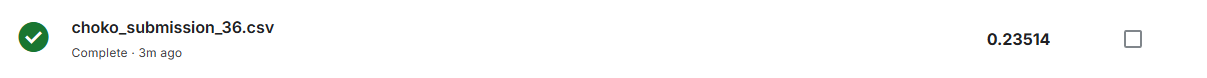

<!-- {'learning_rate': 0.008553940111605946, 'n_estimators': 2114, 'l2_leaf_reg': 1.4163130536678312, 'random_strength': 4.287920281067569, 'bagging_temperature': 0.7916641053388684, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 7, 'rsm': 0.9923008576207031} -->

In [ ]:
# {'learning_rate': 0.008553940111605946, 'n_estimators': 2114, 'l2_leaf_reg': 1.4163130536678312, 'random_strength': 4.287920281067569, 'bagging_temperature': 0.7916641053388684, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 7, 'rsm': 0.9923008576207031}

In [ ]:
875
0.9676140981916675
0.028993107695535775

0.028993107695535775

In [ ]:
# y_test = pd.read_csv('choko_submission_29.csv', usecols=['Rating']).values.reshape(-1)

# print(SEED)
# r2 = r2_score(y_test, pred)
# print(r2)
# mae = MAE(y_test, pred)
# print(mae)

In [ ]:
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_contour, plot_slice

In [ ]:
plot_optimization_history(study).show()
plot_param_importances(study).show()
# plot_contour(study, params=["max_depth", "n_estimators"]).show()
# plot_slice(study, params=["max_depth", "subsample", "n_estimators"]).show()

ValueError: Parameter max_depth does not exist in your study.

# Сравнение результатов

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error, mean_squared_error

In [ ]:
submission_32 = pd.read_csv('choko_submission_32.csv', usecols= ['Rating'])
submission_32 = submission_32.values

In [ ]:
submission_35 = pd.read_csv('choko_submission_35.csv', usecols= ['Rating'])
submission_35 = submission_35.values

In [ ]:
submission_35_36 = pd.read_csv('choko_submission_35_36.csv', usecols= ['Rating'])
submission_35_36 = submission_35_36.values

In [ ]:
submission_35_32 = pd.read_csv('choko_submission_35_32.csv', usecols= ['Rating'])
submission_35_32 = submission_35_32.values

In [ ]:
submission_37 = pd.read_csv('choko_submission_37.csv', usecols= ['Rating'])
submission_37 = submission_37.values

In [ ]:
submission_102 = pd.read_csv('choko_submission_102.csv', usecols= ['Rating'])
submission_102 = submission_102.values

In [ ]:
submission_105 = pd.read_csv('choko_submission_105.csv', usecols= ['Rating'])
submission_105 = submission_105.values

In [ ]:
submission_111 = pd.read_csv('choko_submission_111.csv', usecols= ['Rating'])
submission_111 = submission_111.values

In [ ]:
subs_report = pd.DataFrame()

submission_lst = [(submission_32, '32'), (submission_35, '35'), (submission_35_36, '3536'), (submission_35_32, '3532'), 
                  (submission_37, '37'), (submission_102, '102'), (submission_105, '105'), (submission_111, '111')]

for i in range(len(submission_lst)):
    for j in range(len(submission_lst)):
        if i != j:
            i_name, j_name = submission_lst[i][1], submission_lst[j][1]
            mae = mean_absolute_error(submission_lst[i][0], submission_lst[j][0])
            mape = mean_absolute_percentage_error(submission_lst[i][0], submission_lst[j][0])
            rmse = root_mean_squared_error(submission_lst[i][0], submission_lst[j][0])
            mse = mean_squared_error(submission_lst[i][0], submission_lst[j][0])
            report = pd.DataFrame(columns=['MAE', 'MAPE', 'RMSE', 'MSE'], data=[[0, 0, 0, 0]])
            report[['MAE', 'MAPE', 'RMSE', 'MSE']] =  mae, mape, rmse, mse
            report.index = [f'{i_name}-{j_name}',]
            subs_report = pd.concat([subs_report, report], axis=0)

    # return subs_report



In [ ]:
subs_report

,MAE,MAPE,RMSE,MSE
32-35,0.049638,0.015625,0.064480,0.004158
32-3536,0.029228,0.009211,0.038588,0.001489
32-3532,0.024819,0.007813,0.032240,0.001039
32-37,0.047462,0.014953,0.061630,0.003798
32-102,0.061977,0.019571,0.082467,0.006801
32-105,0.068202,0.021445,0.088838,0.007892
32-111,0.067086,0.021094,0.087586,0.007671
35-32,0.049638,0.015678,0.064480,0.004158
35-3536,0.026113,0.008248,0.034253,0.001173
35-3532,0.024819,0.007839,0.032240,0.001039


# Tail